In [1]:
import pandas as pd
import numpy as np

import hts
from hts import HTSRegressor
import pmdarima as pm
from fbprophet import Prophet


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from hts.hierarchy import HierarchyTree

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# import the data files
data = pd.read_excel('./data - Continente e Ilhas.xlsx',sheet_name='Sheet2', skiprows=2, usecols="A:D", header=None, index_col=0)

In [4]:
first_row = data.loc["Years",:]
data.columns=first_row
data.drop(data.index[[0]],inplace=True)

In [5]:
# lowercase the column names
data.columns = [col_name.lower() for col_name in data.columns]

In [6]:
# map the full NUTSI names to abbreviations
nutsi_dict = {
    "Portugal Continental": "PT_C",
    "Regiões Autónomas": "RA",
}

data["nutsi"] = data["nutsi"].map(nutsi_dict)

# map the full Zones names to abbreviations
zones_dict = {
    "Norte e Centro": "NT&CT",
    "Sul": "S",
    "Região Autónoma dos Açores": "AÇR",
    "Região Autónoma da Madeira": "MAD",
}

data["zones"] = data["zones"].map(zones_dict)

# create the bottom level id
data["nutsi_zones"] = data.apply(lambda x: f"{x['nutsi']}_{x['zones']}", axis=1)

data.head()

nutsi  zones nº of nights nutsi_zones
0                                                        
2012-12-31 00:00:00  PT_C  NT&CT     2333.144  PT_C_NT&CT
2012-12-31 00:00:00  PT_C      S    15468.919      PT_C_S
2012-12-31 00:00:00    RA    MAD     5507.685      RA_MAD
2012-12-31 00:00:00    RA    AÇR      257.839      RA_AÇR
2013-12-31 00:00:00  PT_C  NT&CT    11486.045  PT_C_NT&CT

In [7]:
data.reset_index(inplace=True)
data.columns.values[0]="date"
data.head()

date nutsi  zones nº of nights nutsi_zones
0 2012-12-31  PT_C  NT&CT     2333.144  PT_C_NT&CT
1 2012-12-31  PT_C      S    15468.919      PT_C_S
2 2012-12-31    RA    MAD     5507.685      RA_MAD
3 2012-12-31    RA    AÇR      257.839      RA_AÇR
4 2013-12-31  PT_C  NT&CT    11486.045  PT_C_NT&CT

In [8]:
# inspect all the regions per nutsii
data.groupby("nutsi")["zones"].apply(set).to_frame()

zones
nutsi            
PT_C   {S, NT&CT}
RA     {AÇR, MAD}

In [9]:
# create the bottom level data
data_bottom_level = data.pivot(index="date", columns="nutsi_zones", values="nº of nights")

# create the middle level data
data_middle_level = data.groupby(["date", "nutsi"]).sum().reset_index(drop=False).pivot(index="date", columns="nutsi", values="nº of nights")

# create the total level data
data_total = data.groupby("date")["nº of nights"].sum().to_frame().rename(columns={"nº of nights": "total"})


In [58]:

# join the DataFrames
hierarchy_data = data_bottom_level.join(data_middle_level).join(data_total)
hierarchy_data.index = pd.to_datetime(hierarchy_data.index)


print(f"Number of time series at the bottom level: {data_bottom_level.shape[1]}")
print(f"Number of time series at the middle level: {data_middle_level.shape[1]}")

hierarchy_data

Number of time series at the bottom level: 4
Number of time series at the middle level: 2


PT_C_NT&CT     PT_C_S    RA_AÇR    RA_MAD       PT_C         RA  \
date                                                                         
2012-12-31   2333.144  15468.919   257.839  5507.685  17802.063   5765.524   
2013-12-31  11486.045  15309.166   269.142   288.579  26795.211    557.721   
2014-12-31  22828.113  18255.844  1081.949  6506.866  41083.957   7588.815   
2015-12-31  25529.004  19180.704  1289.414  7030.026  44709.708   8319.440   
2016-12-31   28434.06  21140.151  1569.176  7930.908  49574.211   9500.084   
2017-12-31  32468.334  22694.536  1808.448  8359.989  55162.870  10168.437   
2018-12-31  34072.819  23119.192  2085.219  8344.266  57192.011  10429.485   
2019-12-31  36584.637  23839.325  2231.414  7457.197  60423.962   9688.611   
2020-12-31  12982.421   9719.966   654.376  2441.536  22702.387   3095.912   

                total  
date                   
2012-12-31  23567.587  
2013-12-31  27352.932  
2014-12-31  48672.772  
2015-12-31  53029.148  
2016-12-31  59074.295  
2017-12-31  65331.307  
2018-12-31  67621.496  
2019-12-31  70112.573  
2020-12-31  25798.299

In [11]:
#Creating the hierarchy
nutsi = data["nutsi"].unique()
zones = data["nutsi_zones"].unique()

total = {'total': list(nutsi)}
nutsi = {k: [v for v in zones if v.startswith(k)] for k in nutsi}
hierarchy = {**total, **nutsi}

hierarchy

{'total': ['PT_C', 'RA'],
 'PT_C': ['PT_C_NT&CT', 'PT_C_S'],
 'RA': ['RA_MAD', 'RA_AÇR']}

In [12]:
Htree = HierarchyTree.from_nodes(nodes=hierarchy, df=hierarchy_data)
Htree

- total
   |- PT_C
   |  |- PT_C_NT&CT
   |  - PT_C_S
   - RA
      |- RA_MAD
      - RA_AÇR

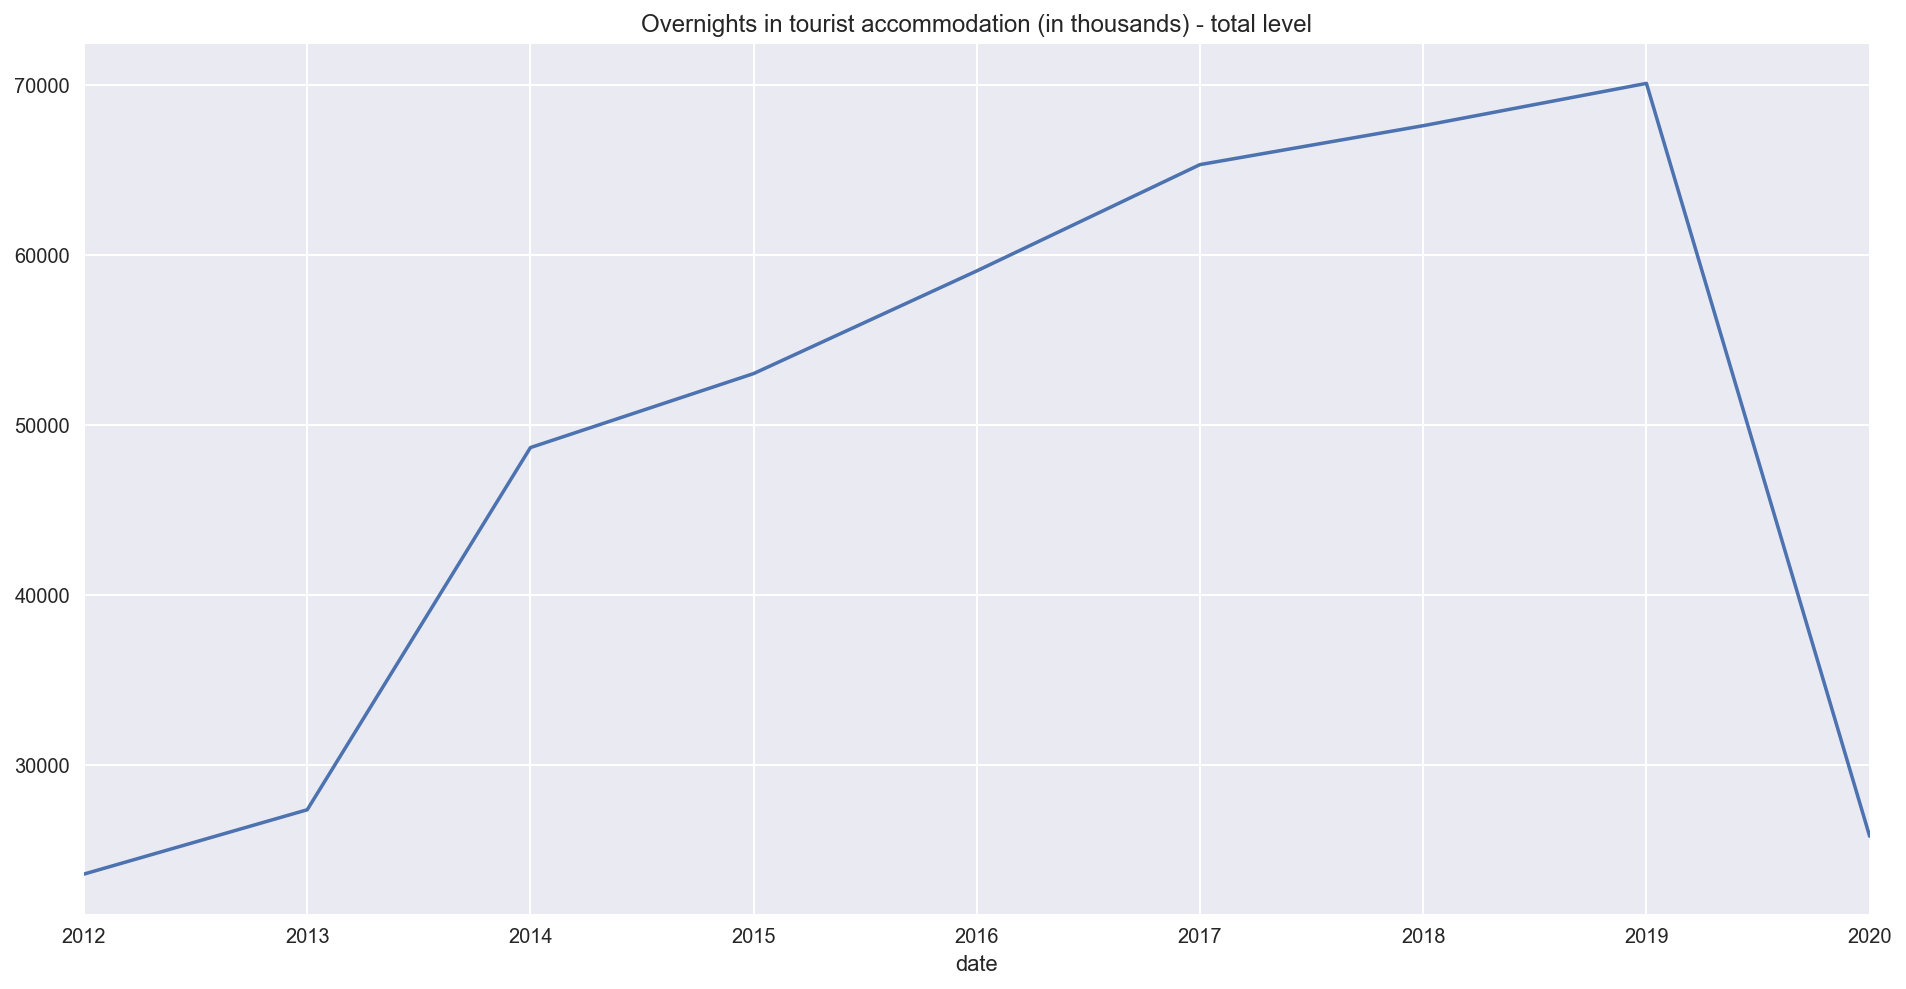

In [13]:
hierarchy_data["total"].plot(title="Overnights in tourist accommodation (in thousands) - total level");

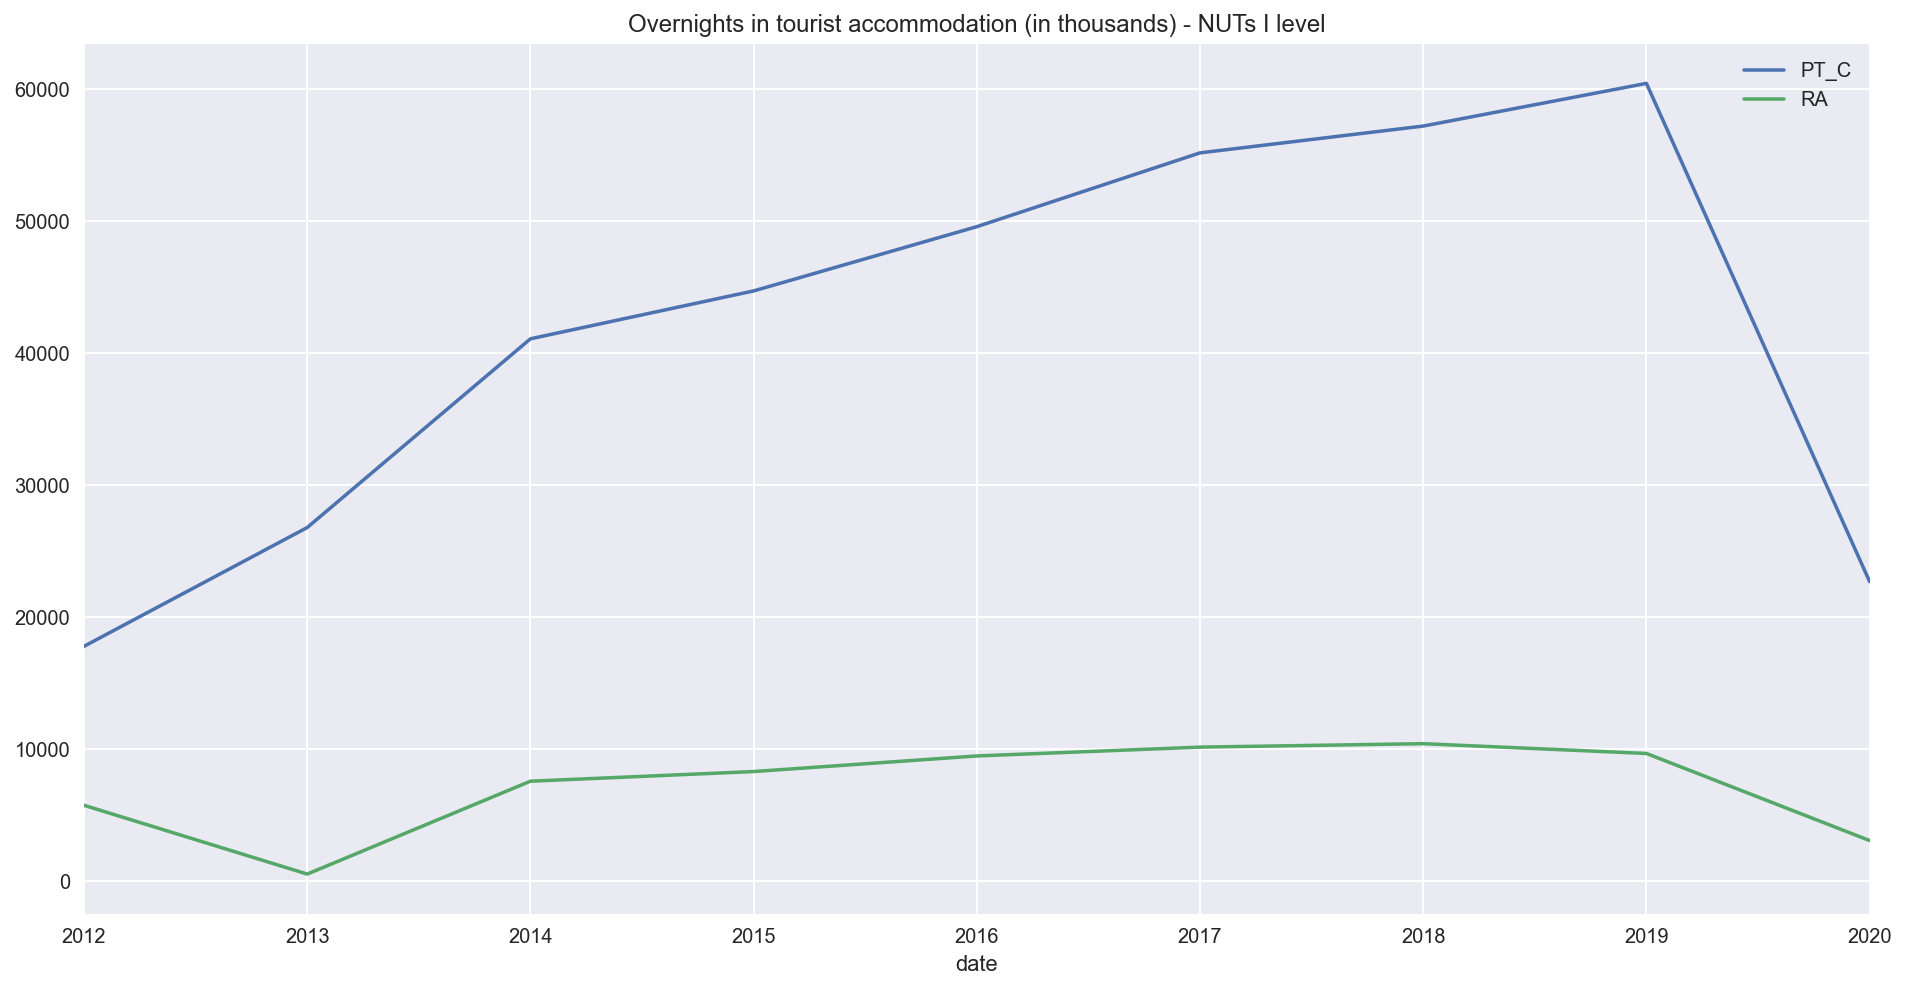

In [14]:
ax = hierarchy_data[hierarchy['total']].plot(title="Overnights in tourist accommodation (in thousands) - NUTs I level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

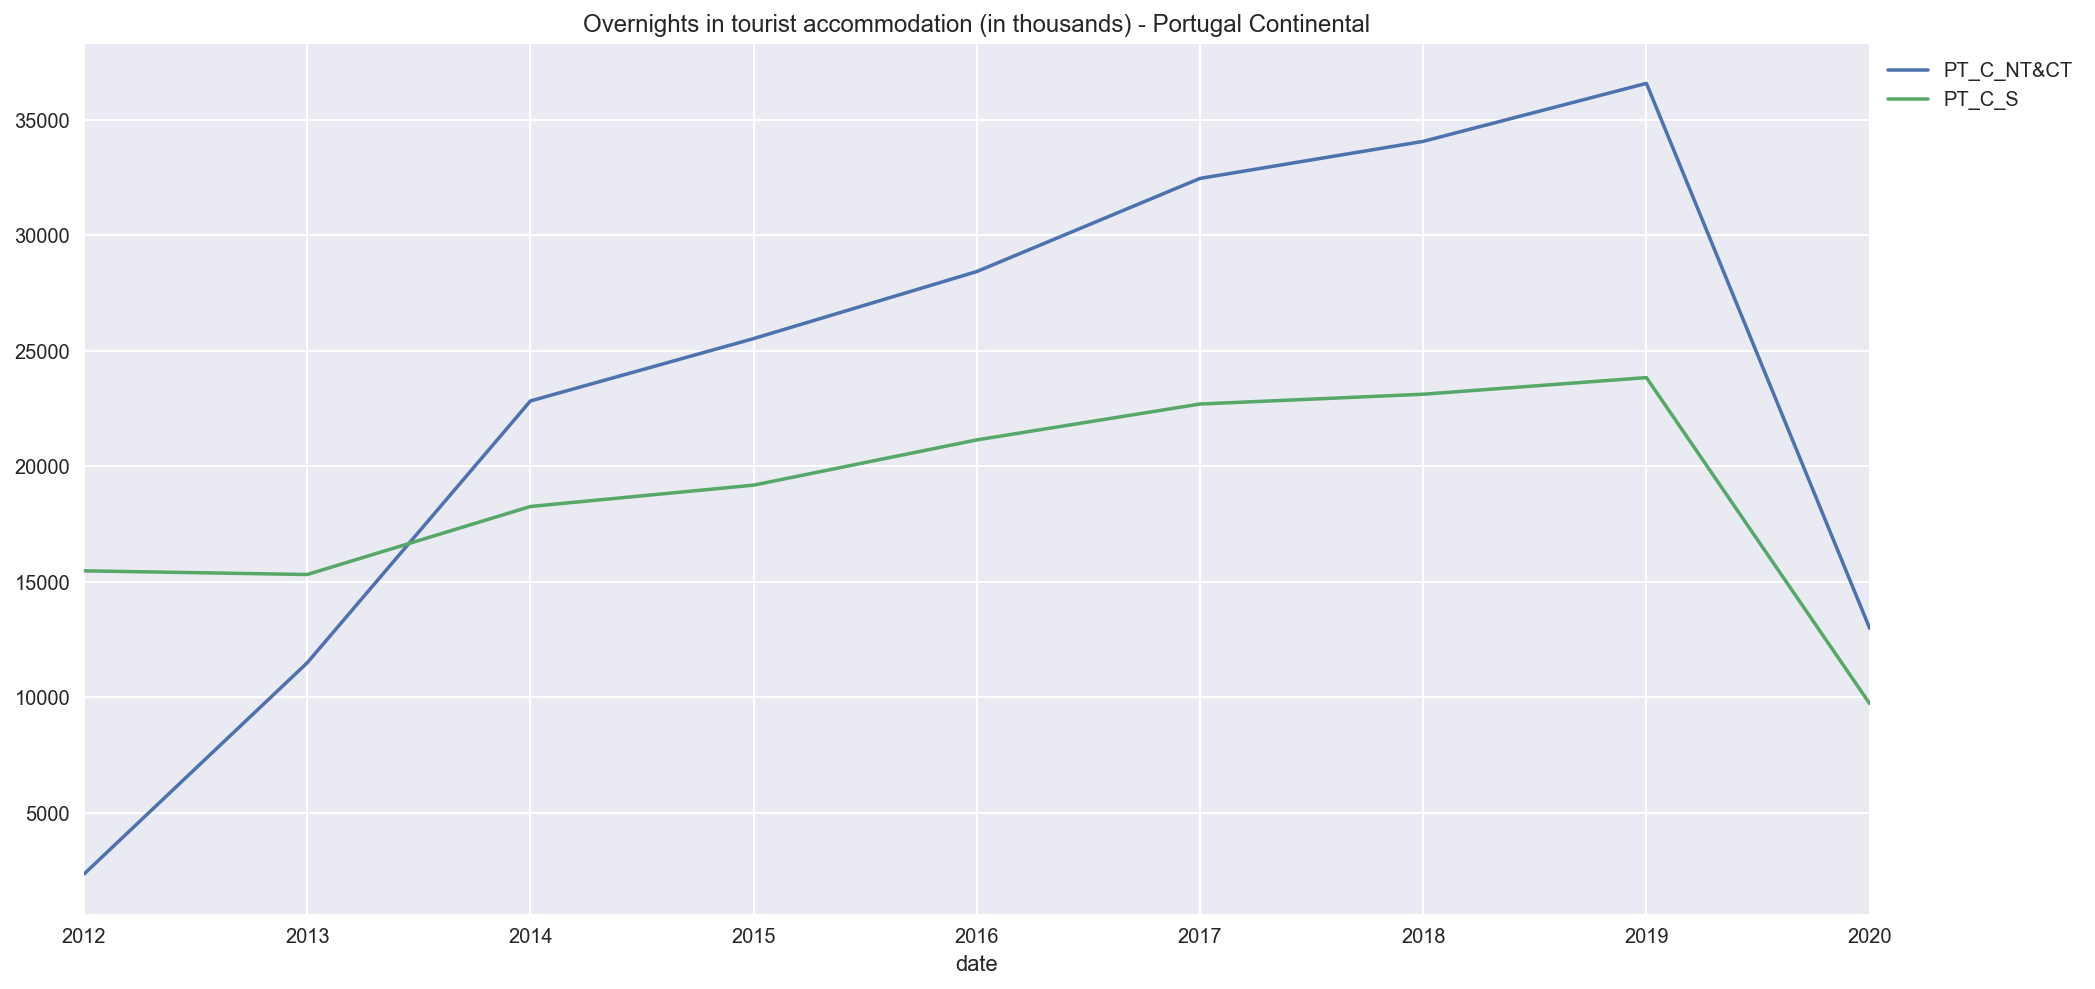

In [15]:
ax = hierarchy_data[hierarchy['PT_C']].plot(title="Overnights in tourist accommodation (in thousands) - Portugal Continental")
ax.legend(bbox_to_anchor=(1.0, 1.0));

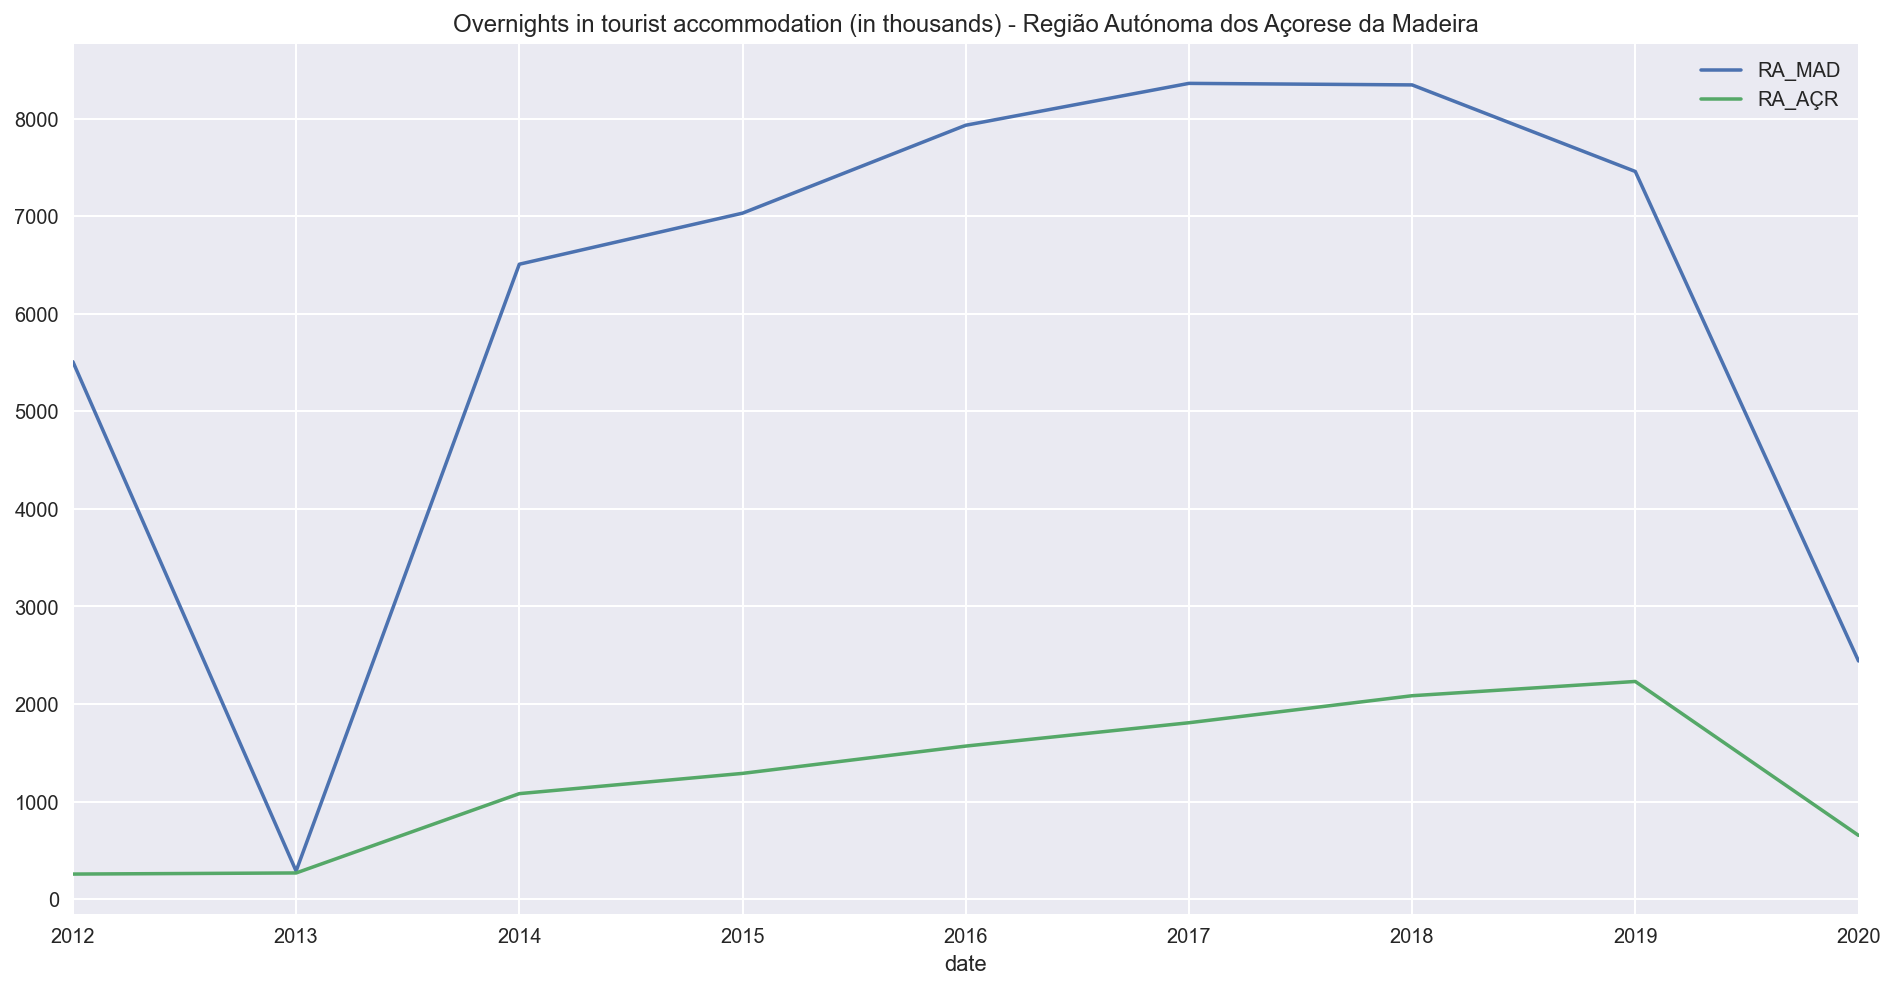

In [16]:
ax = hierarchy_data[hierarchy['RA']].plot(title="Overnights in tourist accommodation (in thousands) - Região Autónoma dos Açorese da Madeira")
ax.legend(bbox_to_anchor=(1.0, 1.0));

## Hierarchical time series Forecasting

In [17]:
def plot_results(cols, axes, preds):
    axes = np.hstack(axes)
    for ax, col in zip(axes, cols):
        preds[col].plot(ax=ax, label="Predicted")
        hierarchy_data[col].plot(ax=ax, label="Observed")

        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("N of Nights")

## 1. Using Arima as base forecast

## 1.1. Bottom-up approach

In [18]:
arima_bu = hts.HTSRegressor(model='auto_arima', revision_method='BU', n_jobs=0)
arima_bu = arima_bu.fit(hierarchy_data, hierarchy)
pred_arima_bu = arima_bu.predict(steps_ahead=1)

Fitting models: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 220.09it/s]


In [19]:
pred_arima_bu.round()

total    PT_C       RA  PT_C_NT&CT   PT_C_S  RA_MAD  RA_AÇR
2012-12-31  47701.0  5985.0  41716.0     22969.0  18748.0  5985.0     0.0
2013-12-31  47921.0  6205.0  41716.0     22969.0  18748.0  5985.0   220.0
2014-12-31  47931.0  6215.0  41716.0     22969.0  18748.0  5985.0   230.0
2015-12-31  48624.0  6908.0  41716.0     22969.0  18748.0  5985.0   923.0
2016-12-31  48801.0  7085.0  41716.0     22969.0  18748.0  5985.0  1100.0
2017-12-31  49040.0  7324.0  41716.0     22969.0  18748.0  5985.0  1338.0
2018-12-31  49244.0  7528.0  41716.0     22969.0  18748.0  5985.0  1543.0
2019-12-31  49480.0  7764.0  41716.0     22969.0  18748.0  5985.0  1779.0
2020-12-31  49605.0  7889.0  41716.0     22969.0  18748.0  5985.0  1903.0
2021-01-01  48260.0  6543.0  41716.0     22969.0  18748.0  5985.0   558.0

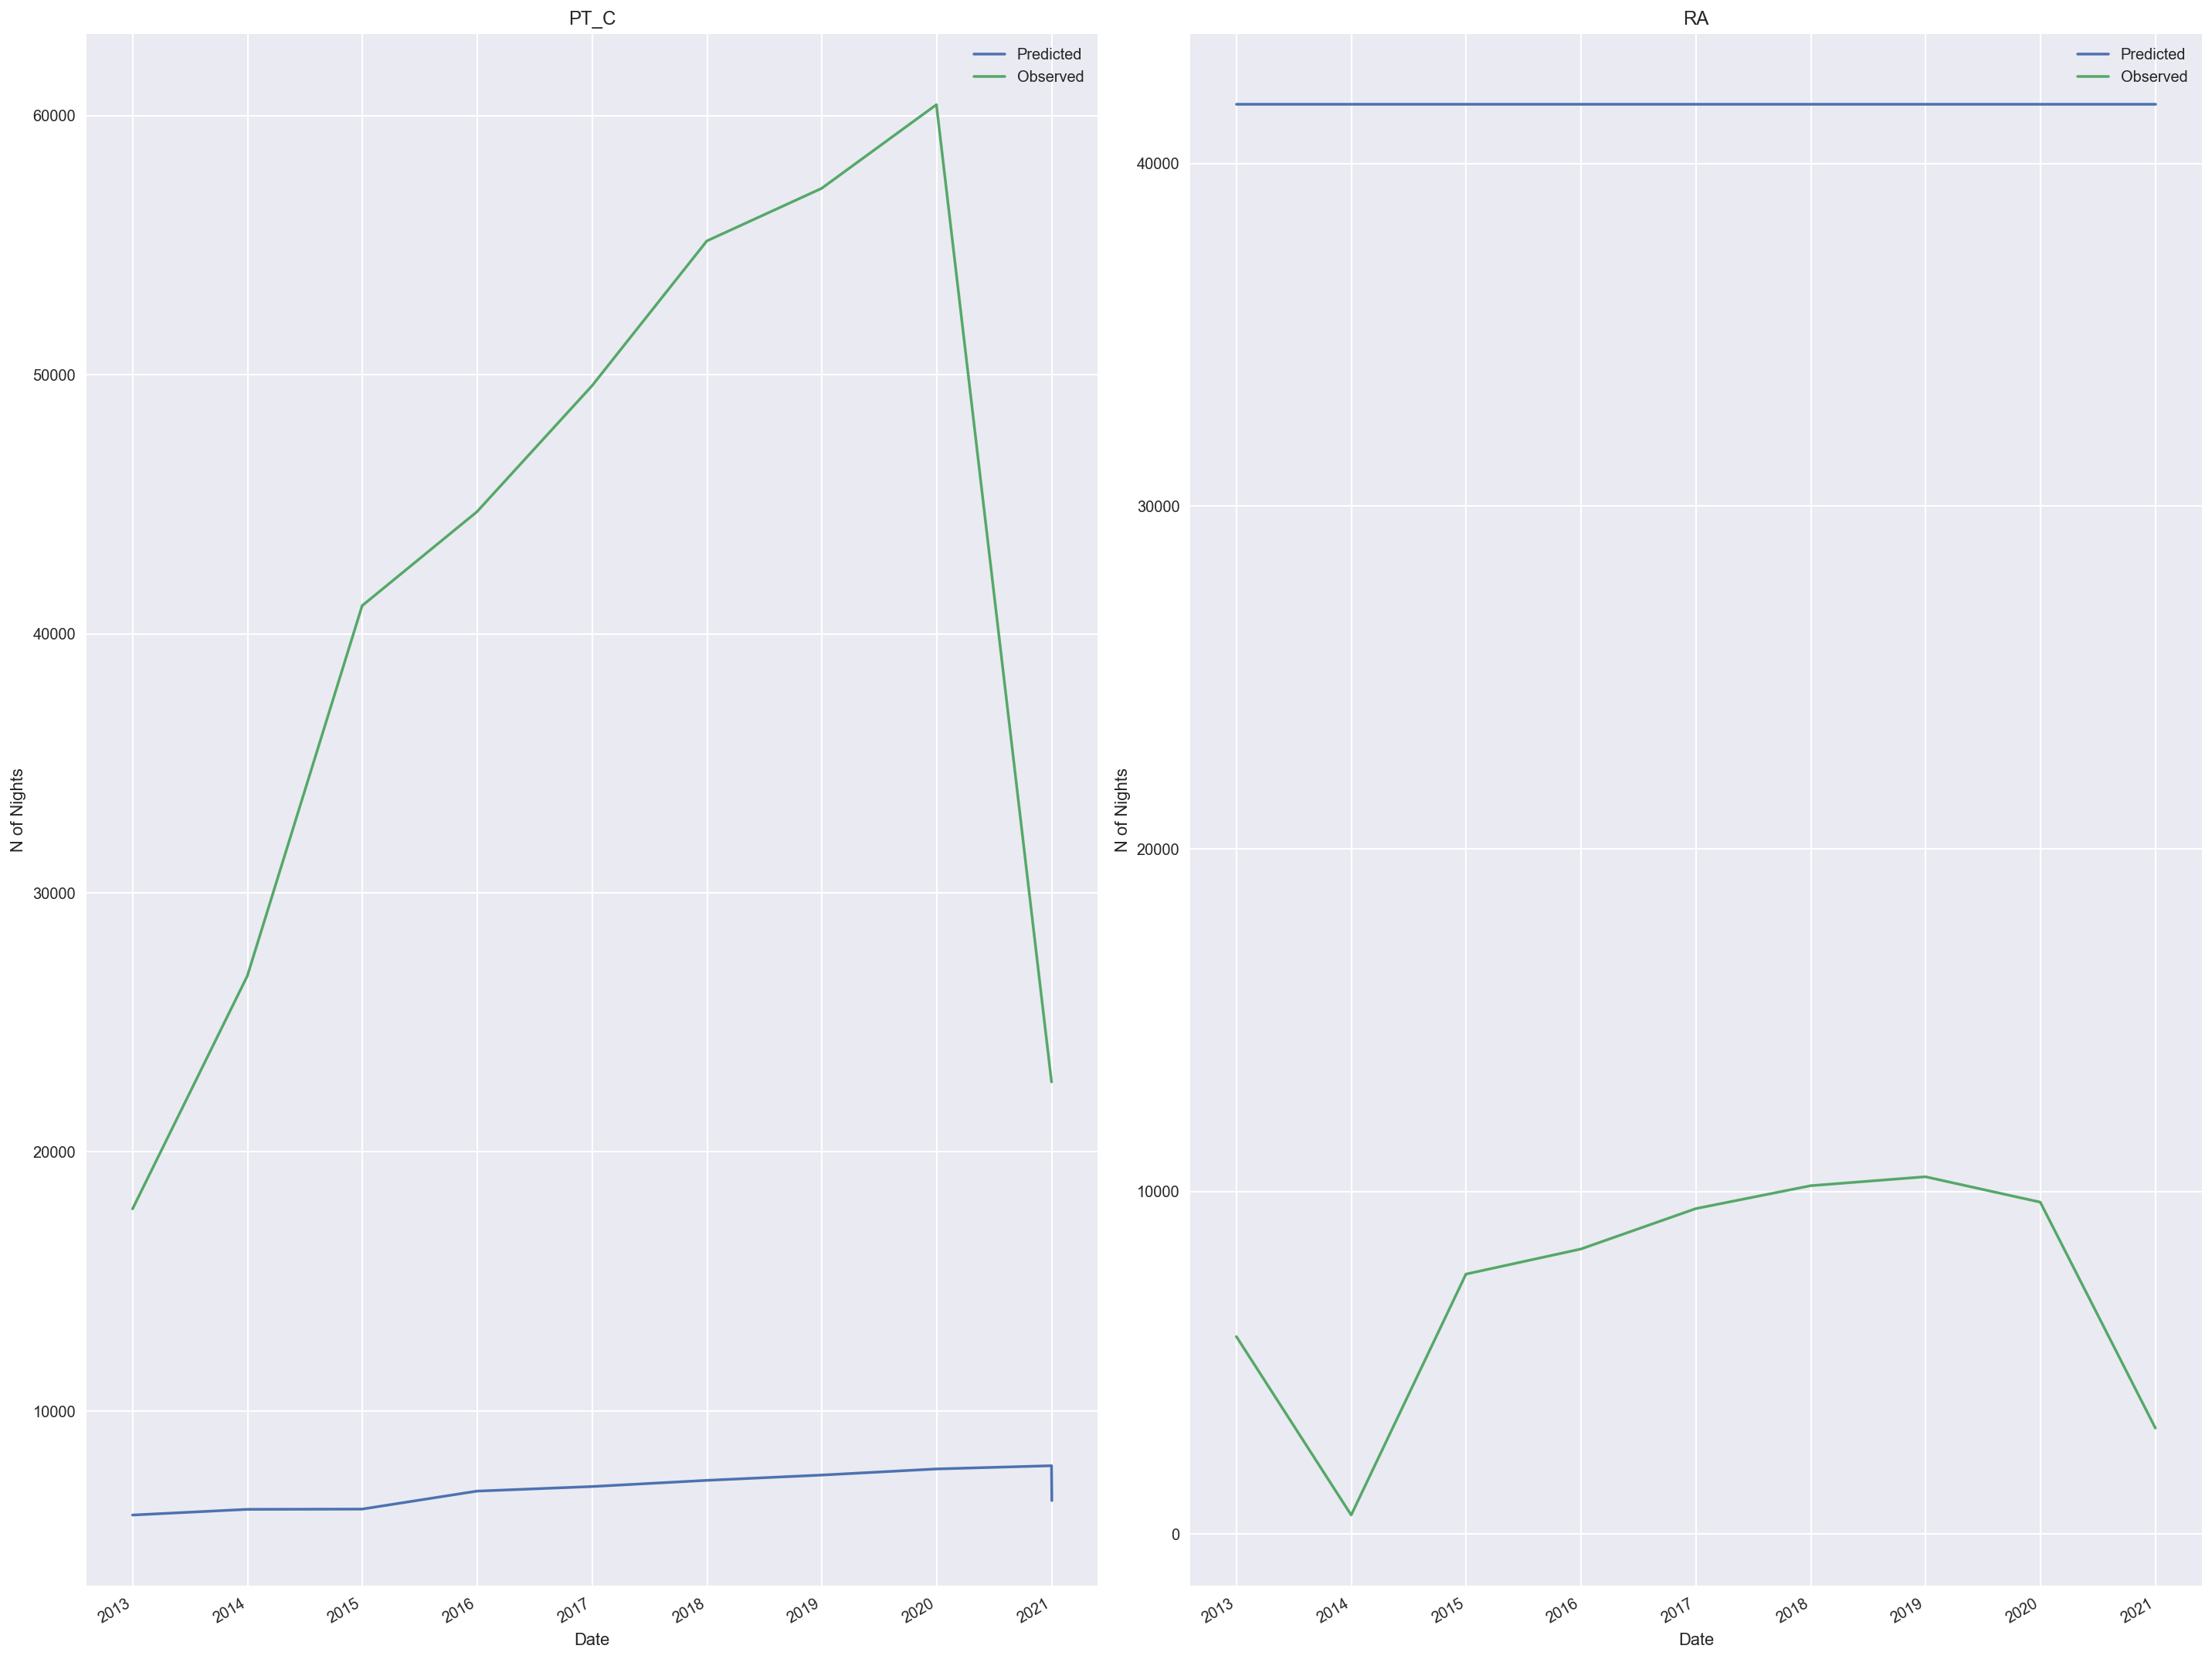

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
plot_results(nutsi, axes, pred_arima_bu)
plt.tight_layout()

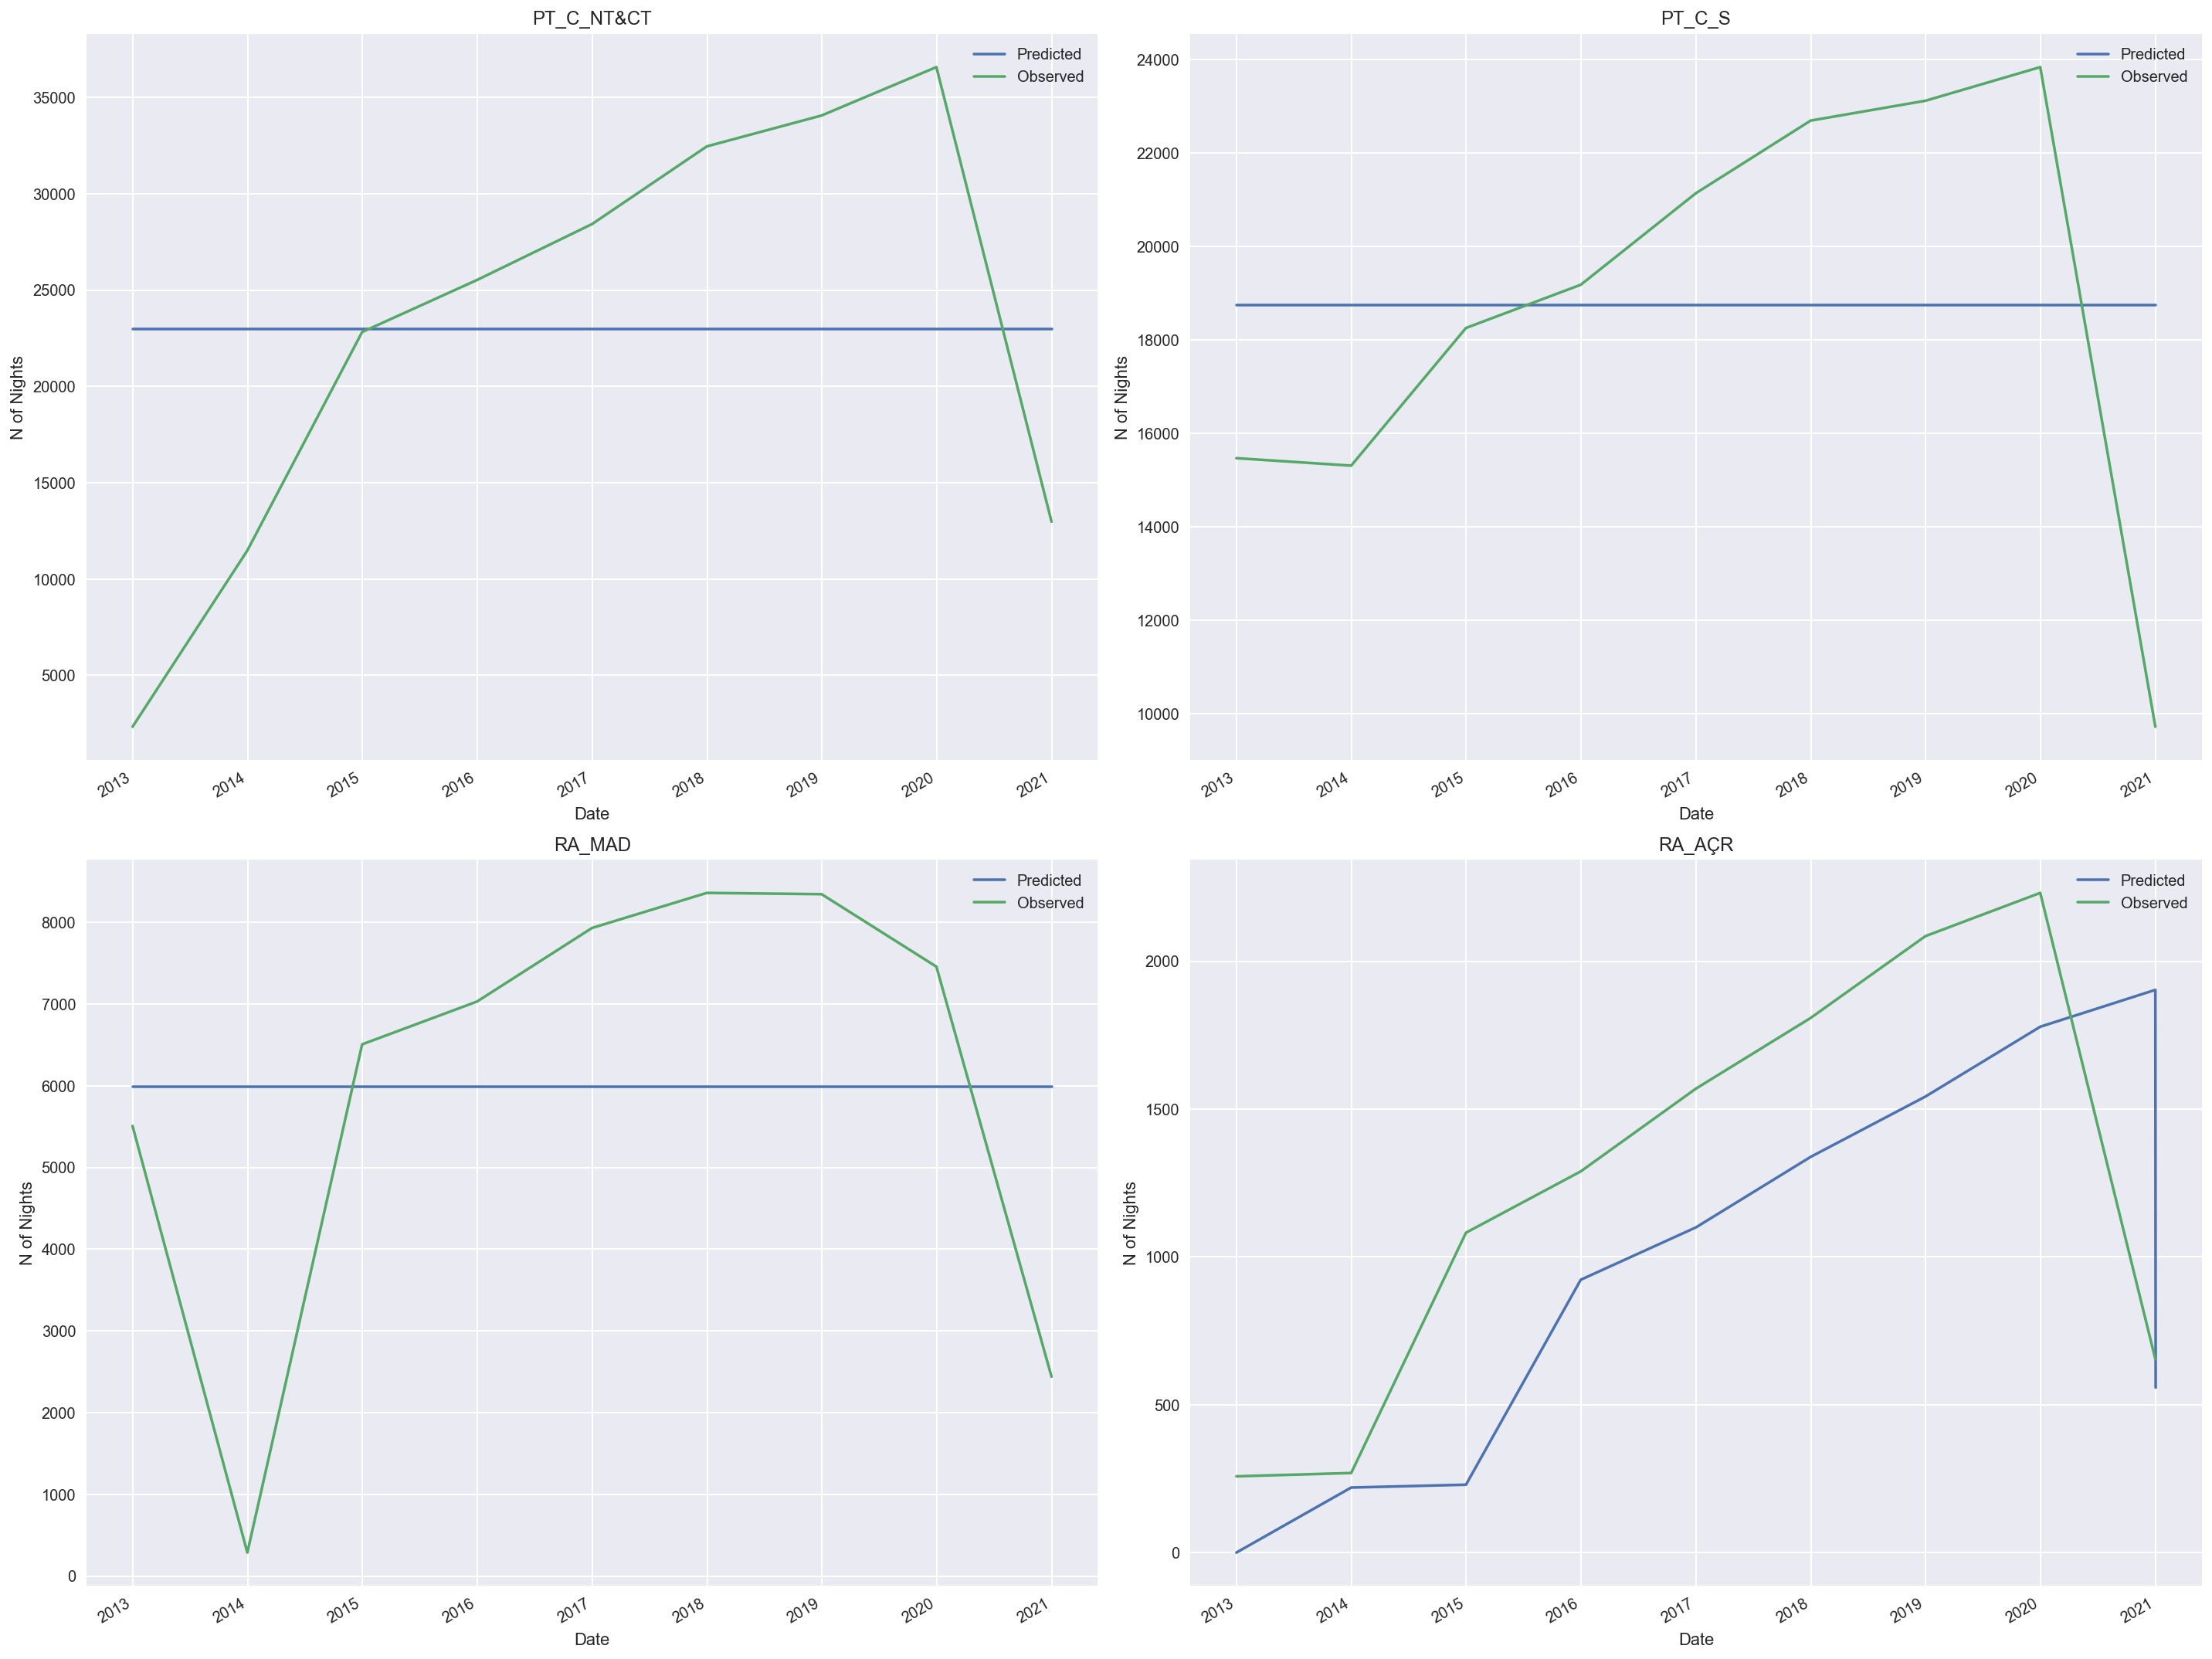

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_arima_bu)
plt.tight_layout()

## 1.2. Top-down approach

In [22]:
arima_td = hts.HTSRegressor(model='auto_arima', revision_method='AHP', n_jobs=0)
arima_td = arima_td.fit(hierarchy_data, hierarchy)
pred_arima_td = arima_td.predict(steps_ahead=1)

Fitting models: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 325.36it/s]


In [23]:
pred_arima_td.round()

total    PT_C       RA  PT_C_NT&CT   PT_C_S  RA_MAD  RA_AÇR
2012-12-31  48951.0  7107.0  41844.0     21629.0  20215.0  5967.0  1140.0
2013-12-31  48951.0  7107.0  41844.0     21629.0  20215.0  5967.0  1140.0
2014-12-31  48951.0  7107.0  41844.0     21629.0  20215.0  5967.0  1140.0
2015-12-31  48951.0  7107.0  41844.0     21629.0  20215.0  5967.0  1140.0
2016-12-31  48951.0  7107.0  41844.0     21629.0  20215.0  5967.0  1140.0
2017-12-31  48951.0  7107.0  41844.0     21629.0  20215.0  5967.0  1140.0
2018-12-31  48951.0  7107.0  41844.0     21629.0  20215.0  5967.0  1140.0
2019-12-31  48951.0  7107.0  41844.0     21629.0  20215.0  5967.0  1140.0
2020-12-31  48951.0  7107.0  41844.0     21629.0  20215.0  5967.0  1140.0
2021-01-01  48951.0  7107.0  41844.0     21629.0  20215.0  5967.0  1140.0

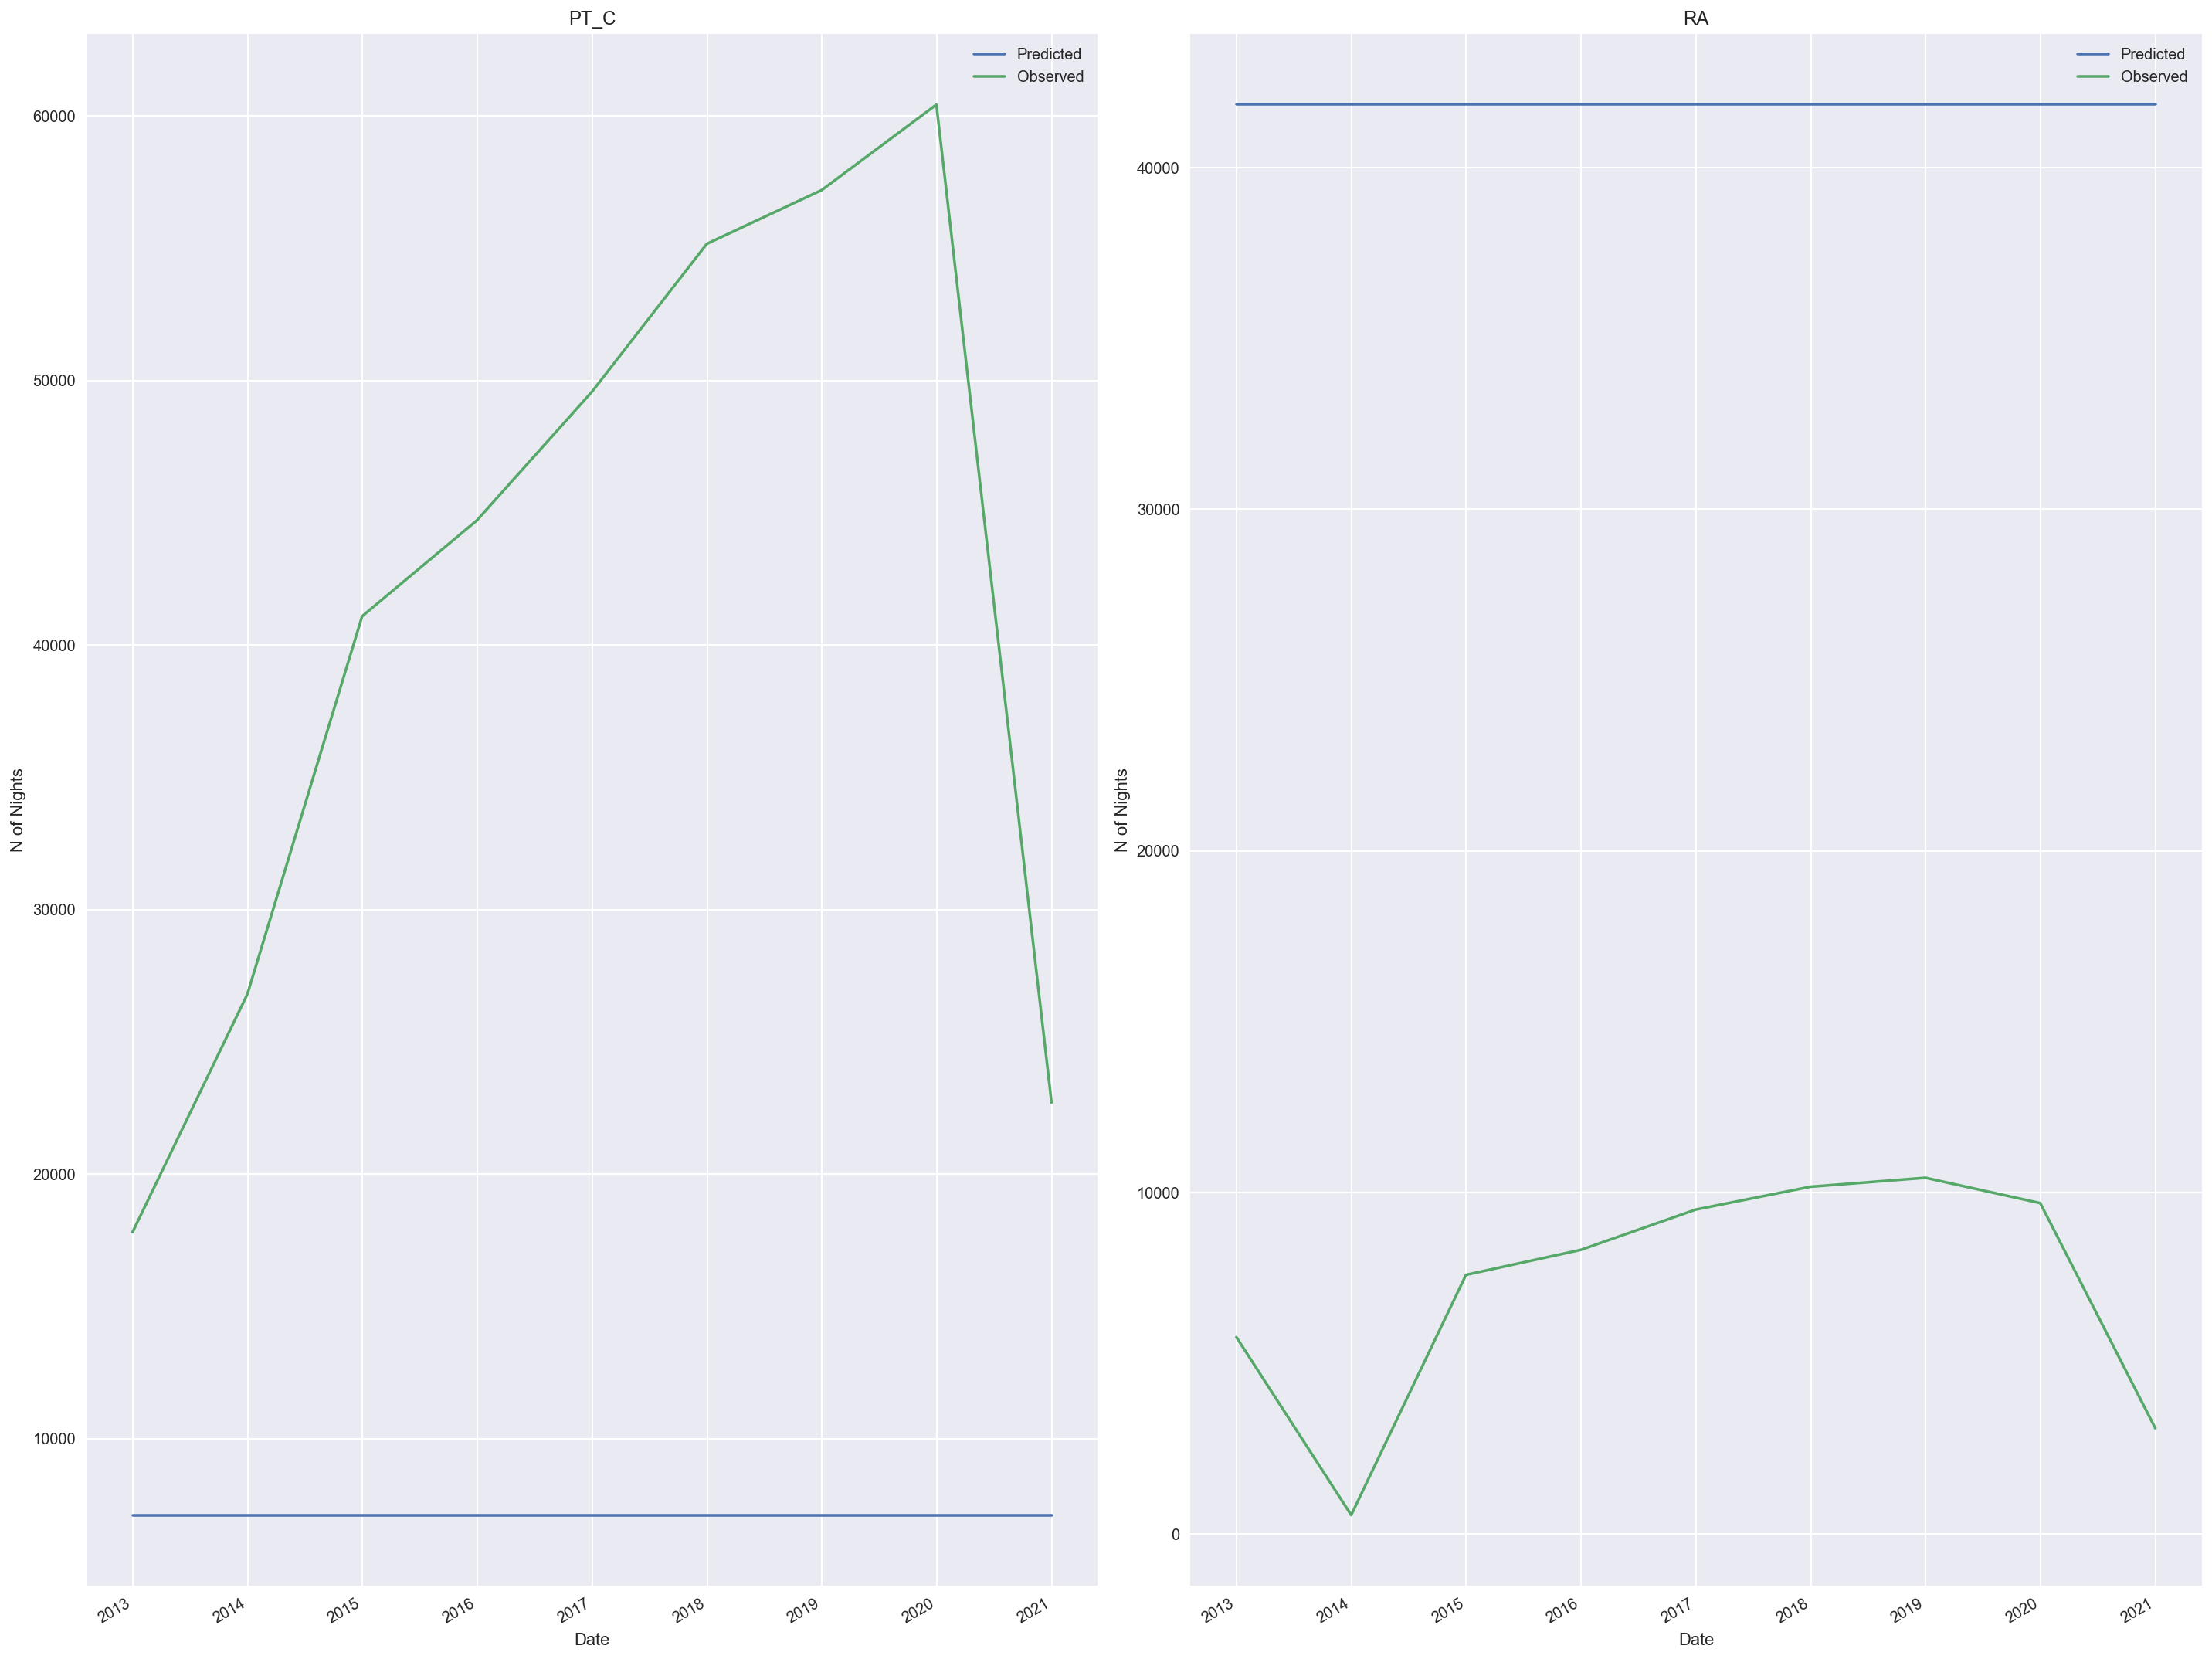

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
plot_results(nutsi, axes, pred_arima_td)
plt.tight_layout()

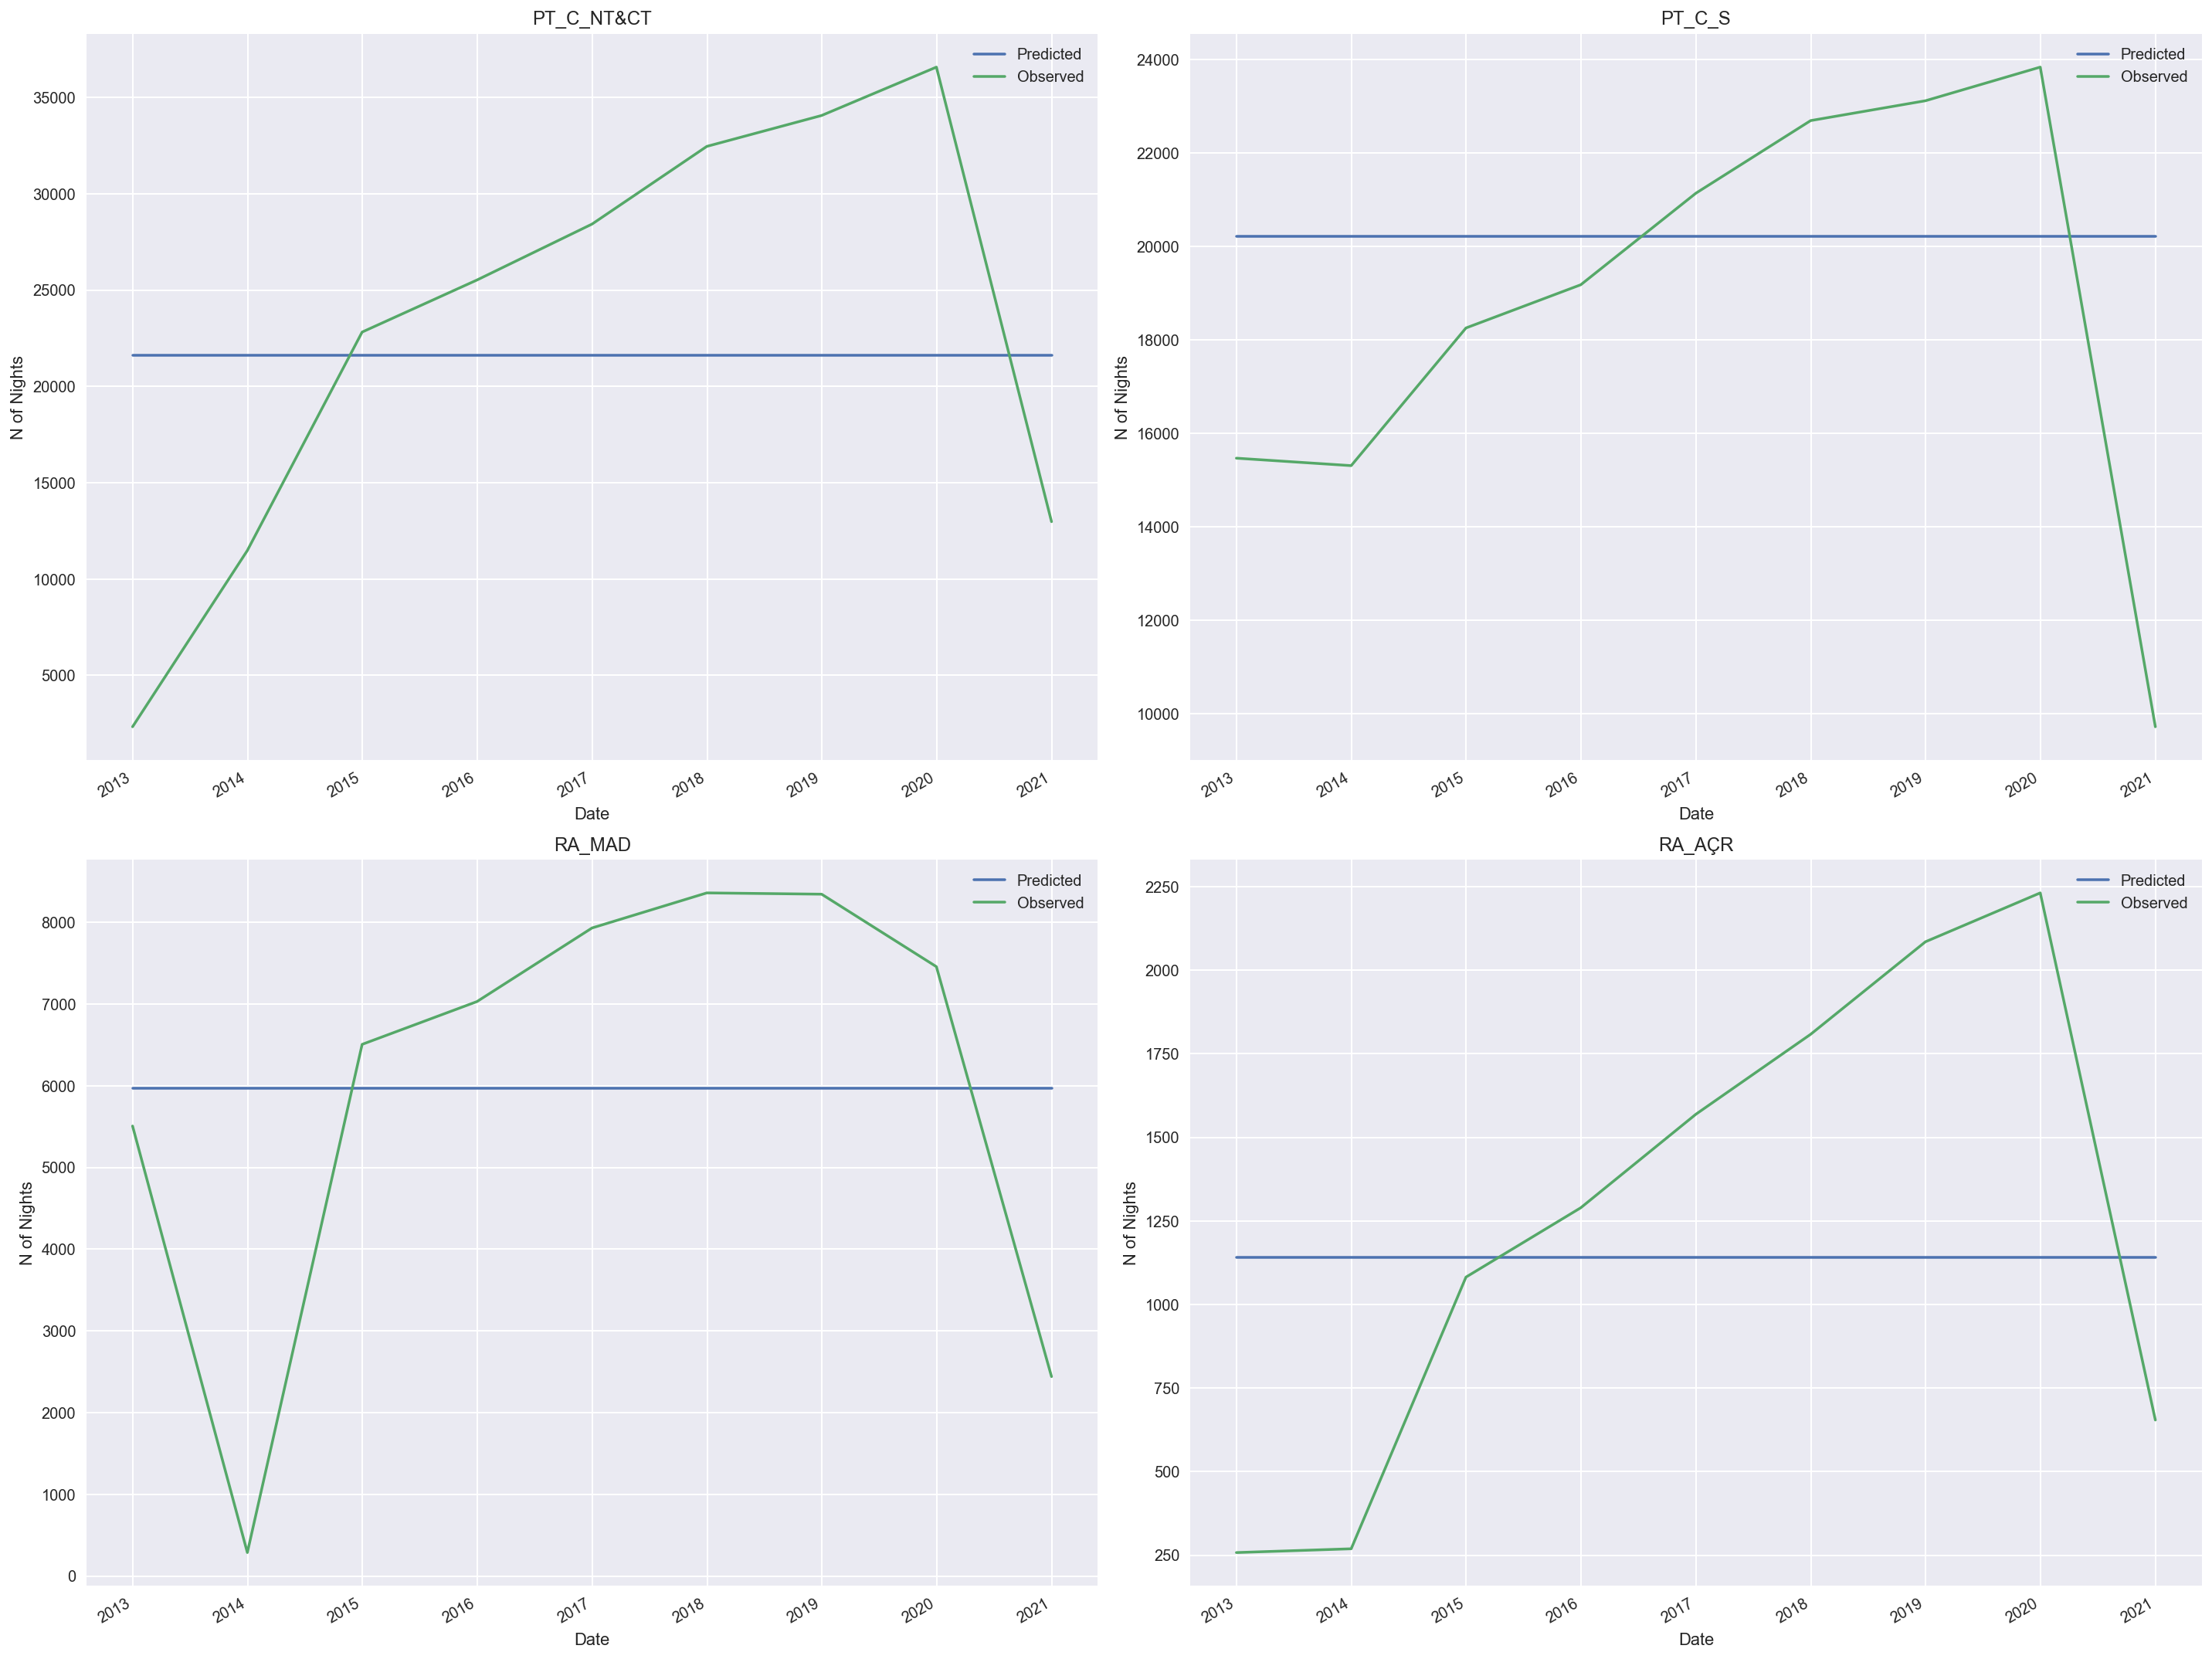

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_arima_td)
plt.tight_layout()

## 1.3. optimal combination using OLS approach

In [26]:
arima_ols = hts.HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0)
arima_ols = arima_ols.fit(hierarchy_data, hierarchy)
pred_arima_ols = arima_ols.predict(steps_ahead=1)

Fitting models: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 222.26it/s]


In [27]:
pred_arima_ols.round()

total     PT_C       RA  PT_C_NT&CT  PT_C_S   RA_MAD   RA_AÇR
2012-12-31  48773.0  29925.0  18848.0     11534.0  7313.0  17955.0  11970.0
2013-12-31  48804.0  29977.0  18827.0     11524.0  7303.0  17871.0  12106.0
2014-12-31  48805.0  29980.0  18826.0     11524.0  7302.0  17868.0  12112.0
2015-12-31  48904.0  30145.0  18760.0     11491.0  7269.0  17604.0  12541.0
2016-12-31  48930.0  30187.0  18743.0     11482.0  7261.0  17536.0  12651.0
2017-12-31  48964.0  30244.0  18720.0     11471.0  7250.0  17445.0  12798.0
2018-12-31  48993.0  30292.0  18701.0     11461.0  7240.0  17367.0  12925.0
2019-12-31  49027.0  30348.0  18678.0     11450.0  7229.0  17278.0  13071.0
2020-12-31  49045.0  30378.0  18666.0     11444.0  7223.0  17230.0  13148.0
2021-01-01  48852.0  30058.0  18795.0     11508.0  7287.0  17742.0  12315.0

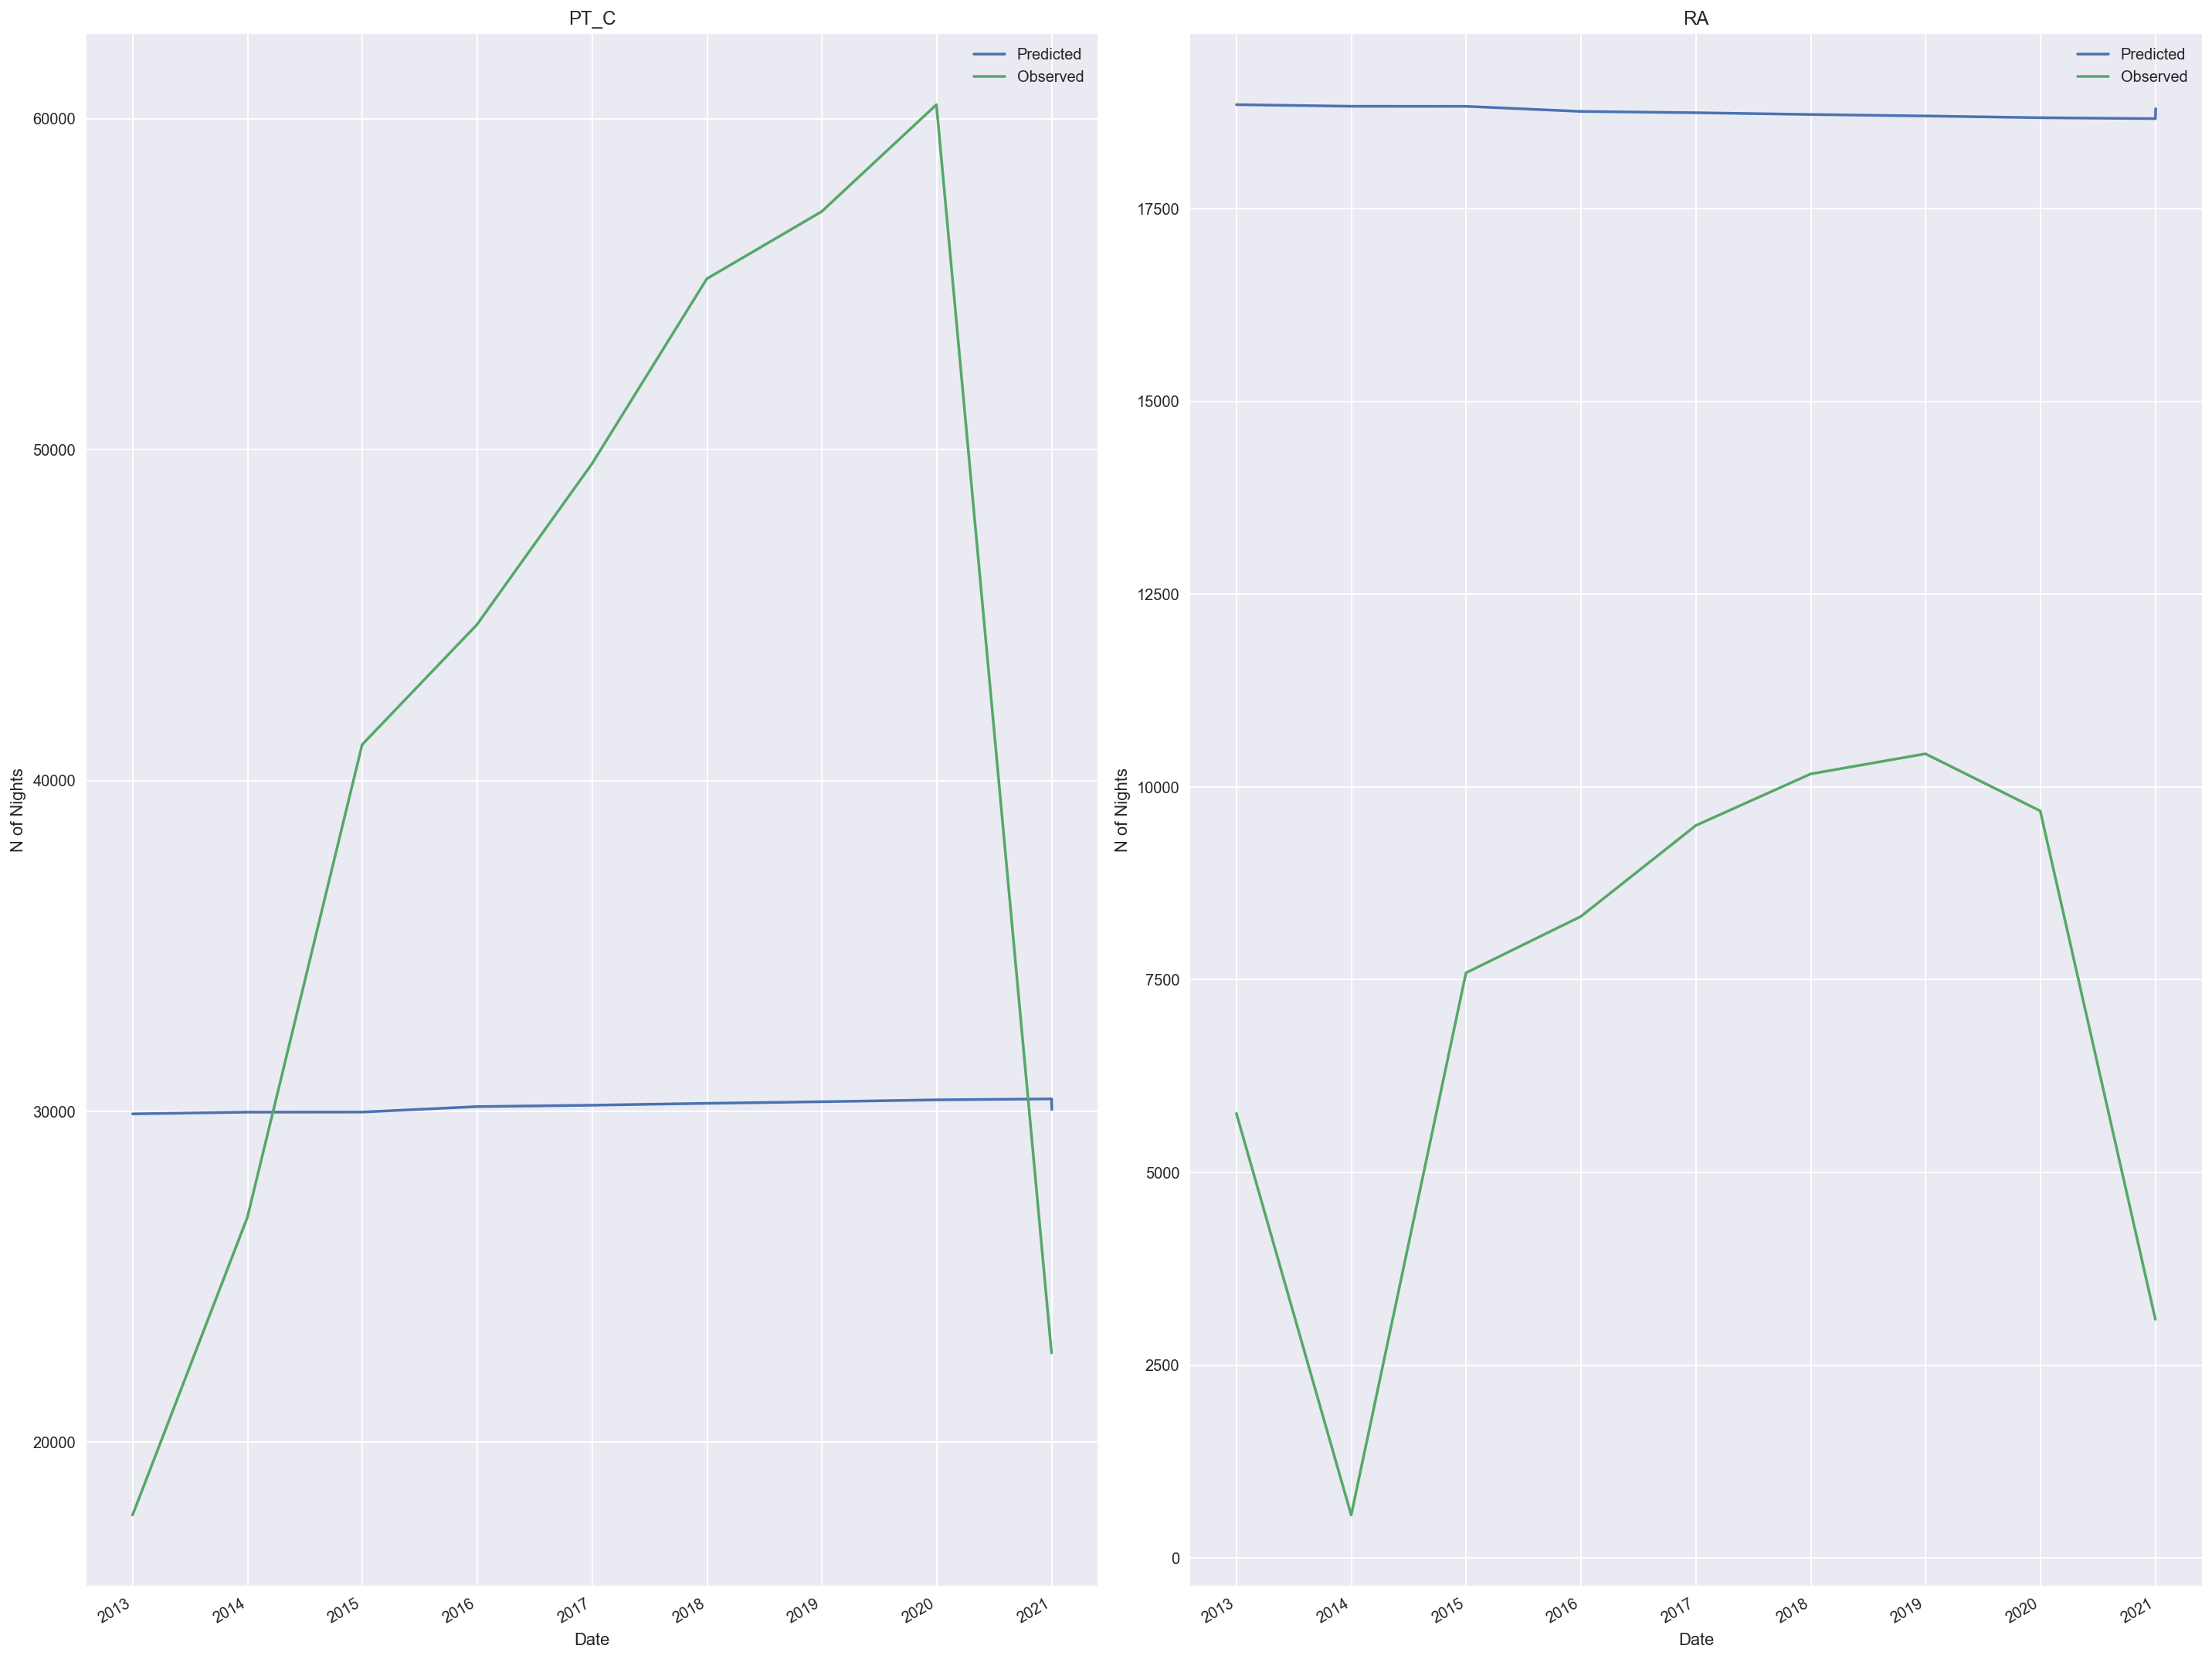

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
plot_results(nutsi, axes, pred_arima_ols)
plt.tight_layout()

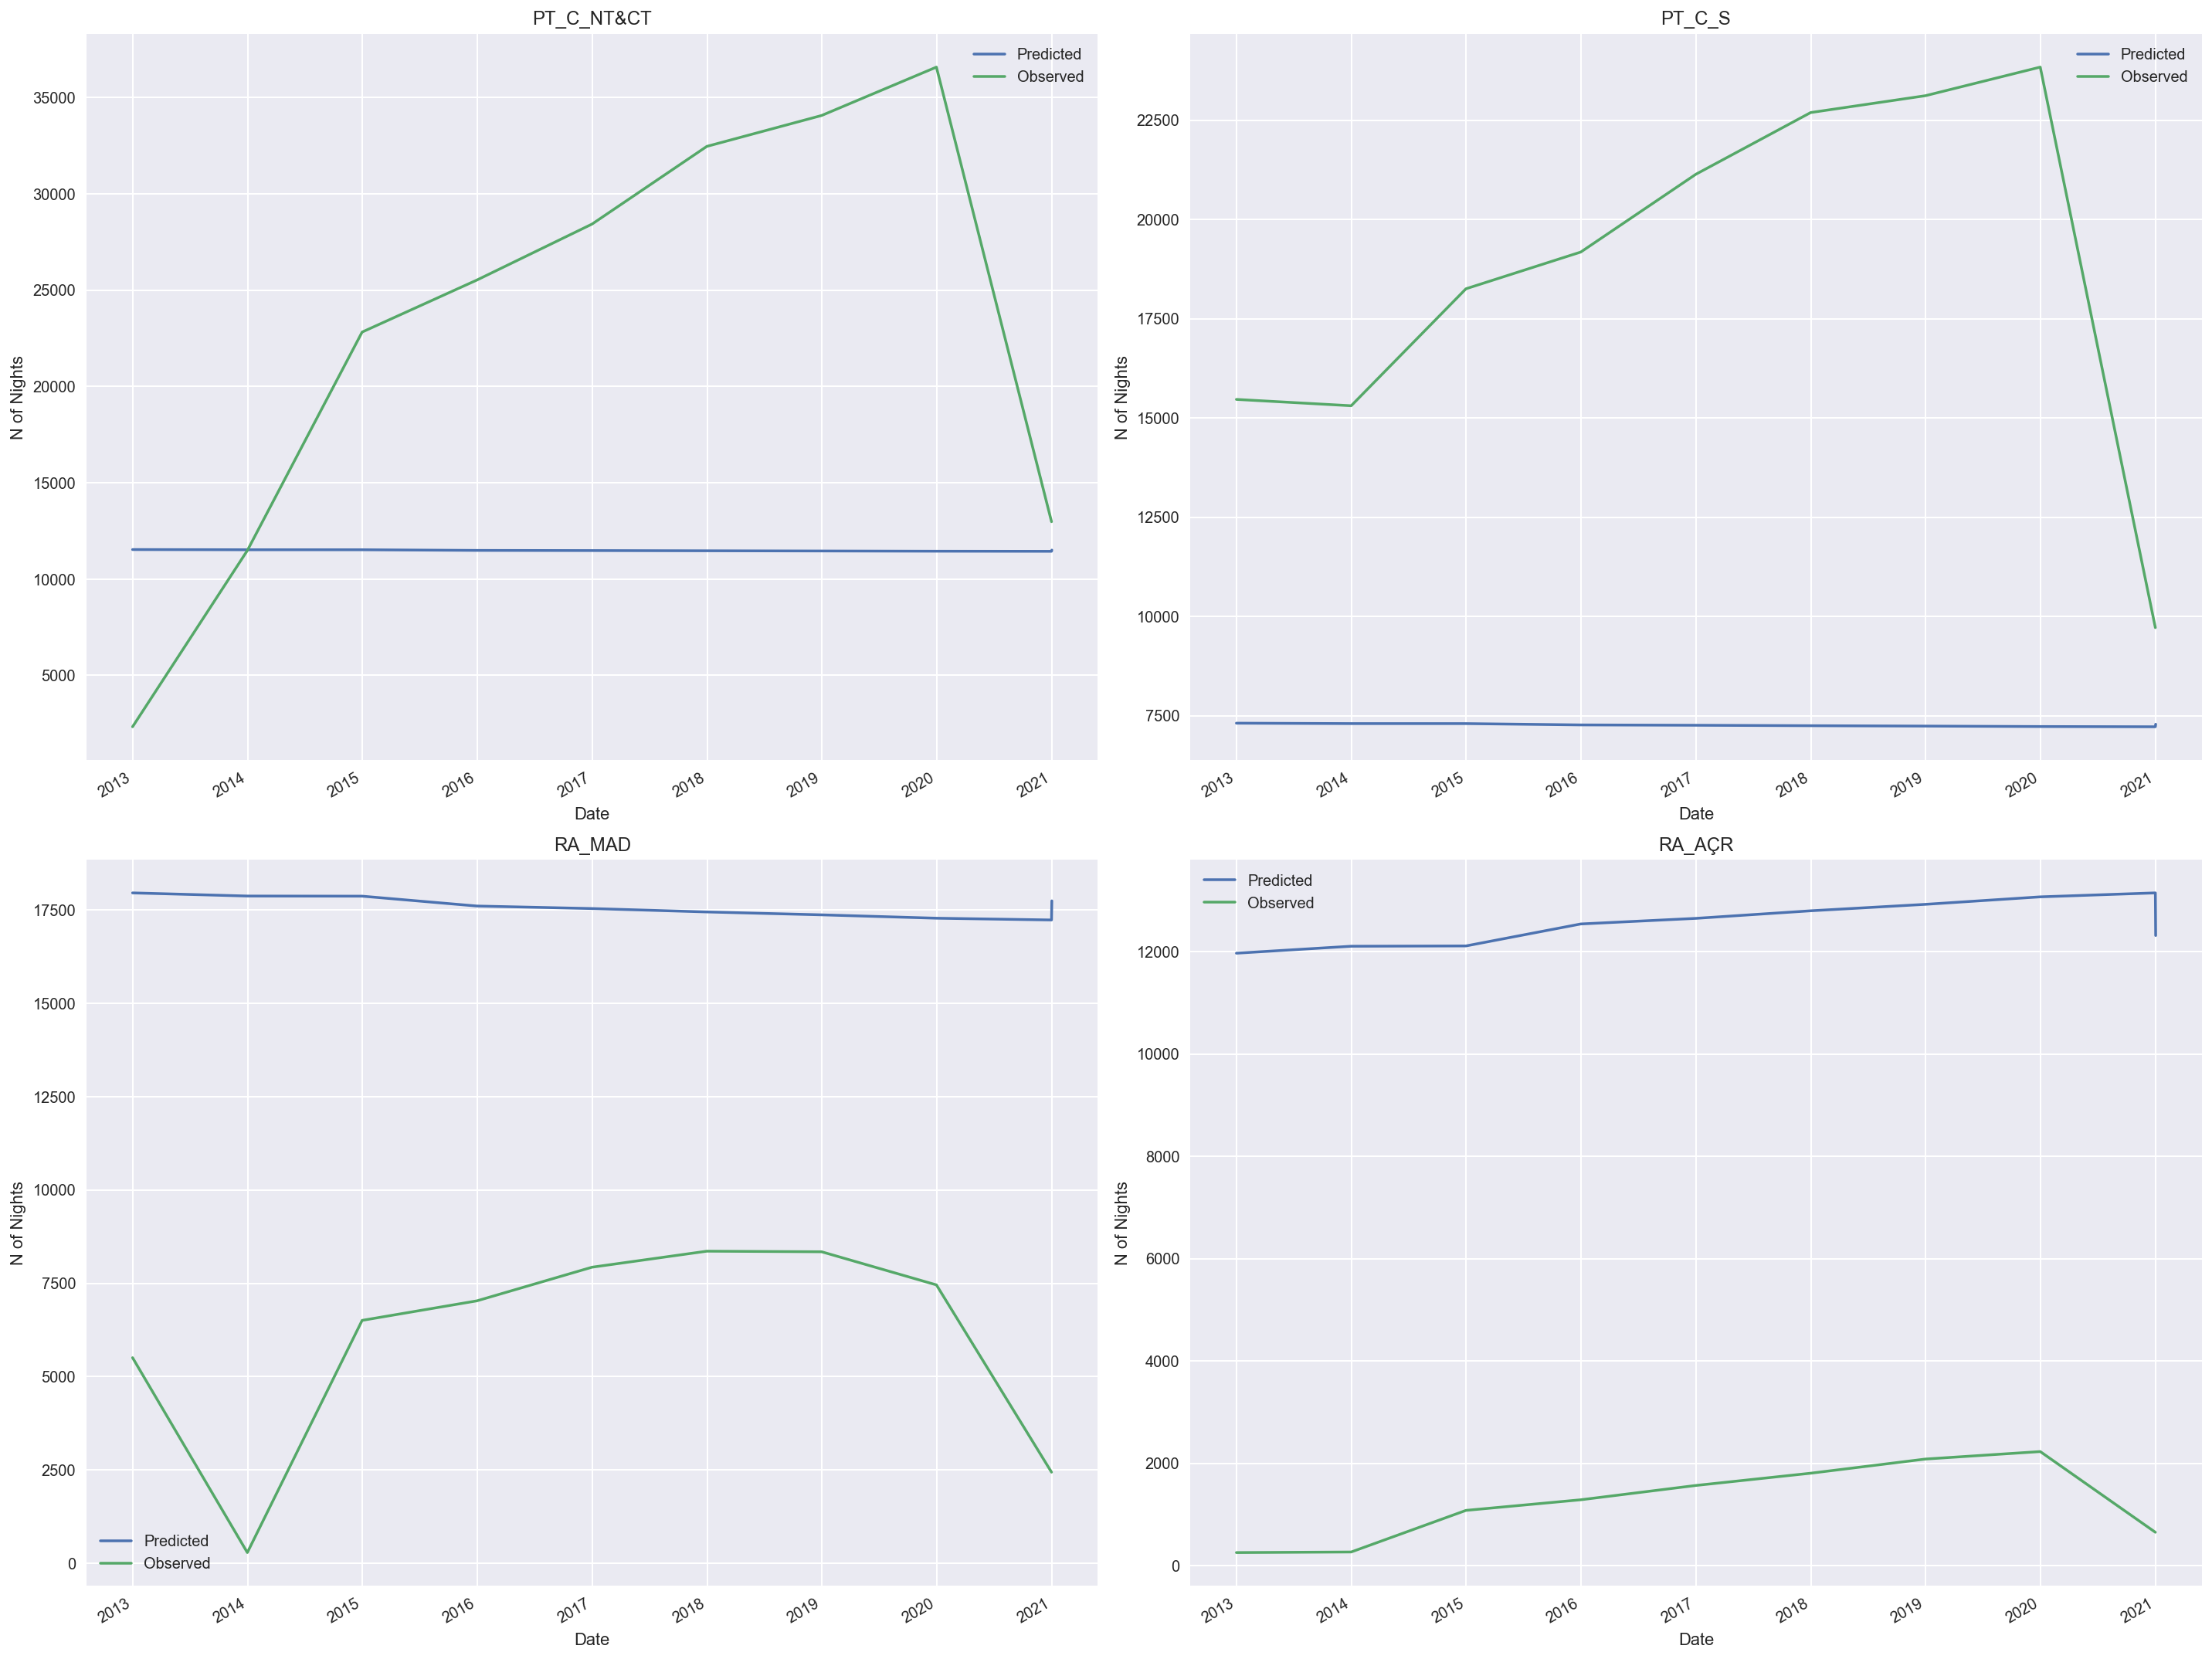

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_arima_ols)
plt.tight_layout()

## 1.4. WLSS approach

In [30]:
arima_wlss = hts.HTSRegressor(model='auto_arima', revision_method='WLSS', n_jobs=0)
arima_wlss = arima_wlss.fit(hierarchy_data, hierarchy)
pred_arima_wlss = arima_wlss.predict(steps_ahead=1)

Fitting models: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 330.64it/s]


In [31]:
pred_arima_wlss.round()

total     PT_C       RA  PT_C_NT&CT   PT_C_S   RA_MAD   RA_AÇR
2012-12-31  48535.0  23955.0  24580.0     14400.0  10179.0  14970.0   8985.0
2013-12-31  48608.0  24047.0  24561.0     14391.0  10170.0  14906.0   9141.0
2014-12-31  48611.0  24051.0  24561.0     14391.0  10170.0  14903.0   9147.0
2015-12-31  48842.0  24339.0  24503.0     14362.0  10141.0  14701.0   9639.0
2016-12-31  48901.0  24413.0  24488.0     14355.0  10133.0  14649.0   9764.0
2017-12-31  48981.0  24513.0  24468.0     14345.0  10123.0  14580.0   9933.0
2018-12-31  49049.0  24598.0  24451.0     14336.0  10115.0  14520.0  10077.0
2019-12-31  49127.0  24696.0  24431.0     14326.0  10105.0  14451.0  10245.0
2020-12-31  49169.0  24748.0  24421.0     14321.0  10100.0  14415.0  10333.0
2021-01-01  48721.0  24187.0  24533.0     14377.0  10156.0  14807.0   9380.0

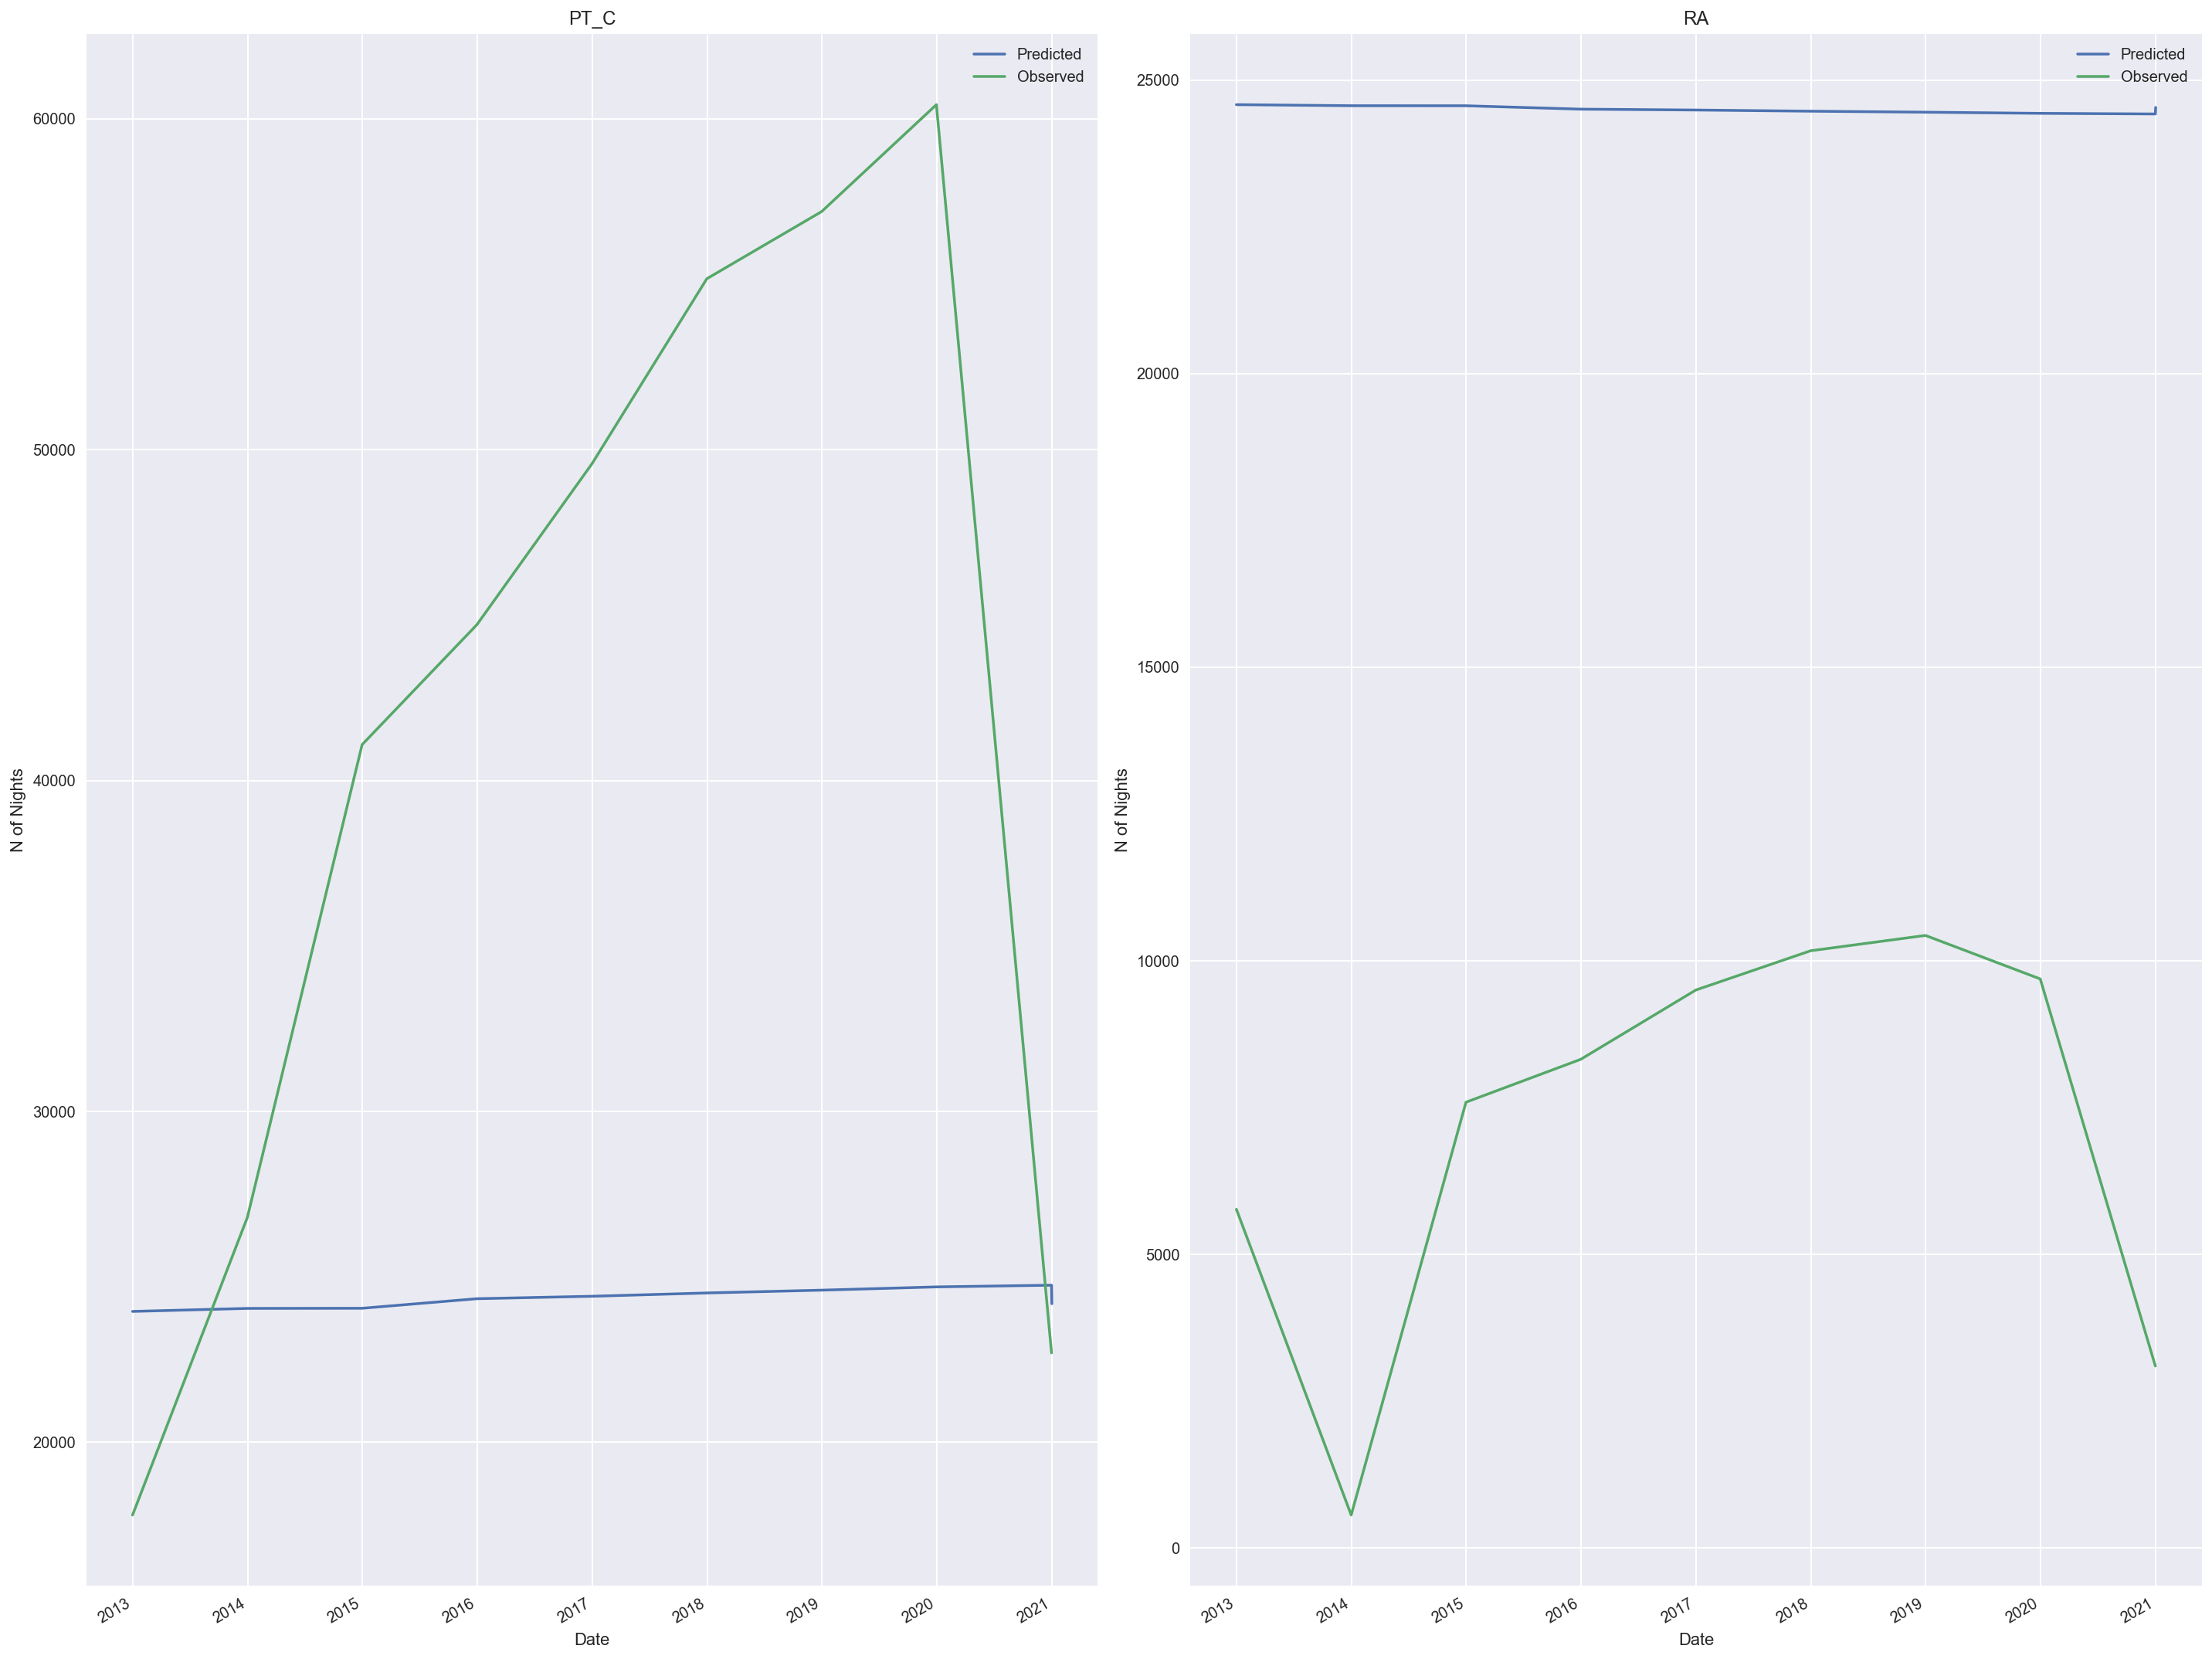

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
plot_results(nutsi, axes, pred_arima_wlss)
plt.tight_layout()

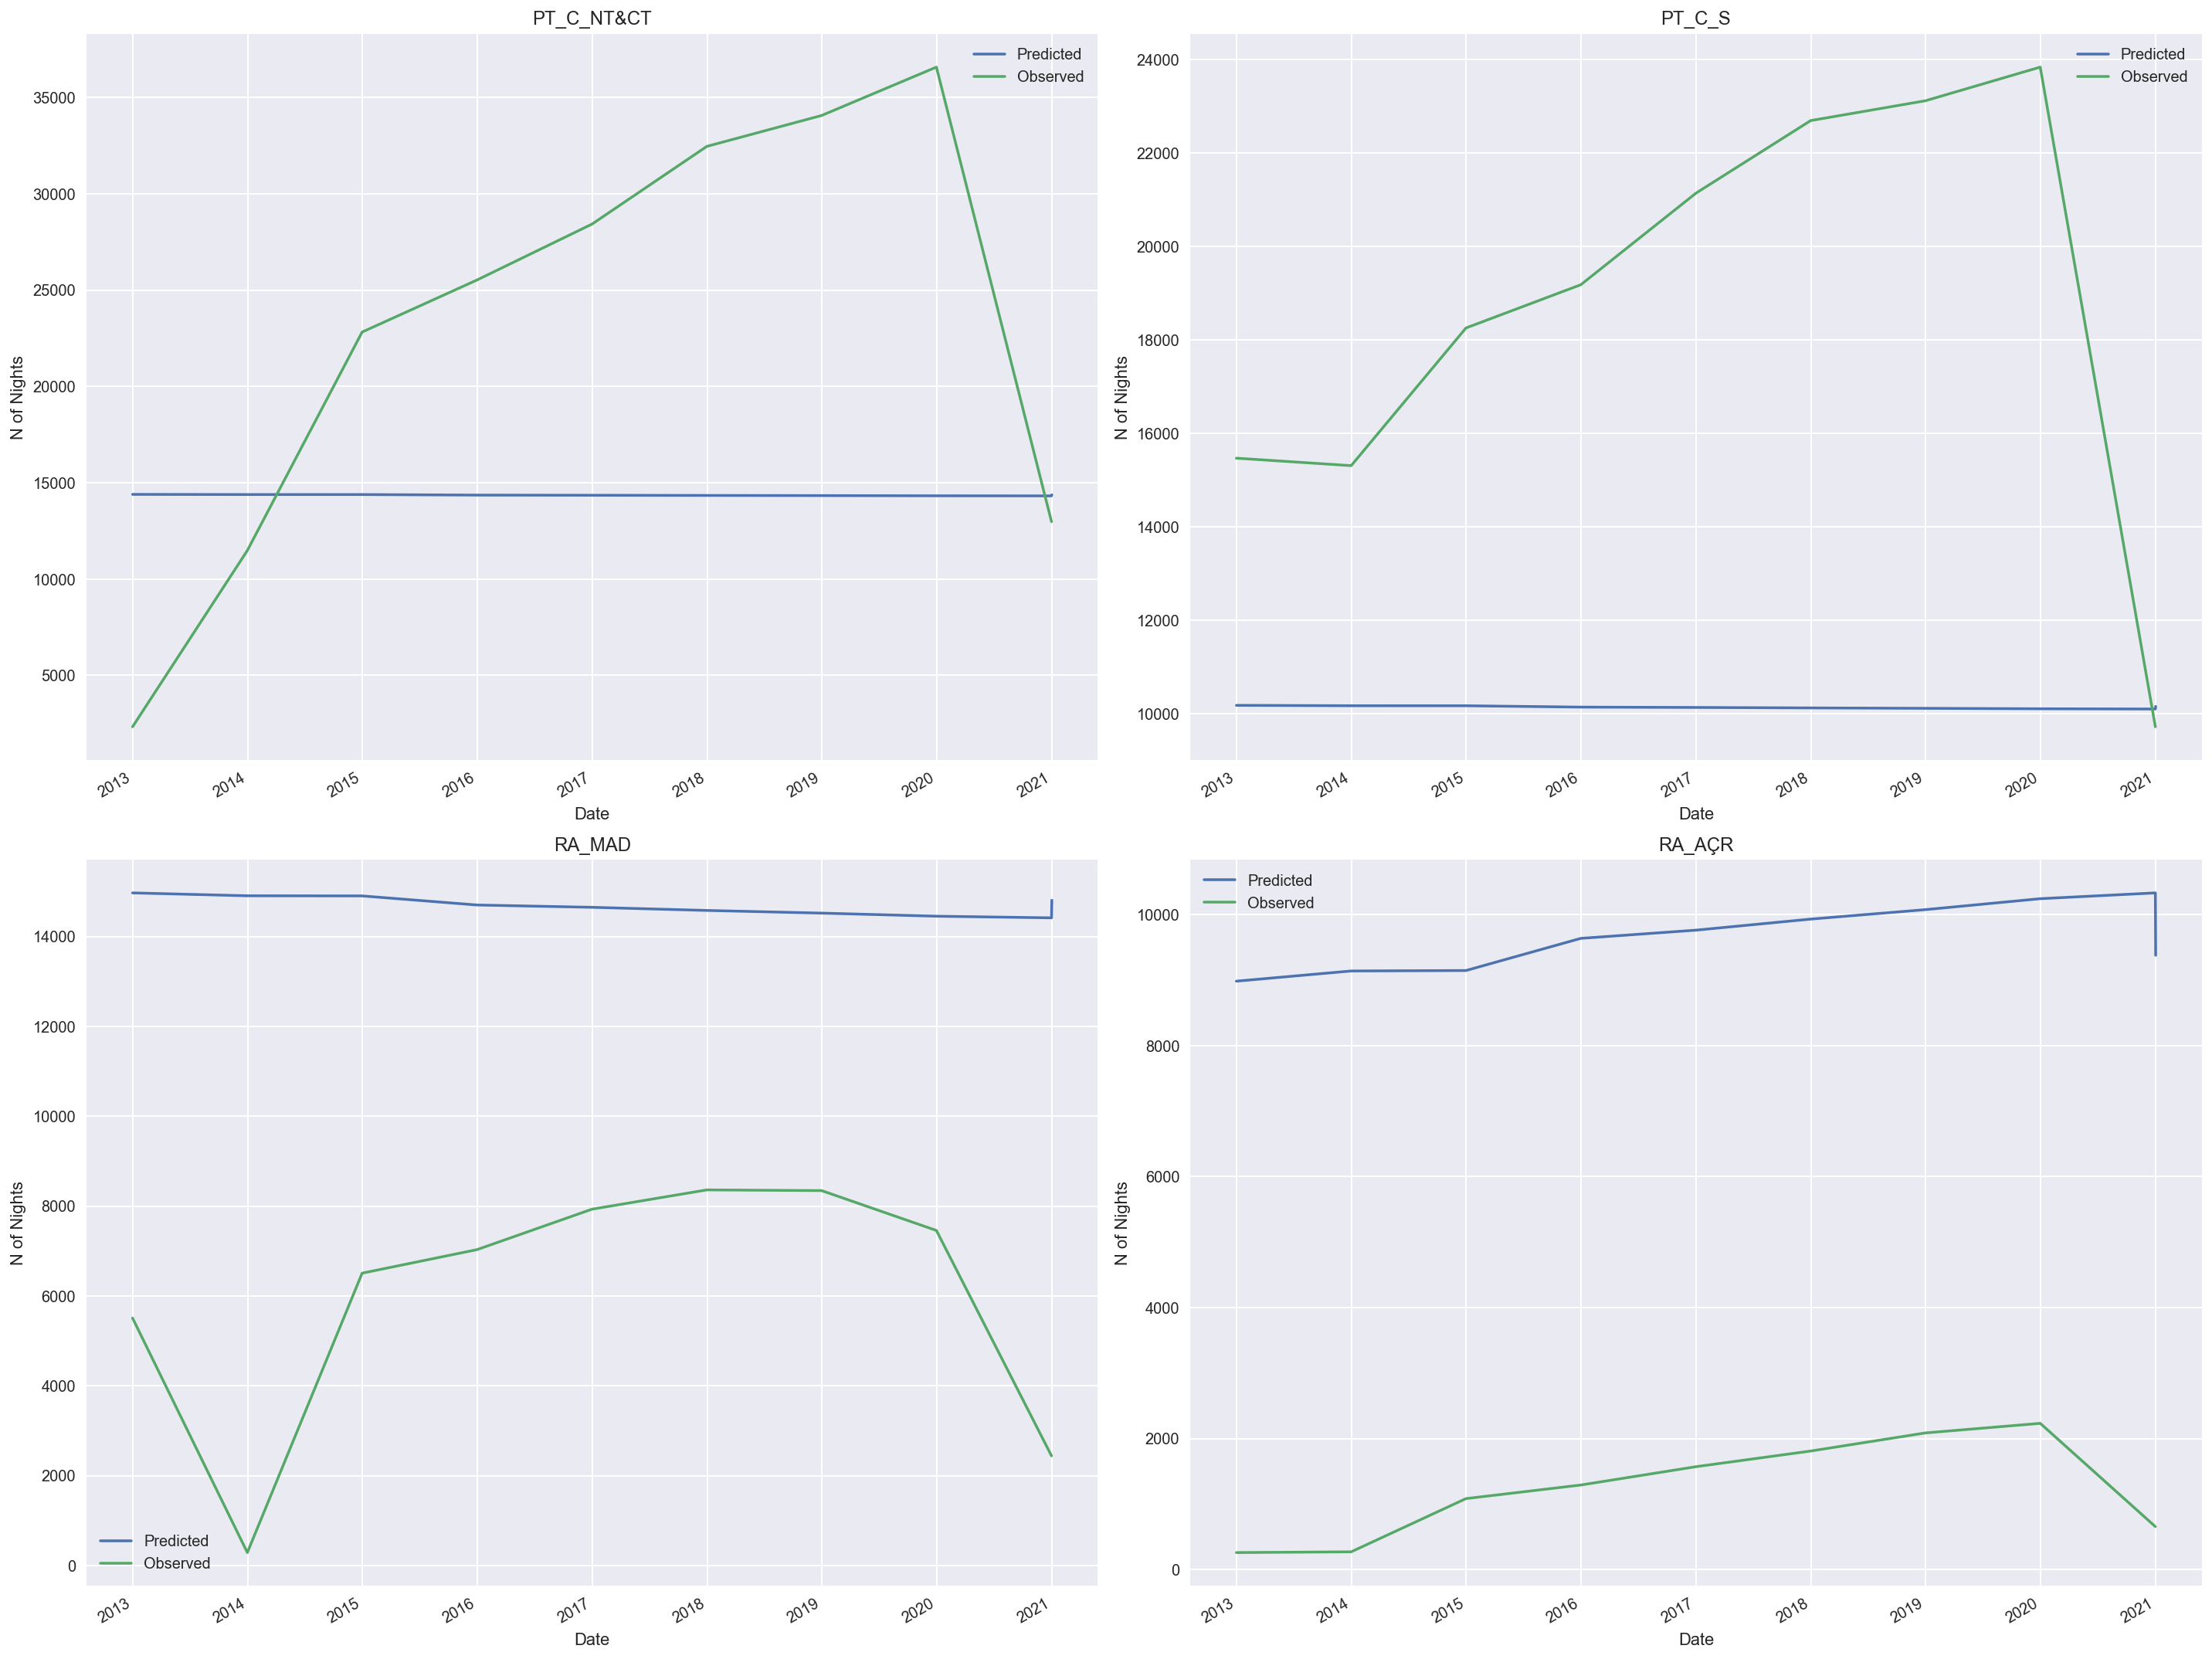

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_arima_wlss)
plt.tight_layout()

## 1.5. WLSv approach

In [34]:
arima_wlsv = hts.HTSRegressor(model='auto_arima', revision_method='WLSV', n_jobs=0)
arima_wlsv = arima_wlss.fit(hierarchy_data, hierarchy)
pred_arima_wlsv = arima_wlss.predict(steps_ahead=1)

Fitting models: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 314.70it/s]


In [35]:
pred_arima_wlsv.round()

total     PT_C       RA  PT_C_NT&CT   PT_C_S   RA_MAD   RA_AÇR
2012-12-31  48535.0  23955.0  24580.0     14400.0  10179.0  14970.0   8985.0
2013-12-31  48608.0  24047.0  24561.0     14391.0  10170.0  14906.0   9141.0
2014-12-31  48611.0  24051.0  24561.0     14391.0  10170.0  14903.0   9147.0
2015-12-31  48842.0  24339.0  24503.0     14362.0  10141.0  14701.0   9639.0
2016-12-31  48901.0  24413.0  24488.0     14355.0  10133.0  14649.0   9764.0
2017-12-31  48981.0  24513.0  24468.0     14345.0  10123.0  14580.0   9933.0
2018-12-31  49049.0  24598.0  24451.0     14336.0  10115.0  14520.0  10077.0
2019-12-31  49127.0  24696.0  24431.0     14326.0  10105.0  14451.0  10245.0
2020-12-31  49169.0  24748.0  24421.0     14321.0  10100.0  14415.0  10333.0
2021-01-01  48721.0  24187.0  24533.0     14377.0  10156.0  14807.0   9380.0

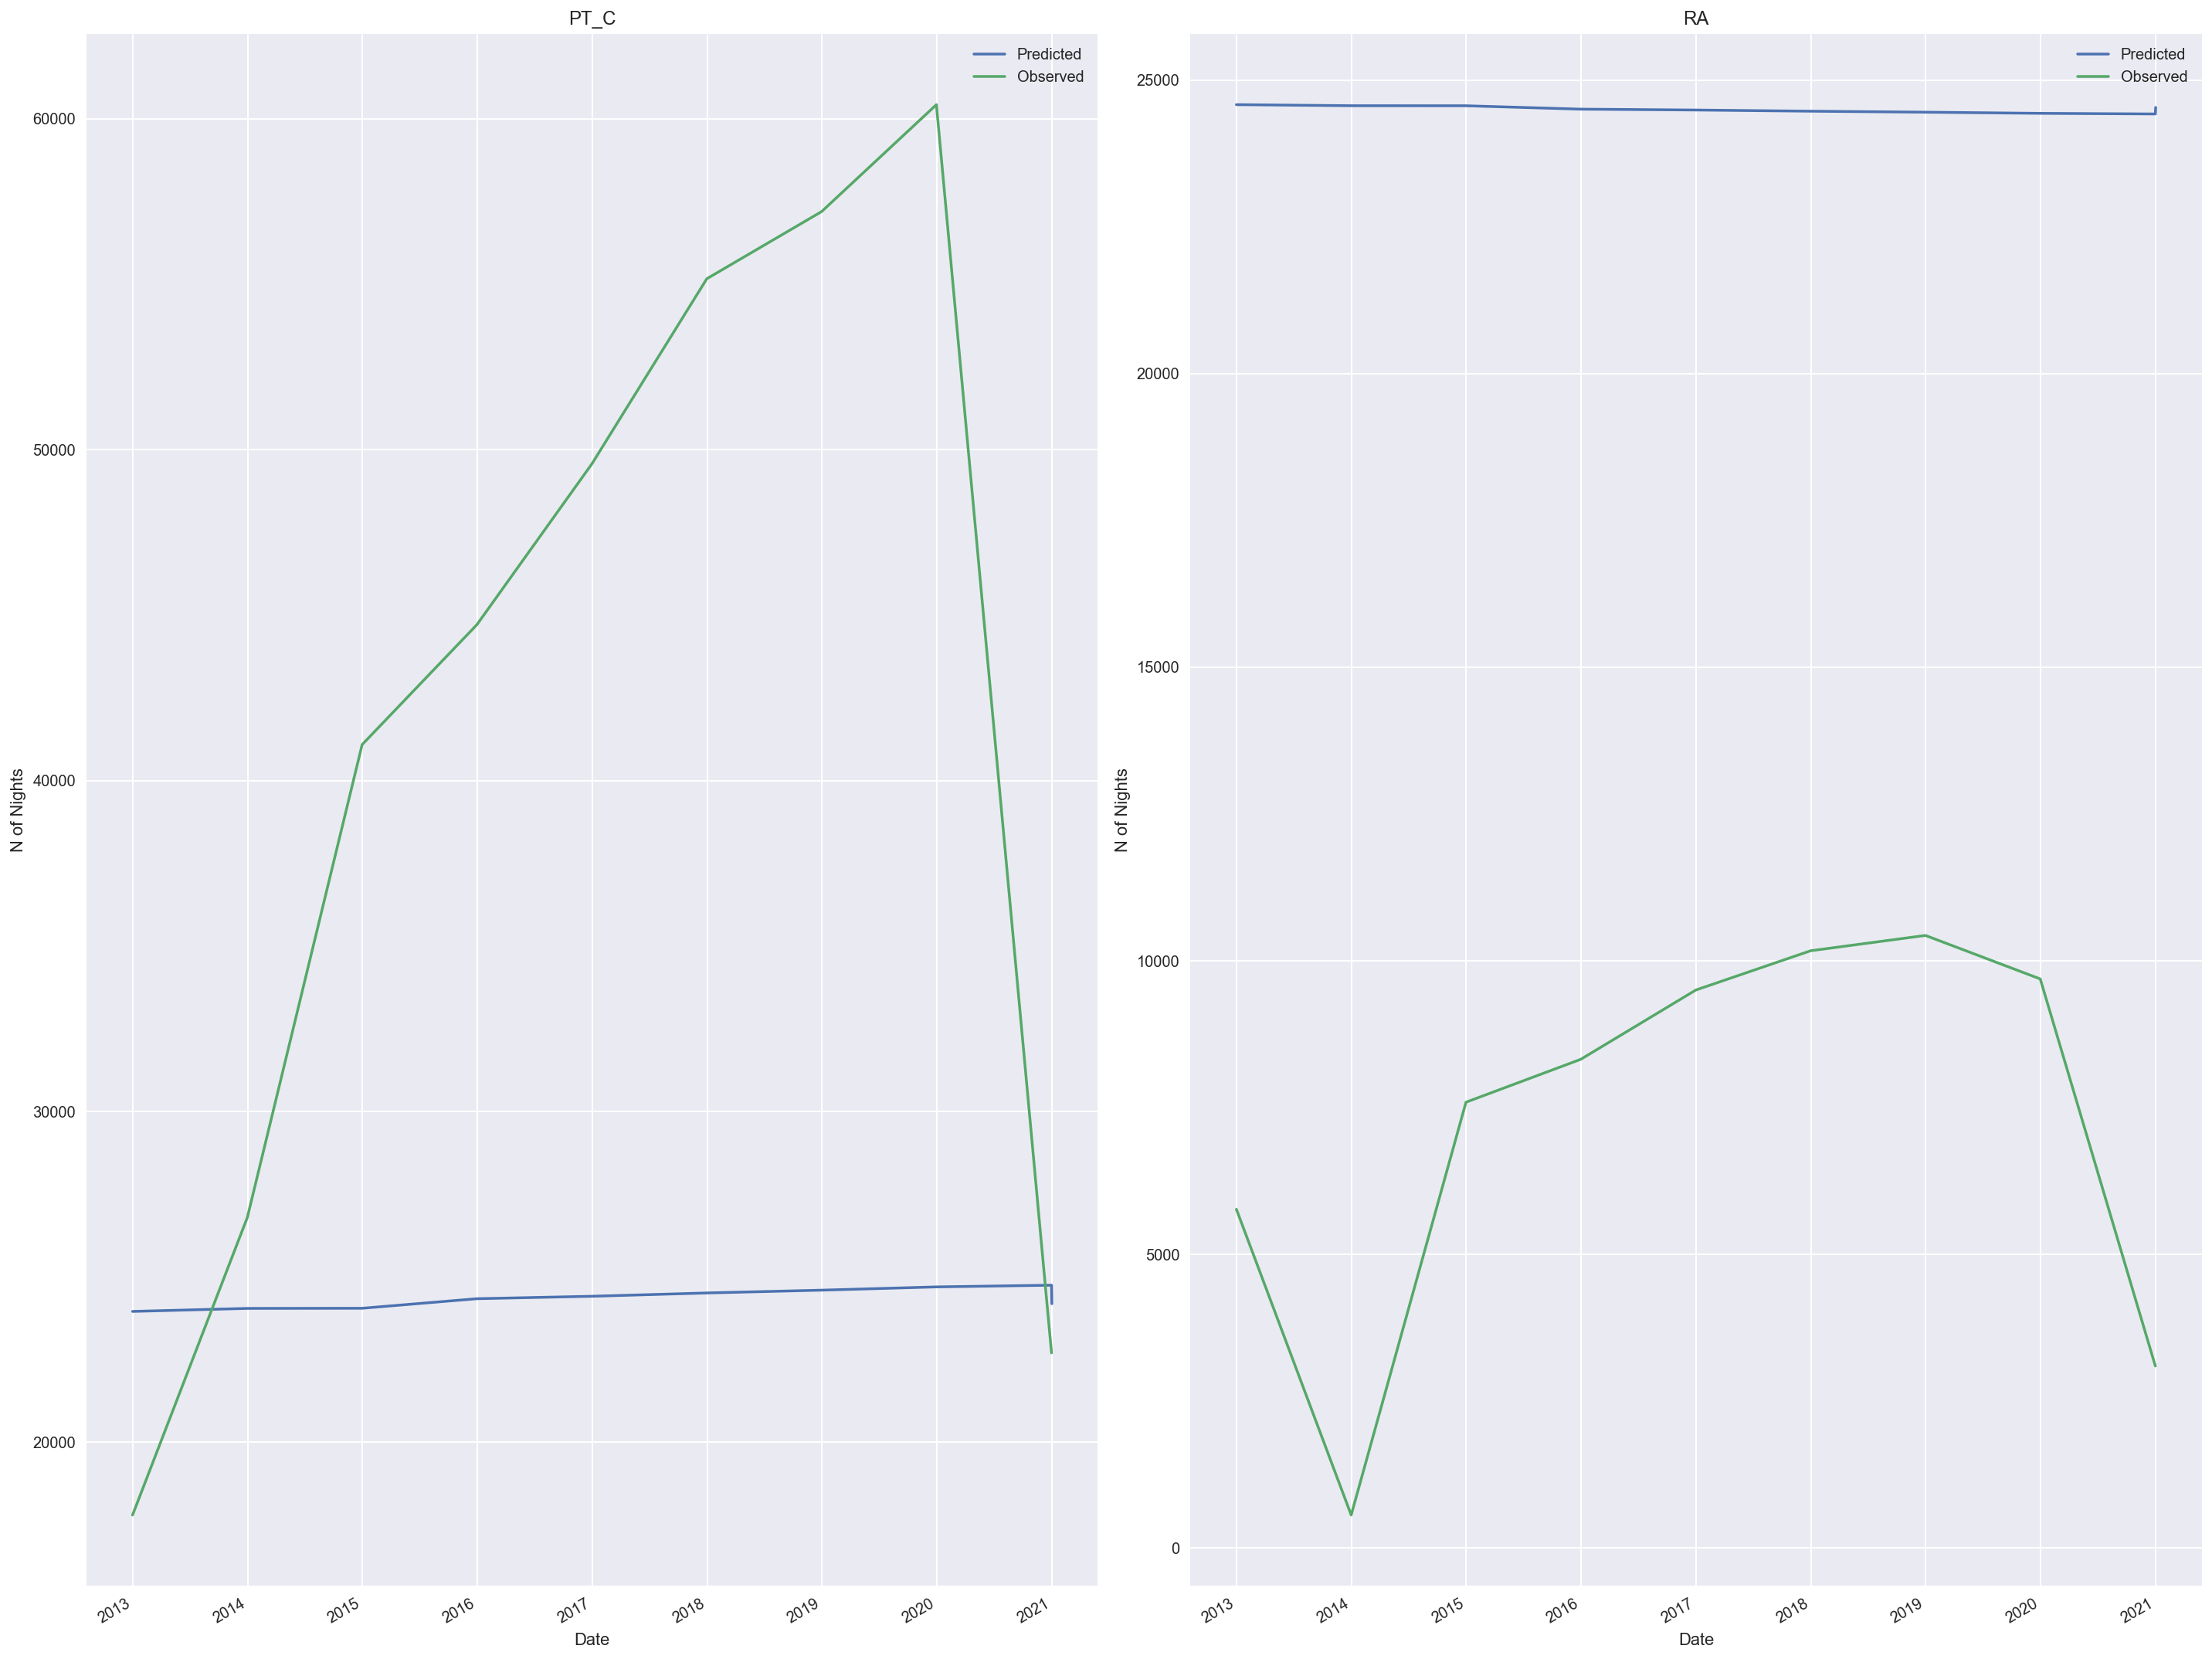

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
plot_results(nutsi, axes, pred_arima_wlsv)
plt.tight_layout()

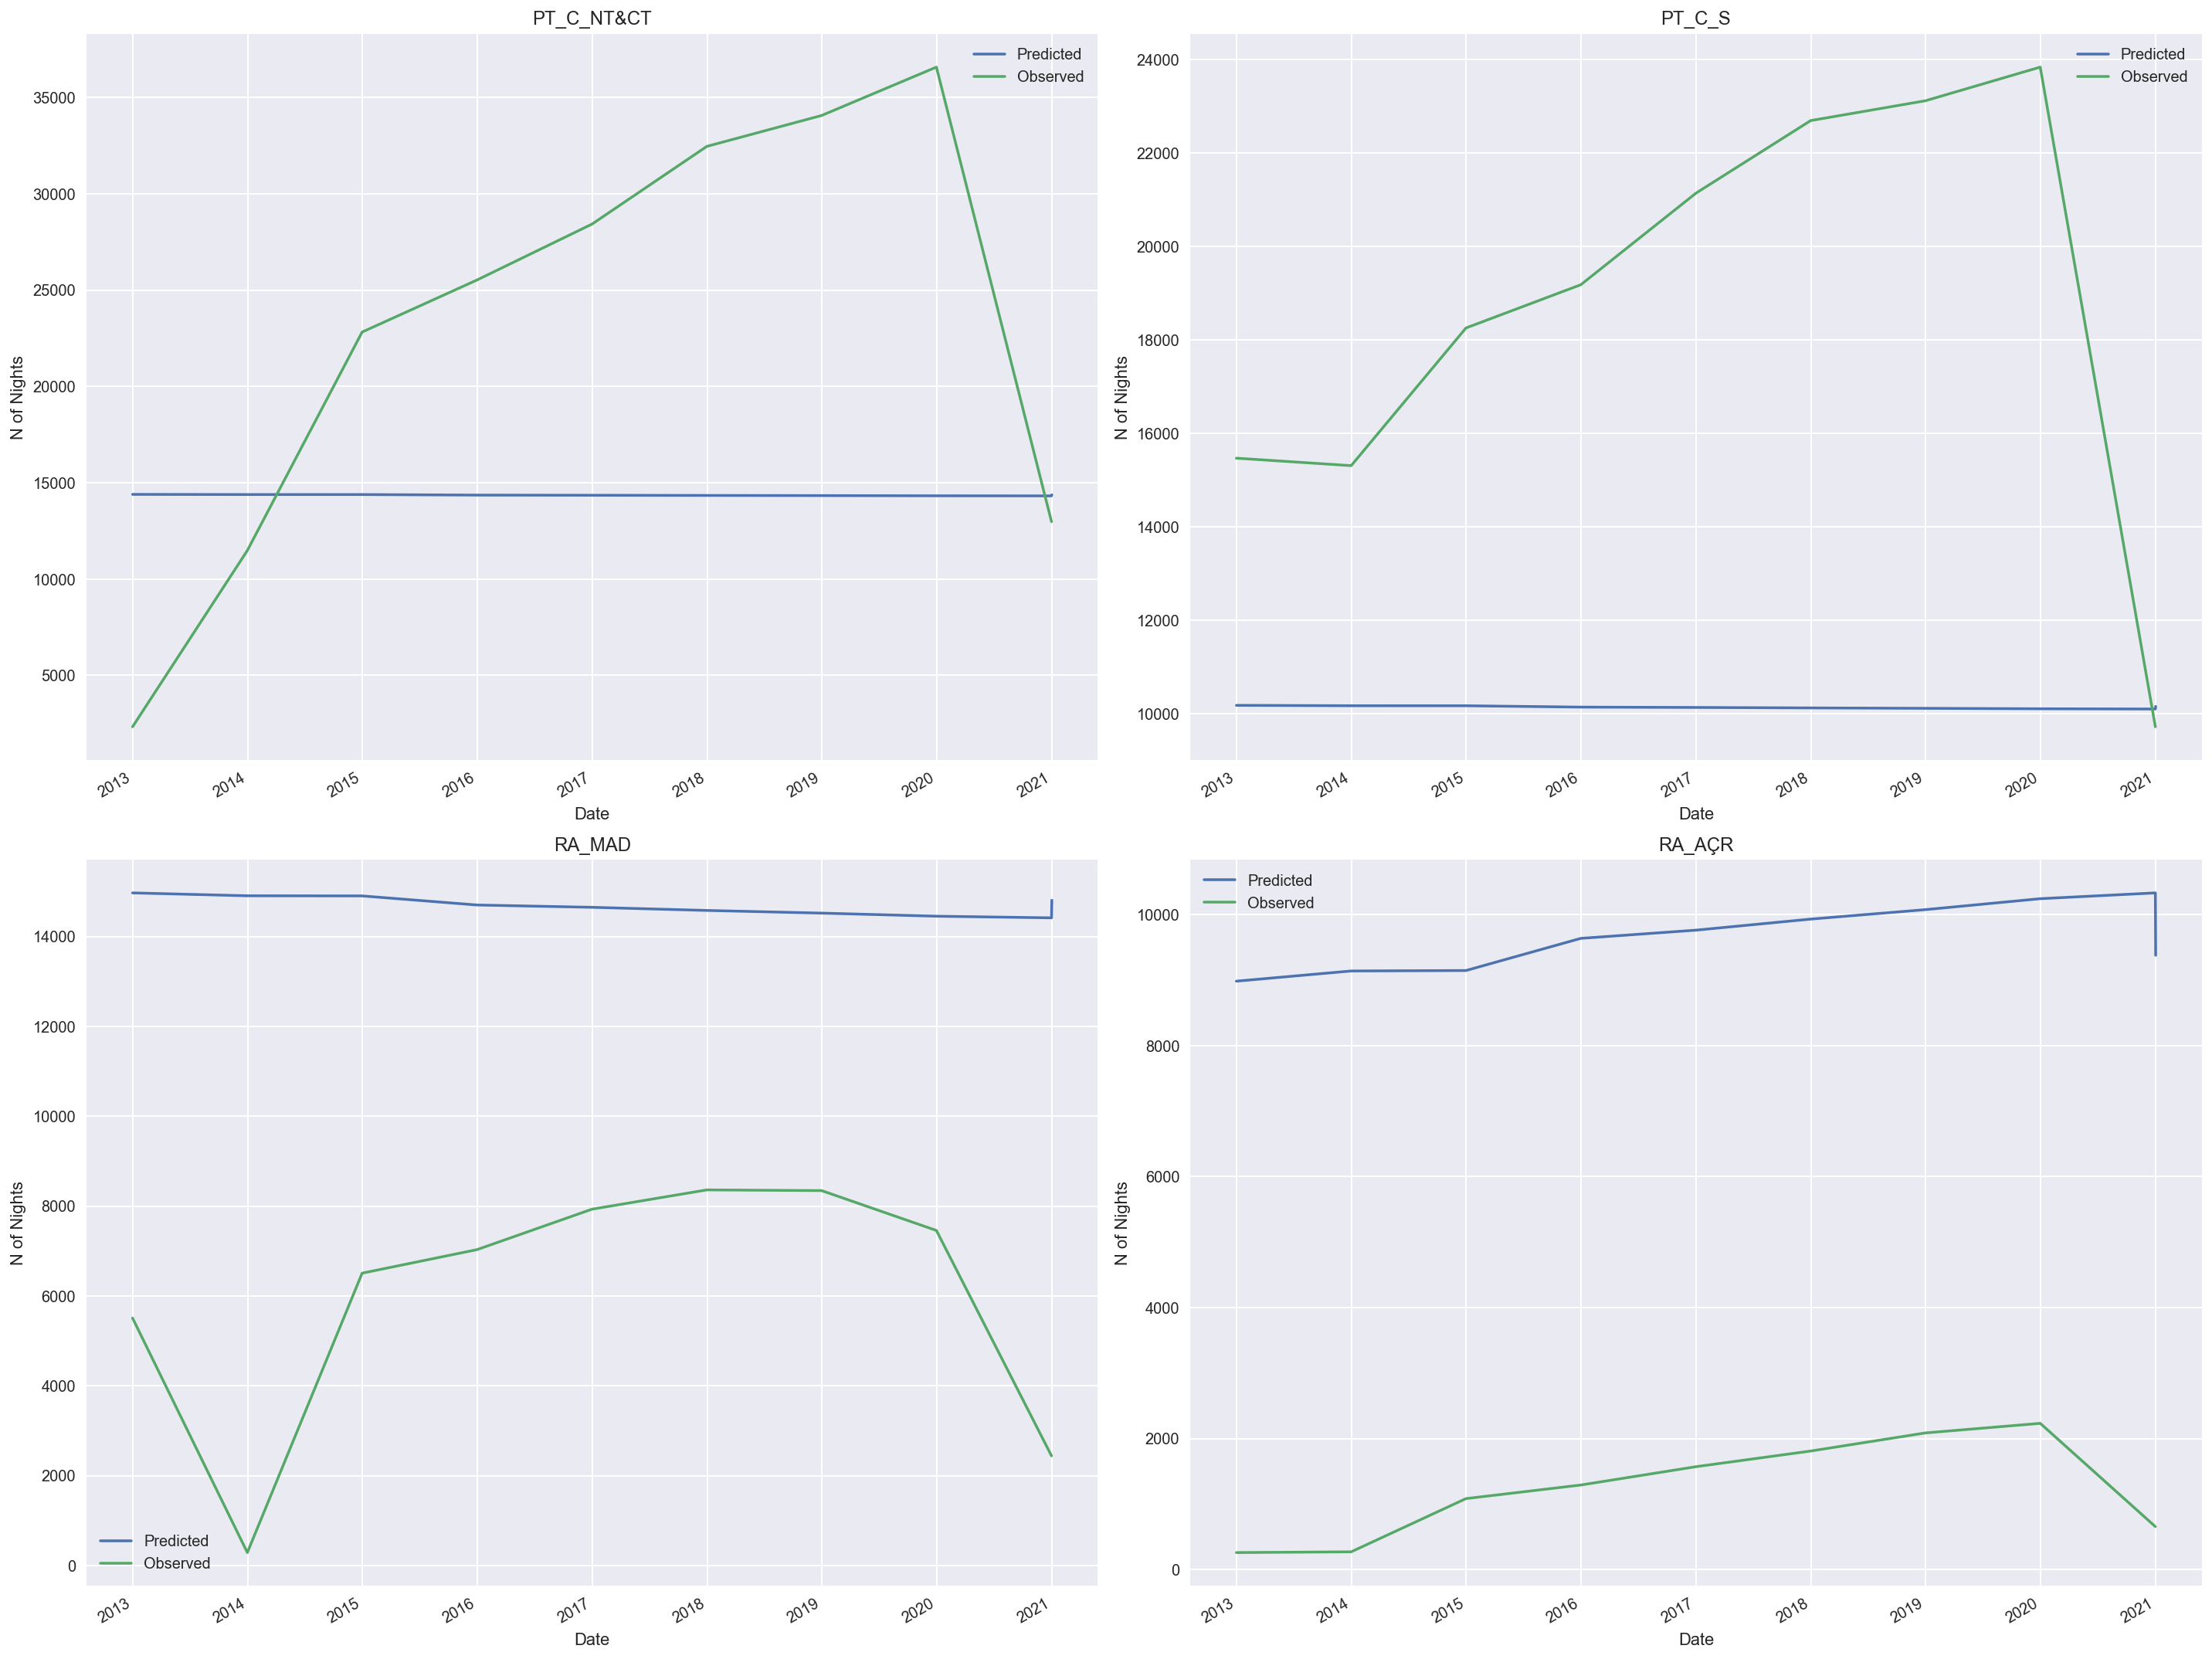

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_arima_wlsv)
plt.tight_layout()

## 2. Using Prophet as base forecast

## 2.1. Bottom-up approach

In [38]:
prophet_bu = hts.HTSRegressor(model='prophet', revision_method='BU', n_jobs=0)
prophet_bu = prophet_bu.fit(hierarchy_data, hierarchy)
pred_prophet_bu = prophet_bu.predict(steps_ahead=1)

Fitting models:   0%|                                                                            | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  14%|█████████▋                                                          | 1/7 [00:01<00:06,  1.01s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  29%|███████████████████▍                                                | 2/7 [00:01<00:02,  2.09it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonalit

In [60]:
pred_prophet_bu.round()

total    PT_C       RA  PT_C_NT&CT   PT_C_S  RA_MAD  RA_AÇR
2012-12-31  27809.0  4507.0  23301.0      7796.0  15506.0  4223.0   284.0
2013-12-31  38608.0  5891.0  32717.0     15001.0  17716.0  5173.0   718.0
2014-12-31  49232.0  7271.0  41961.0     22098.0  19863.0  6123.0  1148.0
2015-12-31  59670.0  8646.0  51024.0     29081.0  21944.0  7071.0  1575.0
2016-12-31  38179.0  5845.0  32334.0     16292.0  16043.0  4967.0   878.0
2017-12-31  48979.0  7229.0  41750.0     23497.0  18253.0  5917.0  1311.0
2018-12-31  59602.0  8609.0  50994.0     30594.0  20399.0  6867.0  1742.0
2019-12-31  70040.0  9983.0  60057.0     37577.0  22481.0  7815.0  2169.0
2020-12-31  48550.0  7182.0  41367.0     24788.0  16579.0  5711.0  1471.0
2021-01-01  14169.0  2970.0  11199.0      3503.0   7696.0  2667.0   303.0

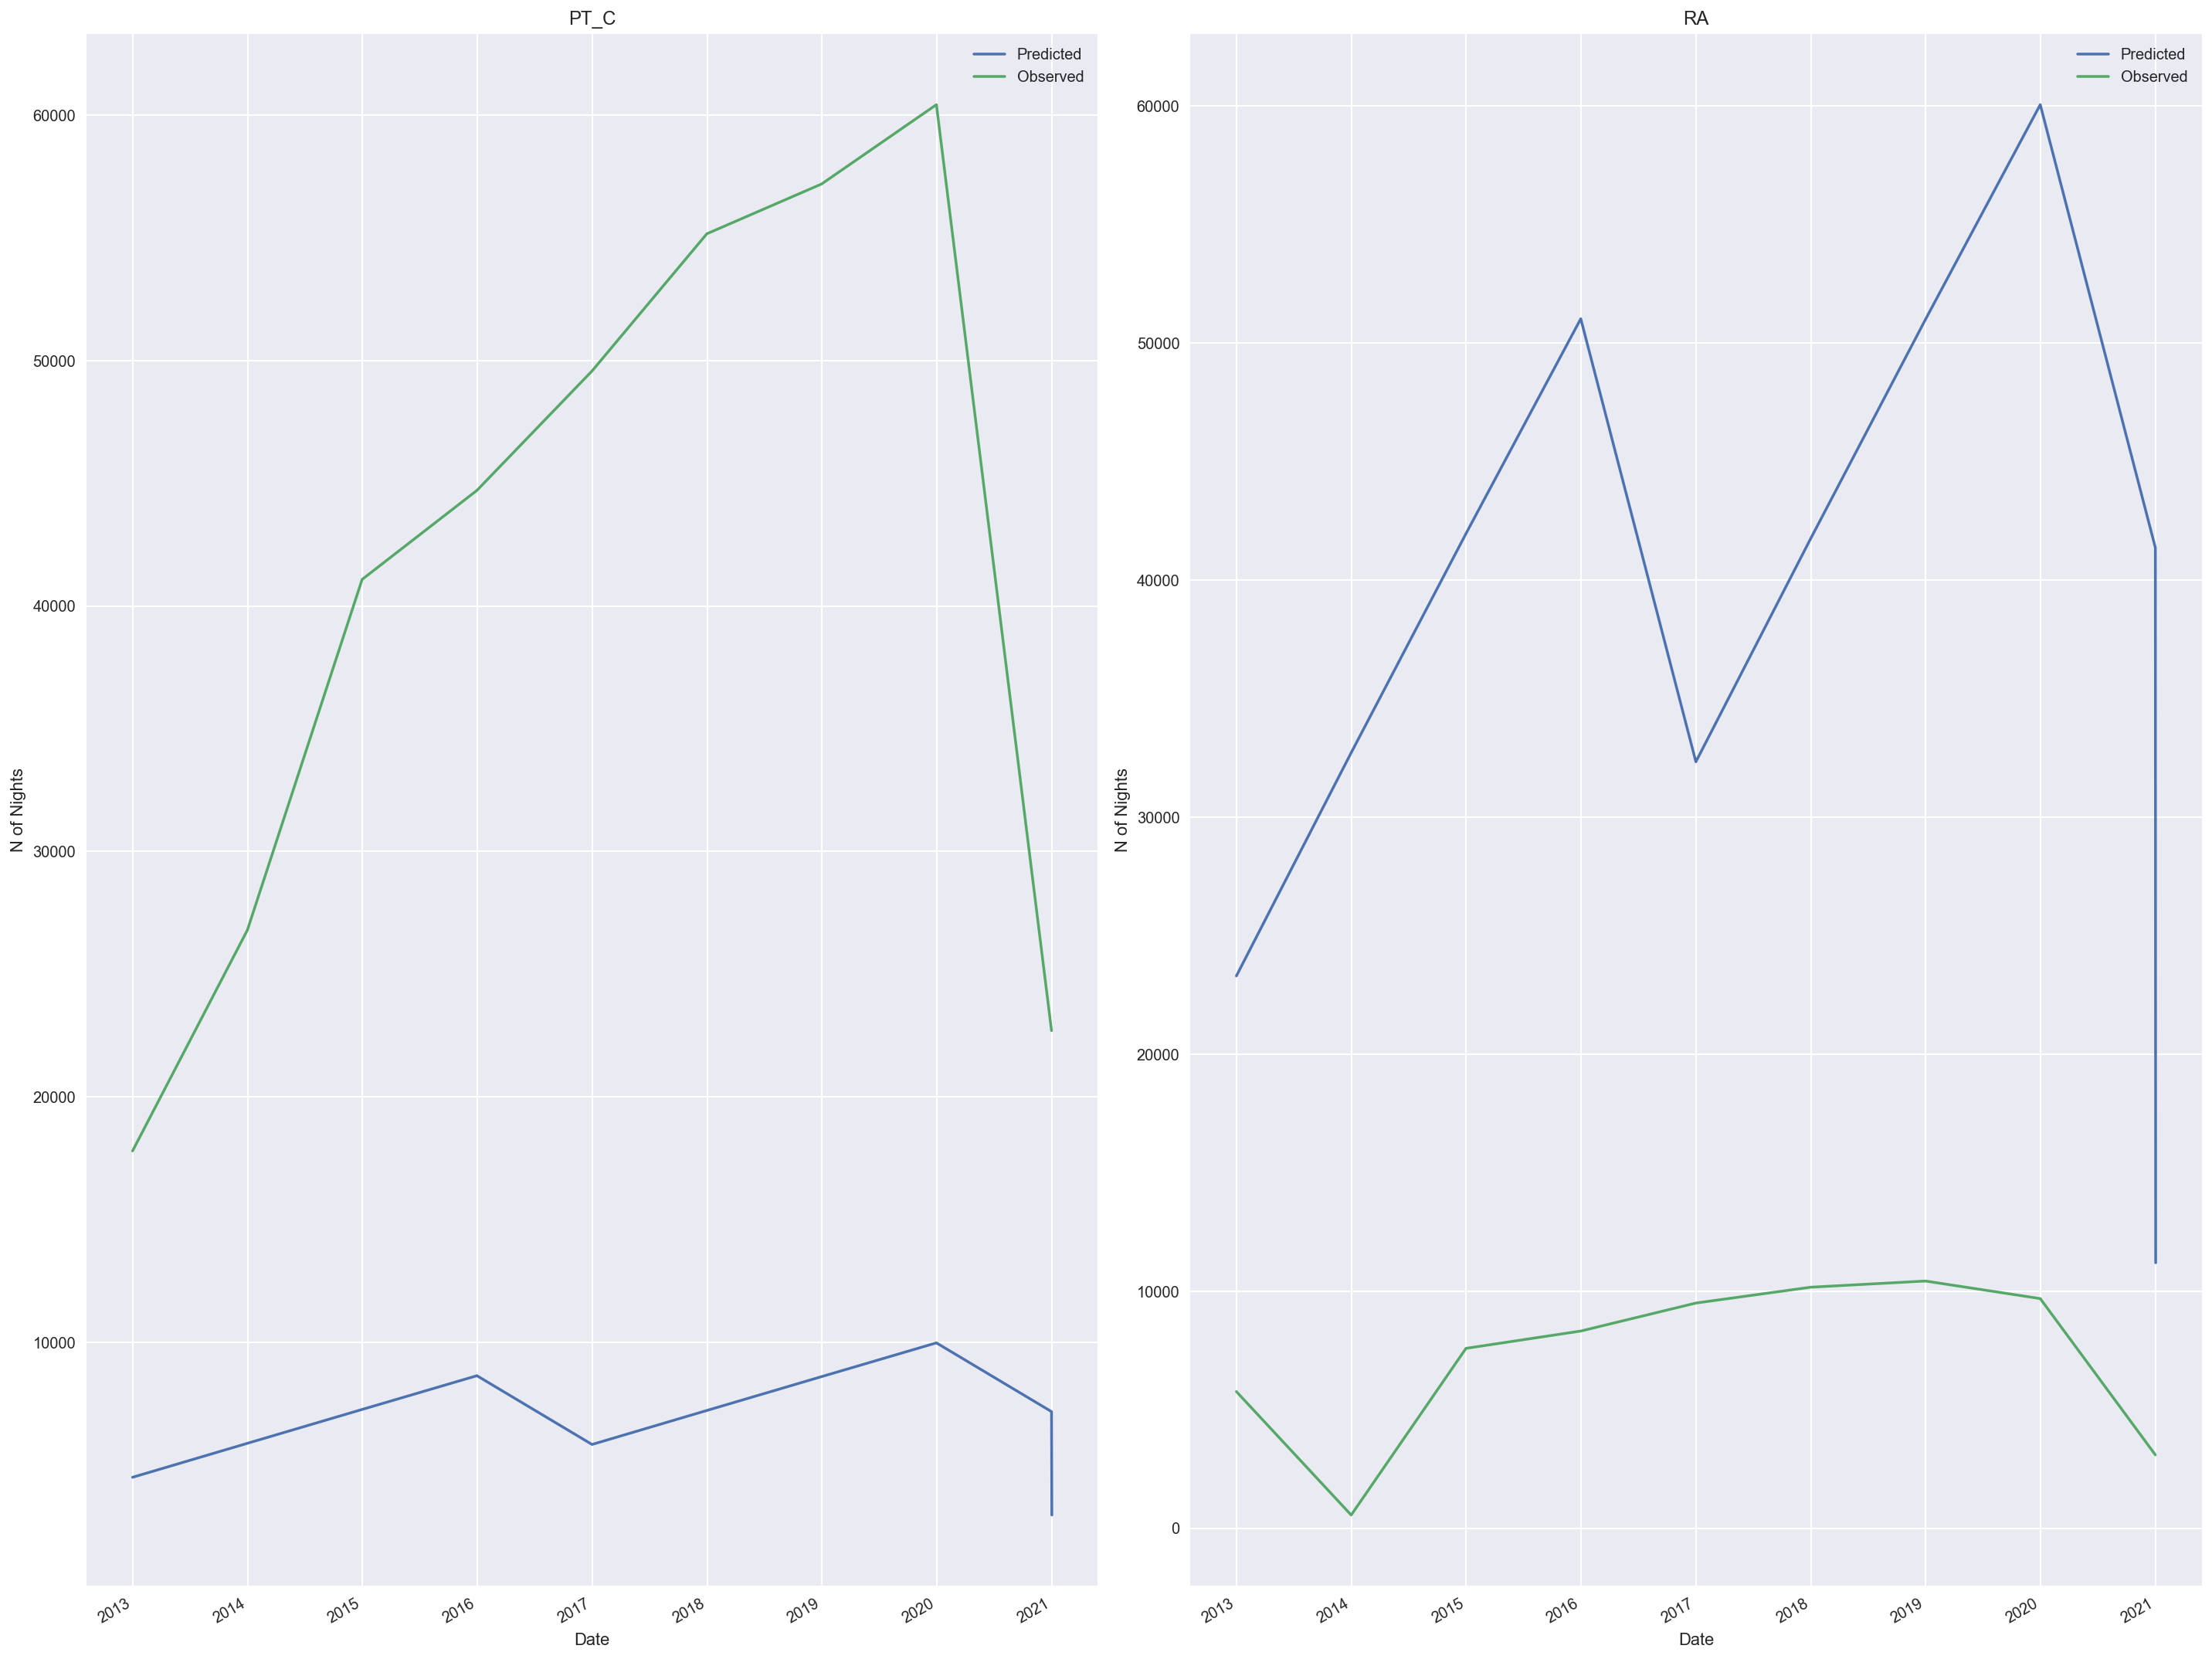

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
plot_results(nutsi, axes, pred_prophet_bu)
plt.tight_layout()

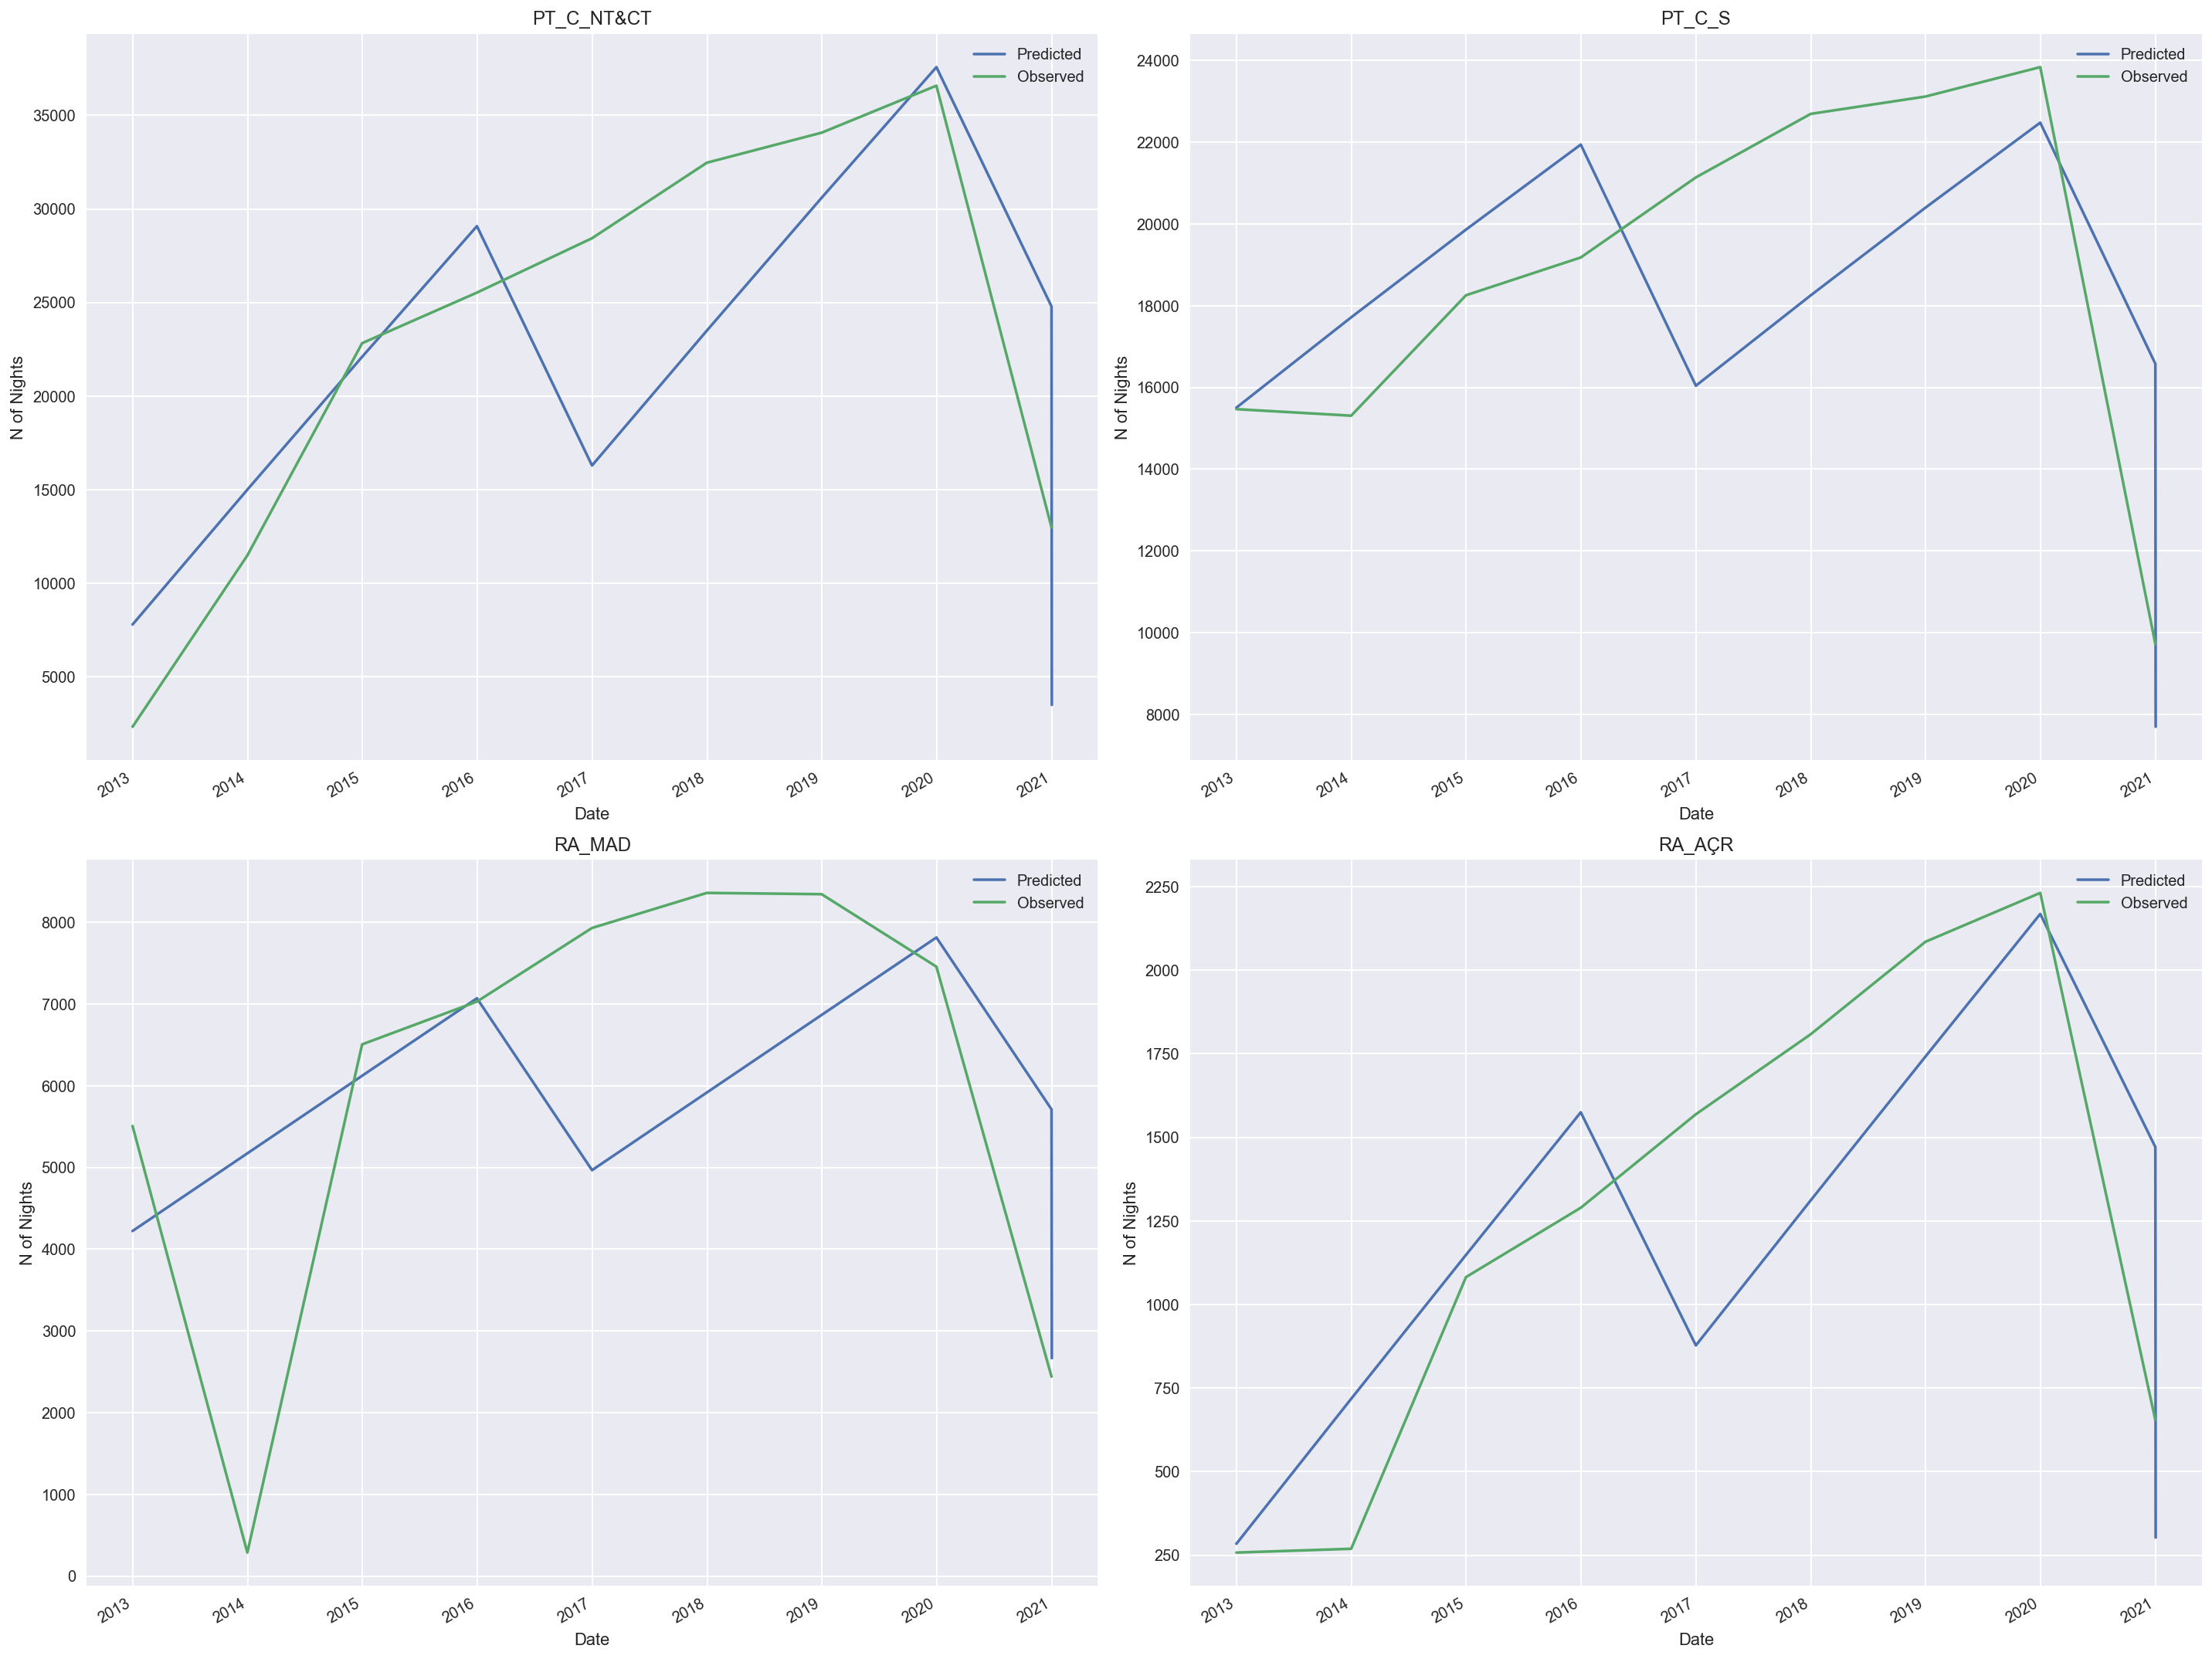

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_prophet_bu)
plt.tight_layout()

## 2.2. Top-down approach

In [42]:
prophet_td = hts.HTSRegressor(model='prophet', revision_method='AHP', n_jobs=0)
prophet_td = prophet_td.fit(hierarchy_data, hierarchy)
pred_prophet_td = prophet_td.predict(steps_ahead=1)

Fitting models:   0%|                                                                            | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  14%|█████████▋                                                          | 1/7 [00:00<00:00,  8.94it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  29%|███████████████████▍                                                | 2/7 [00:00<00:00,  9.45it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonalit

In [43]:
pred_prophet_td.round()

total     PT_C       RA  PT_C_NT&CT   PT_C_S  RA_MAD  RA_AÇR
2012-12-31  27804.0   4037.0  23767.0     12285.0  11482.0  3389.0   648.0
2013-12-31  38599.0   5604.0  32995.0     17055.0  15940.0  4705.0   899.0
2014-12-31  49228.0   7147.0  42081.0     21751.0  20330.0  6001.0  1146.0
2015-12-31  59682.0   8665.0  51017.0     26370.0  24647.0  7275.0  1390.0
2016-12-31  38160.0   5541.0  32620.0     16861.0  15759.0  4652.0   889.0
2017-12-31  48955.0   7108.0  41847.0     21630.0  20217.0  5968.0  1140.0
2018-12-31  59584.0   8651.0  50933.0     26327.0  24607.0  7263.0  1388.0
2019-12-31  70038.0  10169.0  59869.0     30946.0  28924.0  8538.0  1631.0
2020-12-31  48517.0   7044.0  41473.0     21437.0  20036.0  5914.0  1130.0
2021-01-01  14243.0   2068.0  12175.0      6293.0   5882.0  1736.0   332.0

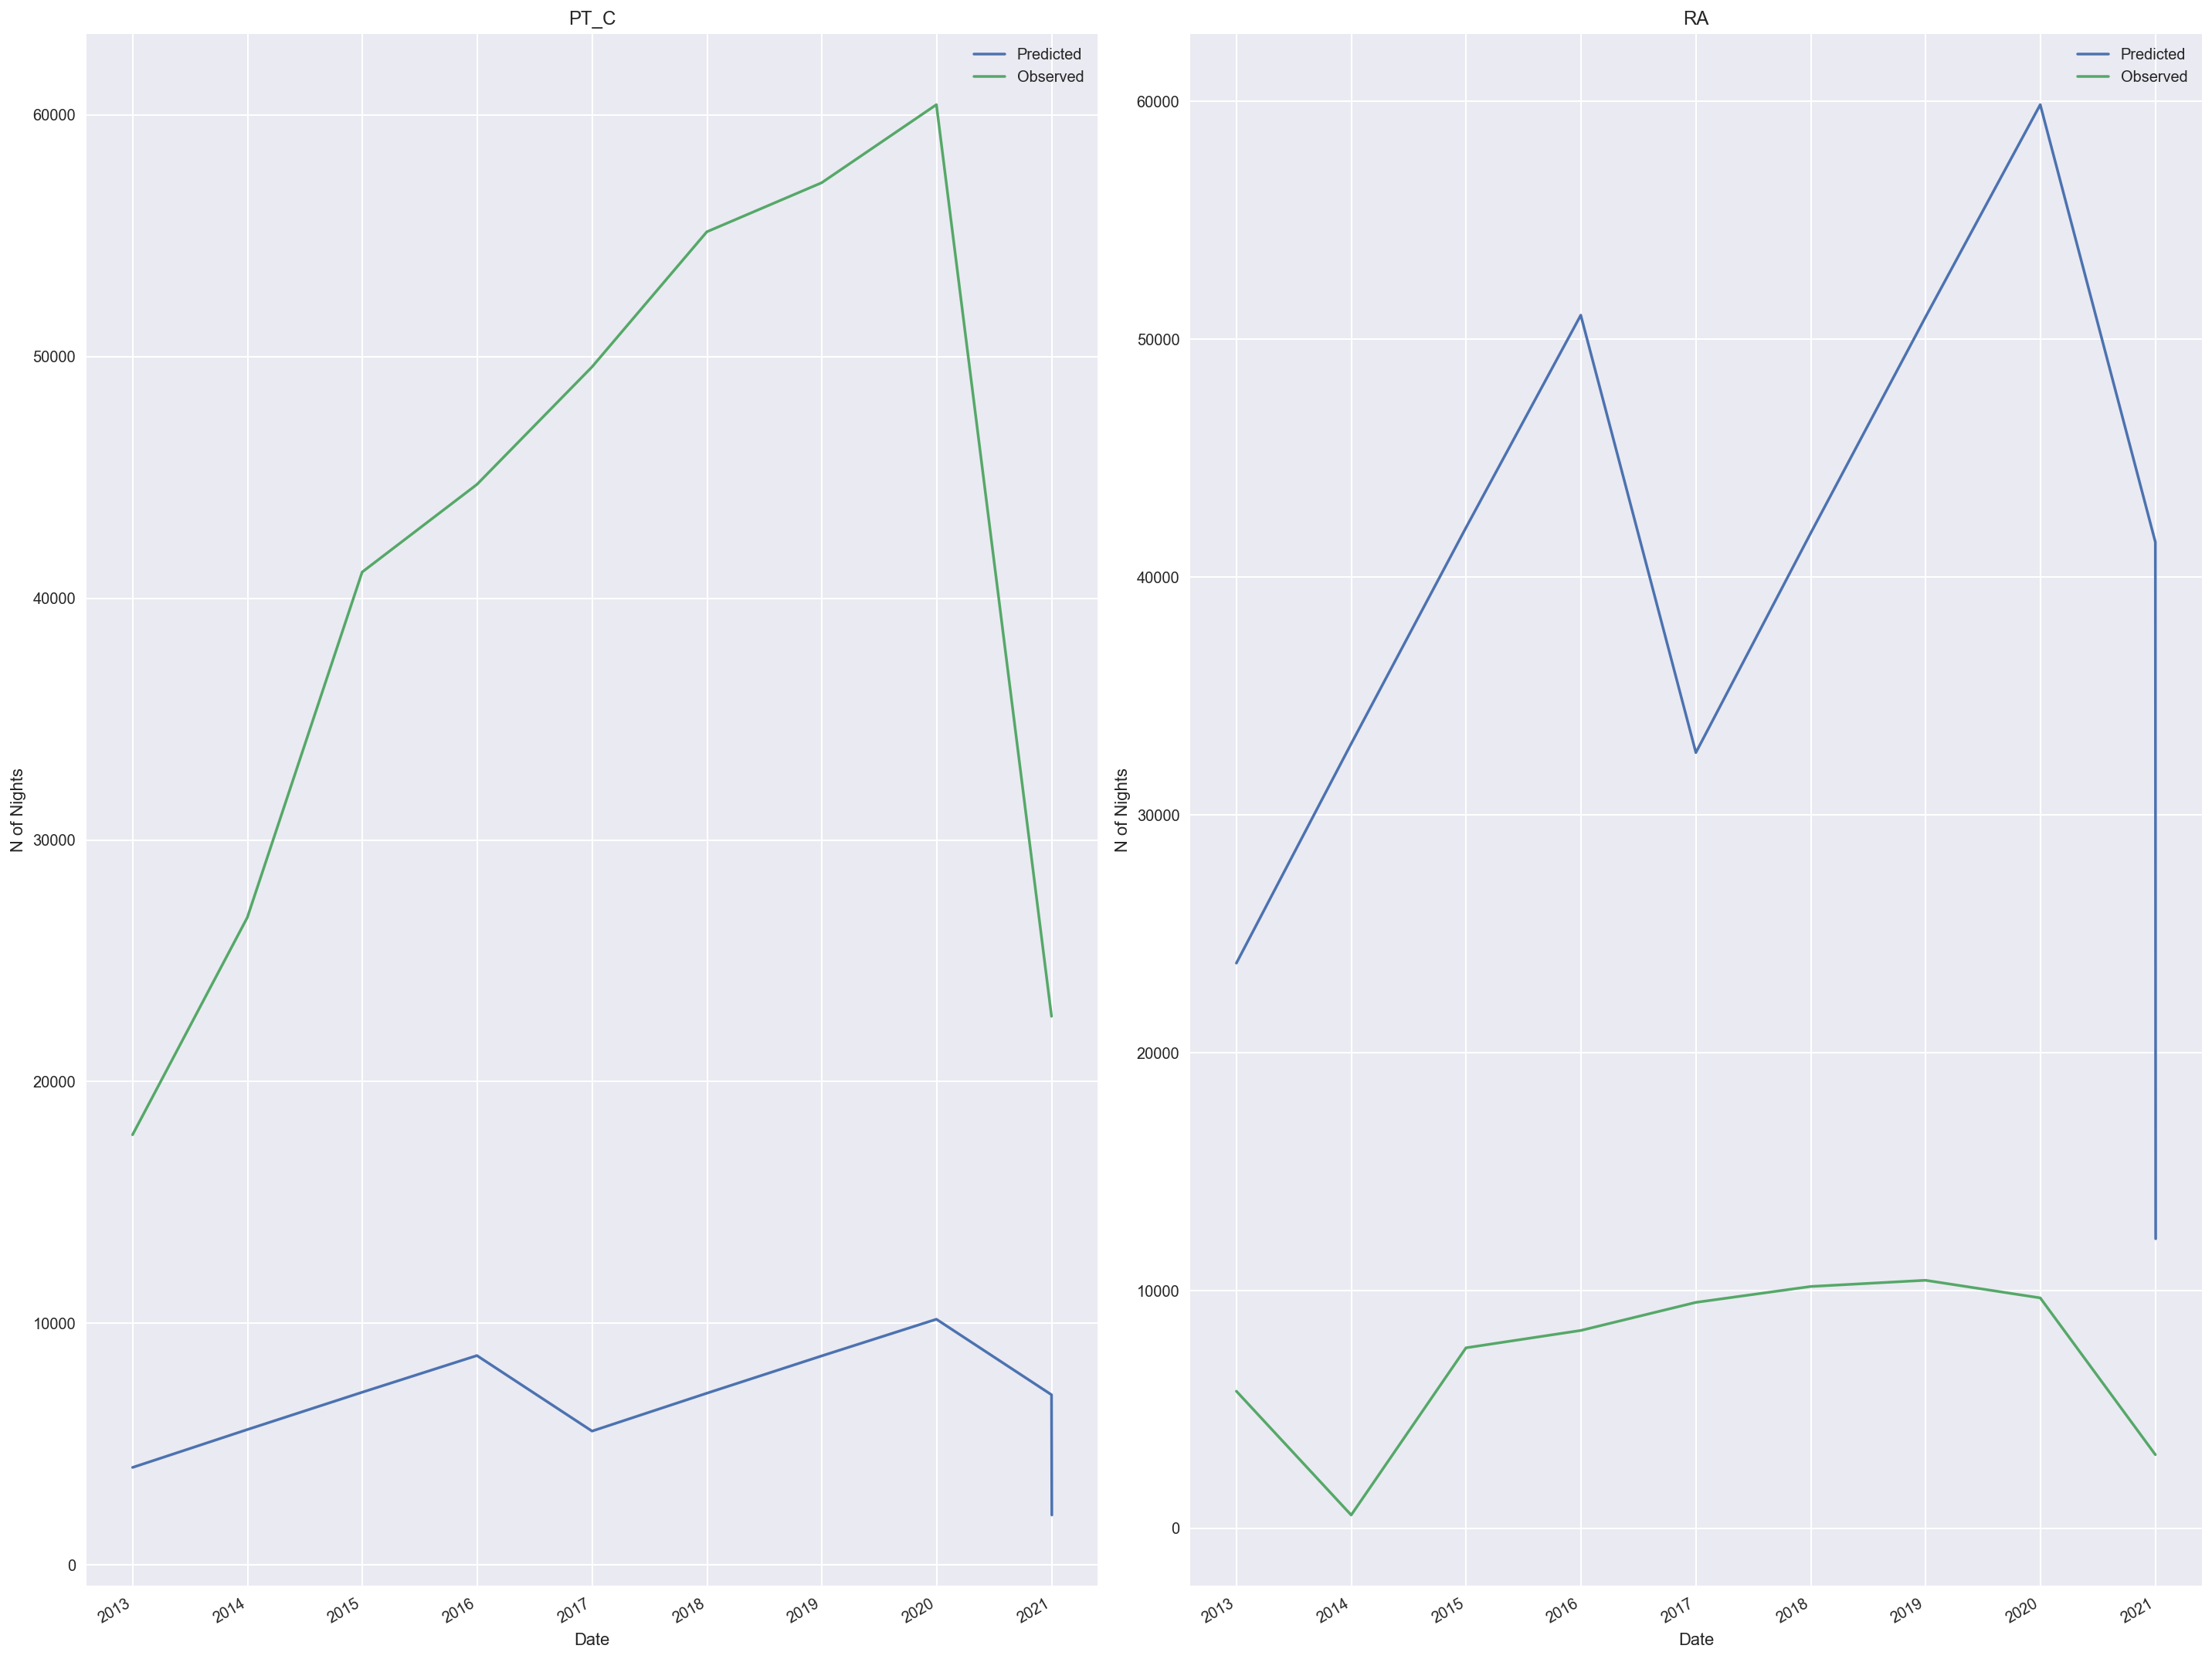

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
plot_results(nutsi, axes, pred_prophet_td)
plt.tight_layout()

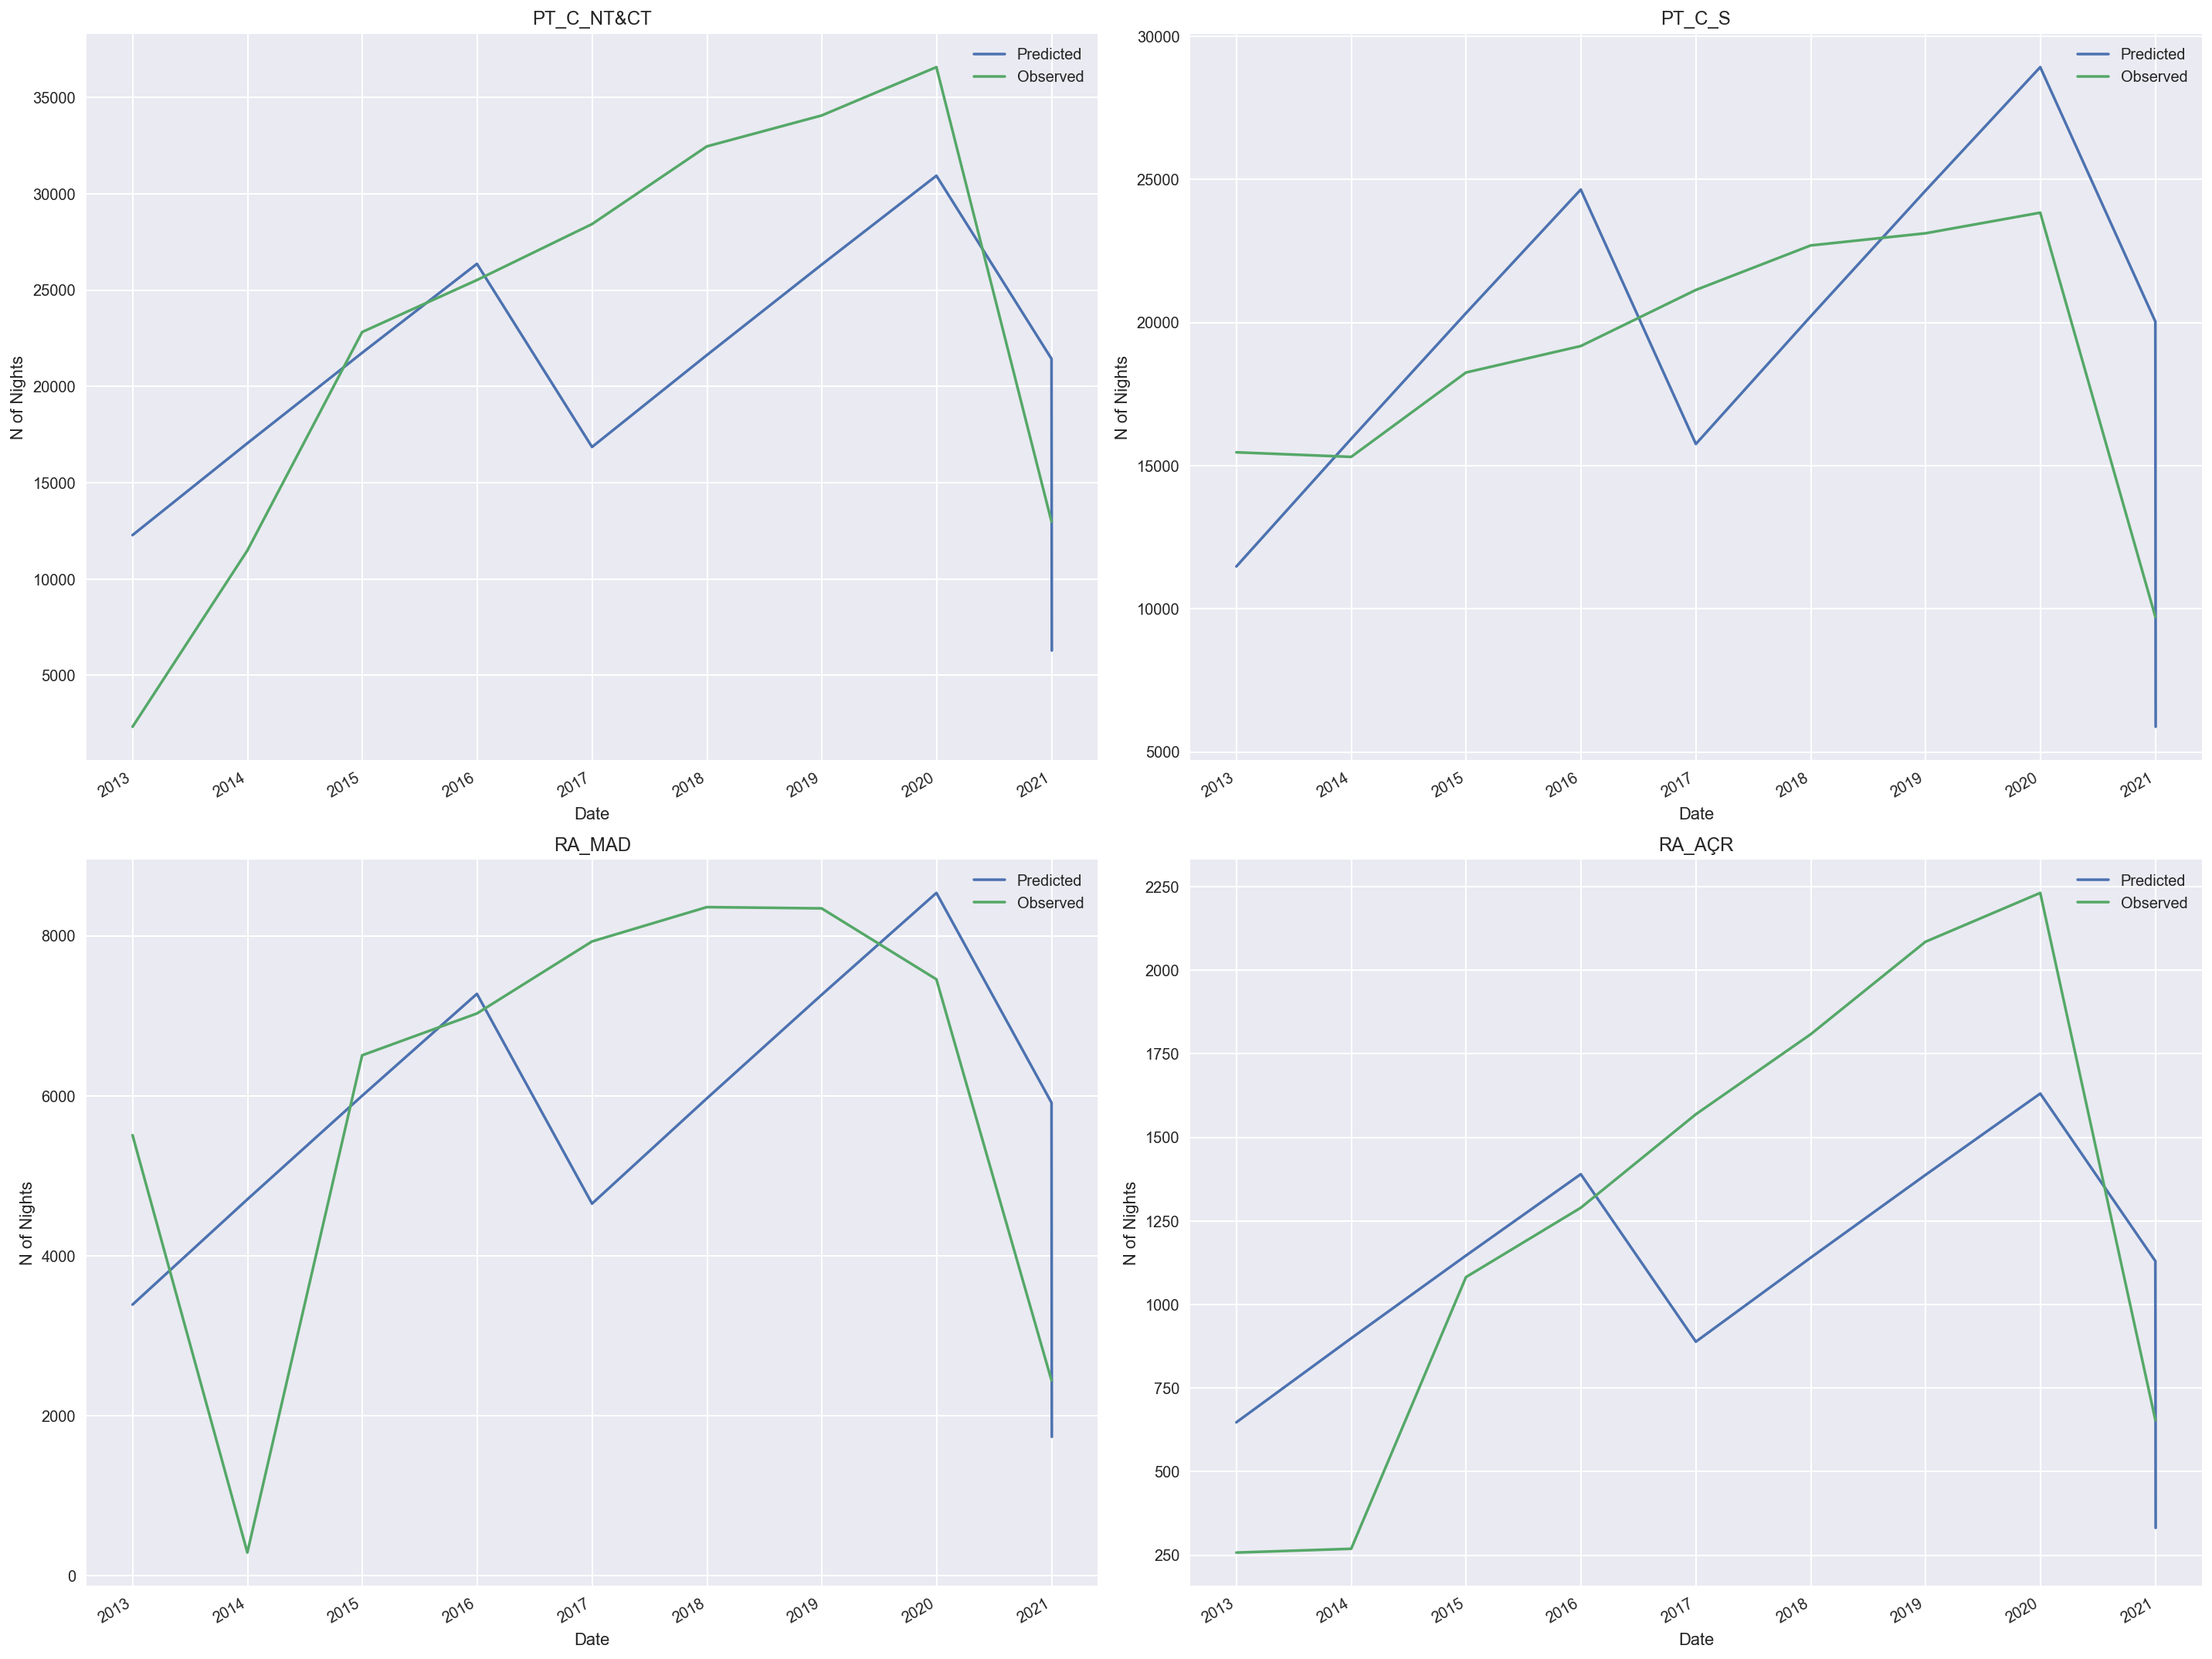

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_prophet_td)
plt.tight_layout()

## 2.3. optimal combination using OLS approach

In [46]:
prophet_ols = hts.HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)
prophet_ols = prophet_ols.fit(hierarchy_data, hierarchy)
pred_prophet_ols = prophet_ols.predict(steps_ahead=1)

Fitting models:   0%|                                                                            | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  14%|█████████▋                                                          | 1/7 [00:00<00:00,  8.54it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  29%|███████████████████▍                                                | 2/7 [00:00<00:00,  9.29it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonalit

In [47]:
pred_prophet_ols.round()

total     PT_C       RA  PT_C_NT&CT  PT_C_S   RA_MAD   RA_AÇR
2012-12-31  27803.0  17030.0  10773.0      1531.0  9241.0  10485.0   6546.0
2013-12-31  38603.0  23776.0  14828.0      6057.0  8771.0  14116.0   9660.0
2014-12-31  49231.0  30403.0  18829.0     10532.0  8296.0  17689.0  12714.0
2015-12-31  59677.0  36905.0  22771.0     14954.0  7817.0  21200.0  15705.0
2016-12-31  38162.0  23491.0  14671.0      7460.0  7211.0  13790.0   9701.0
2017-12-31  48963.0  30236.0  18726.0     11985.0  6741.0  17421.0  12815.0
2018-12-31  59590.0  36863.0  22727.0     16461.0  6266.0  20994.0  15869.0
2019-12-31  70036.0  43366.0  26670.0     20883.0  5787.0  24506.0  18860.0
2020-12-31  48521.0  29951.0  18570.0     13389.0  5181.0  17096.0  12856.0
2021-01-01  14158.0   8374.0   5784.0       795.0  4988.0   5369.0   3005.0

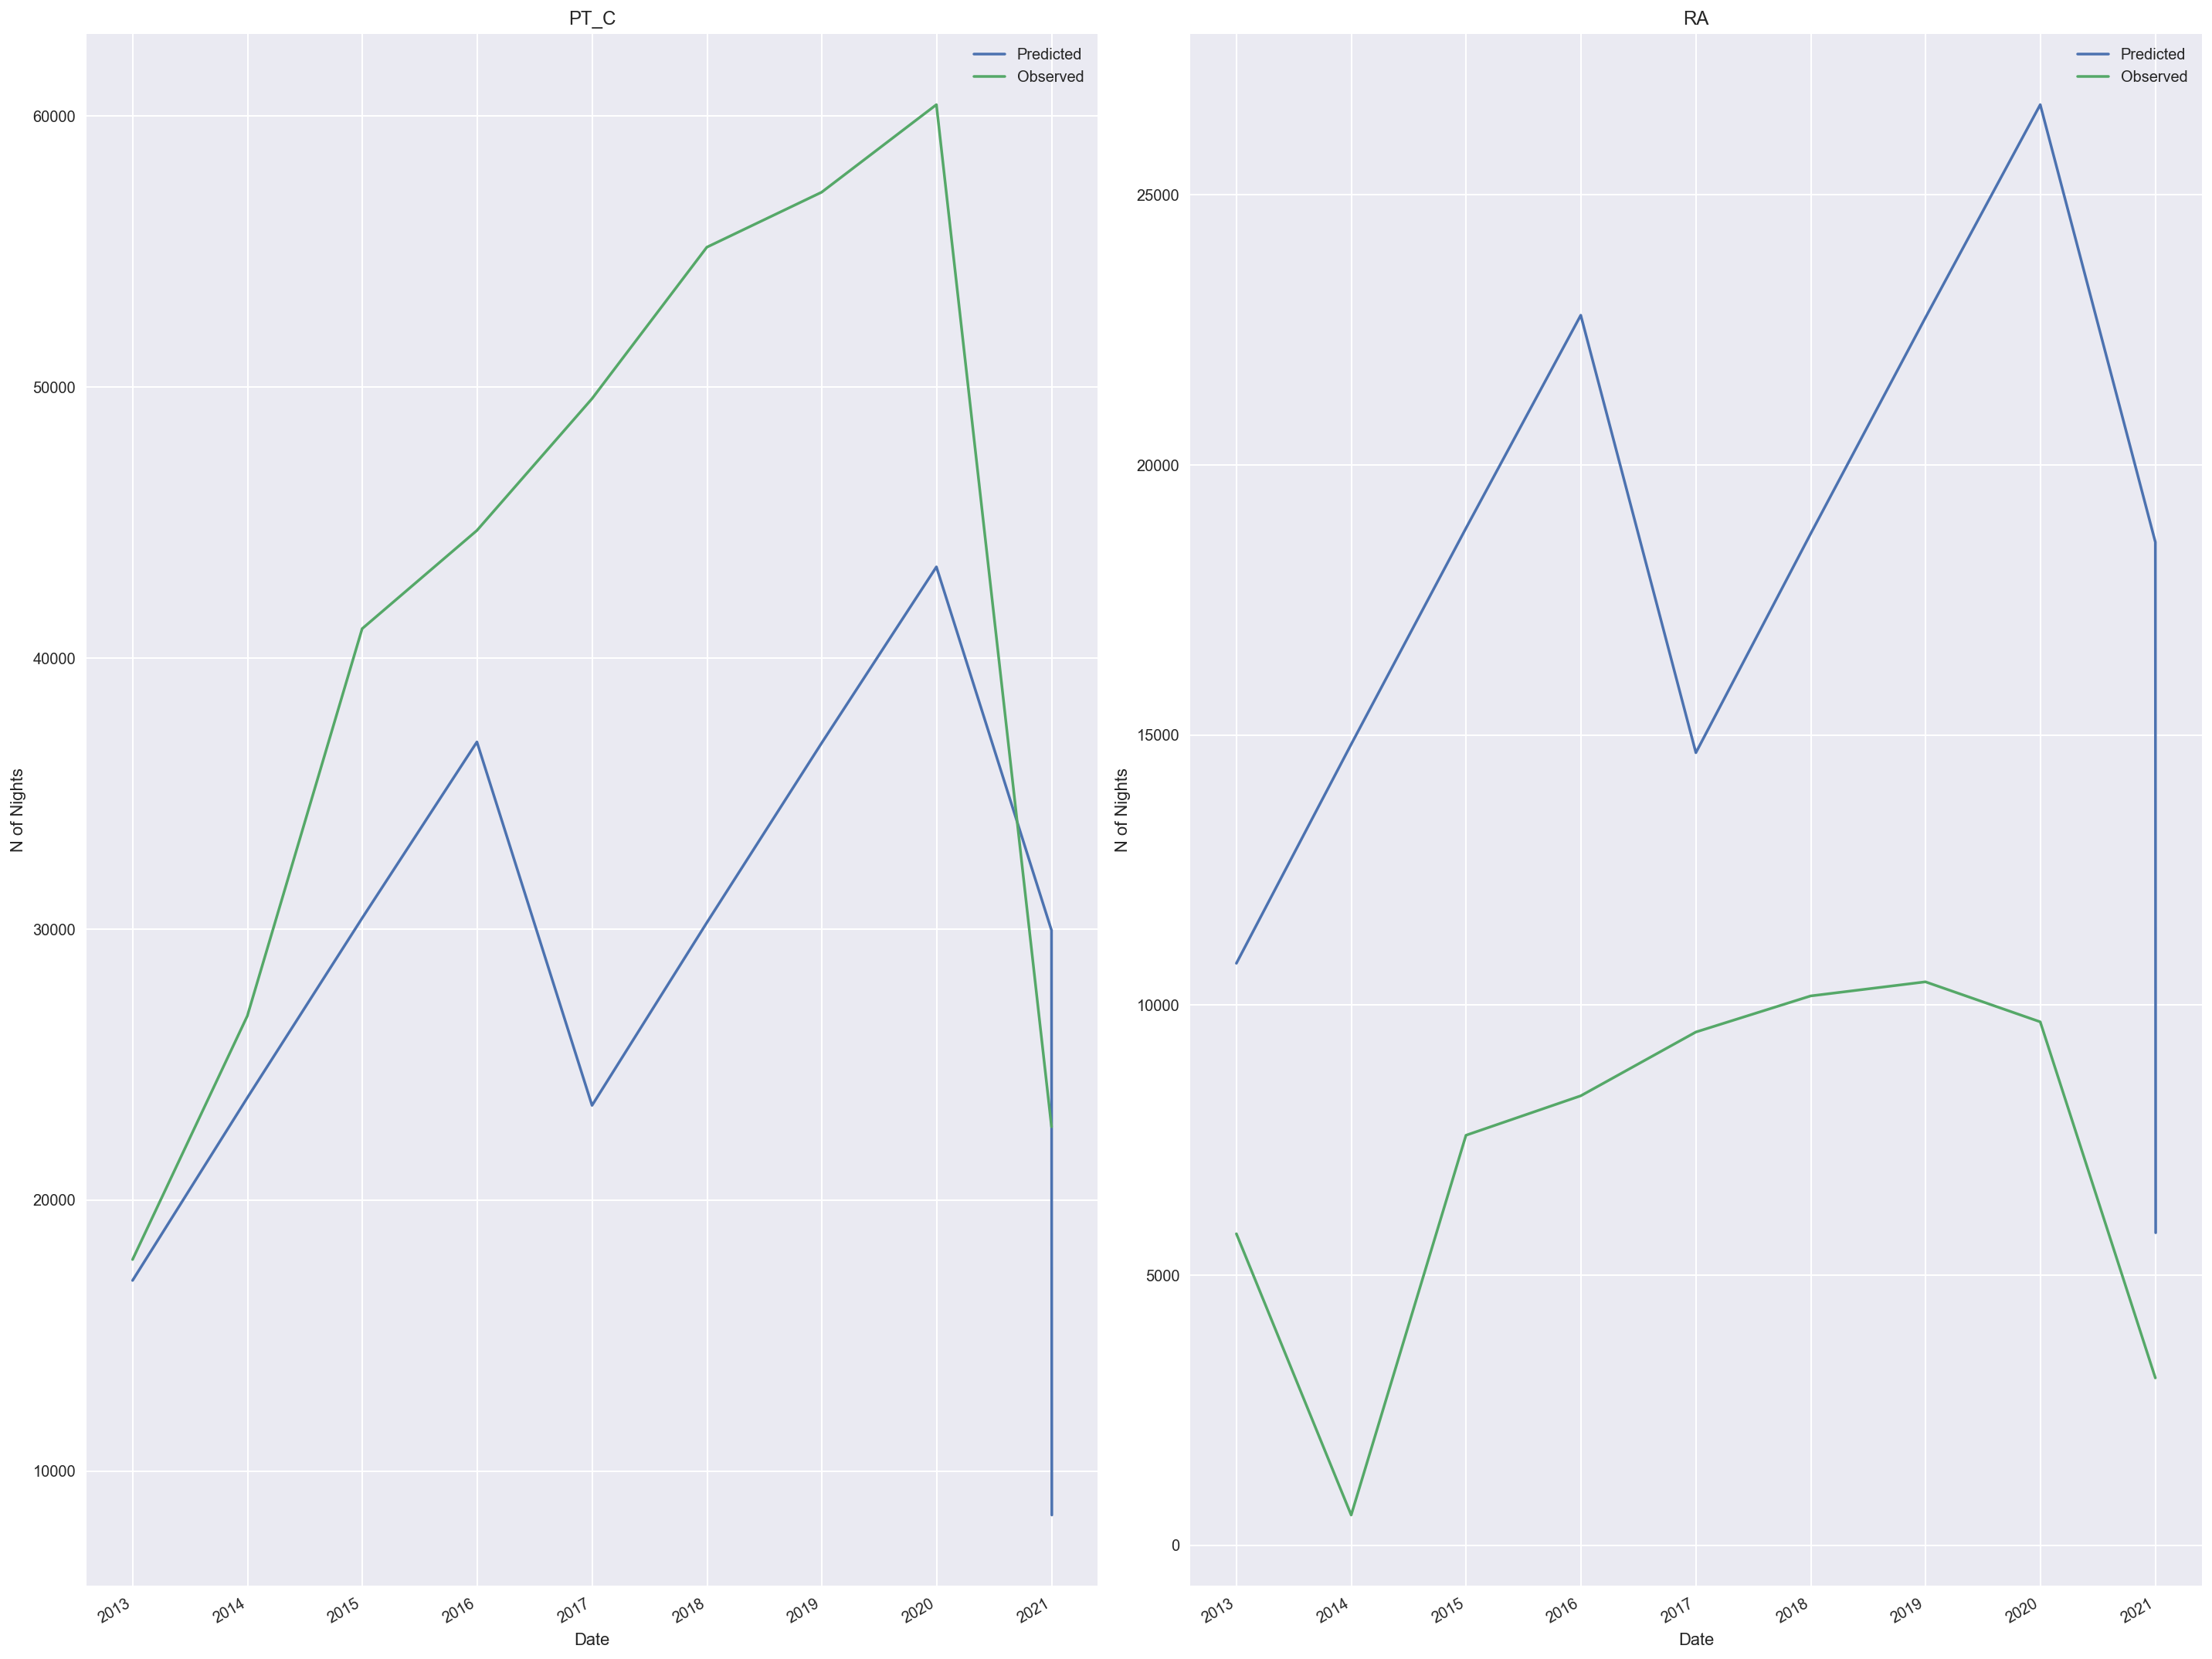

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
plot_results(nutsi, axes, pred_prophet_ols)
plt.tight_layout()

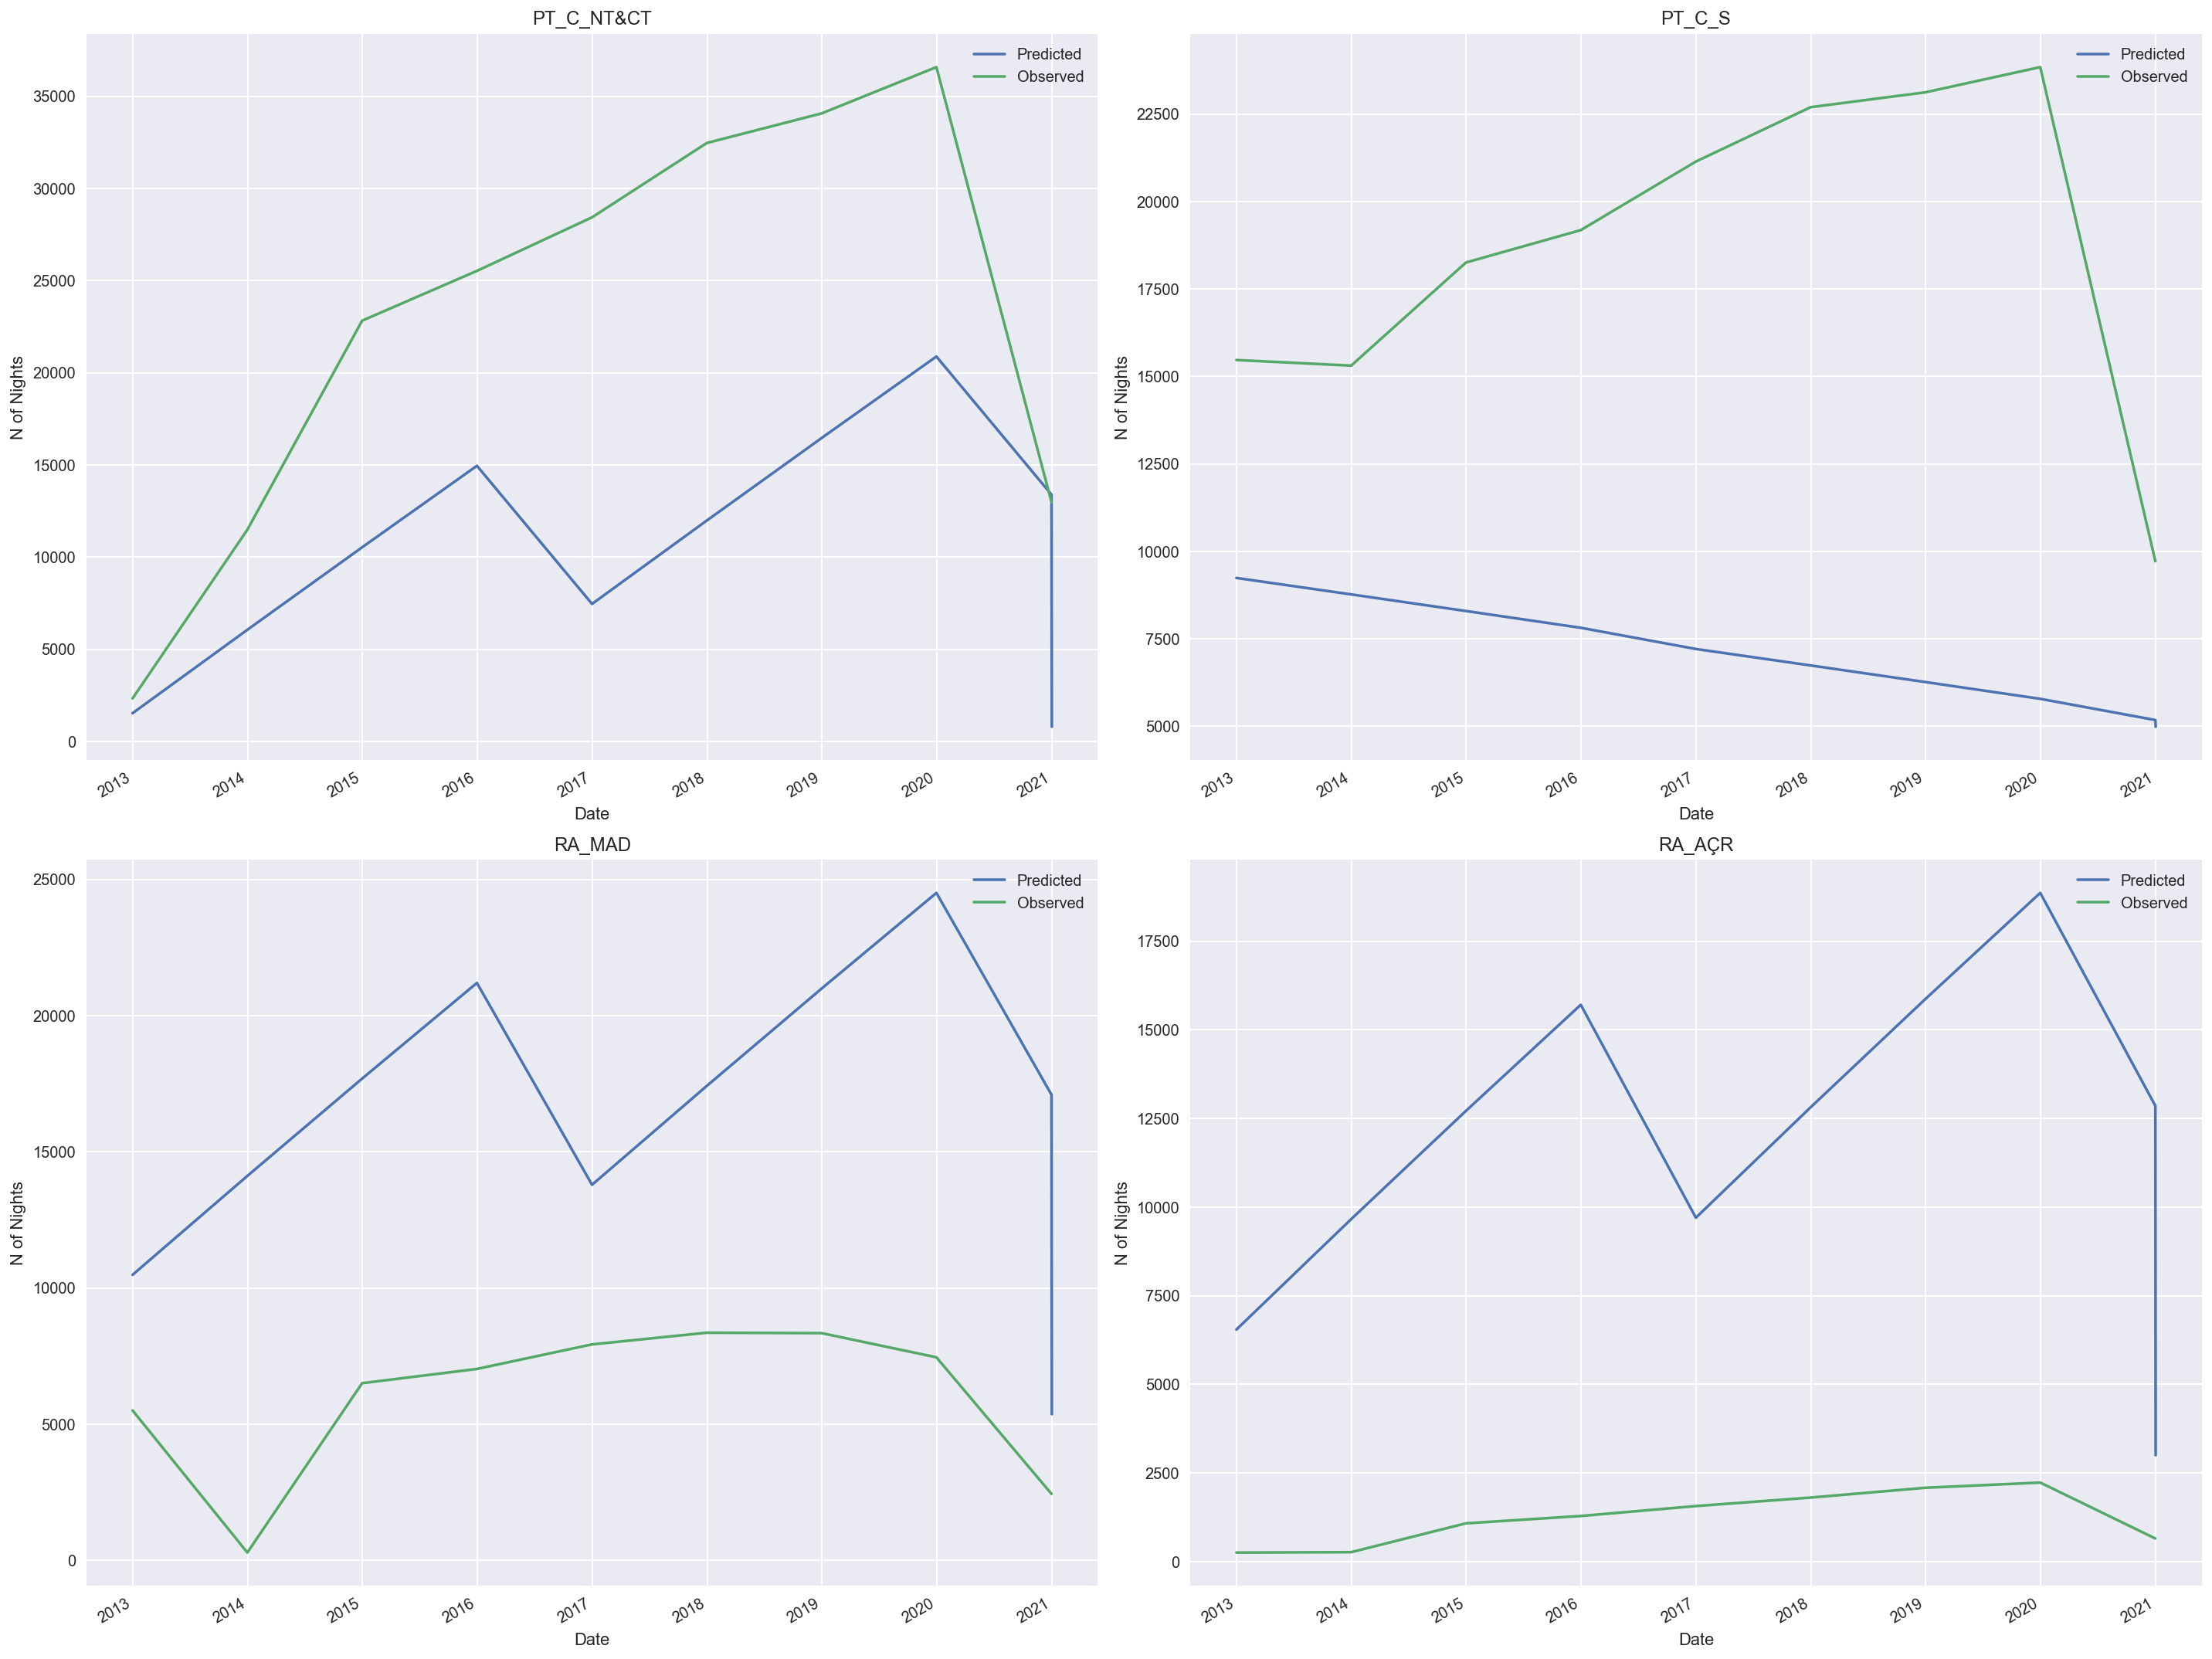

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_prophet_ols)
plt.tight_layout()

## 2.4. WLSS approach

In [50]:
prophet_wlss = hts.HTSRegressor(model='prophet', revision_method='WLSS', n_jobs=0)
prophet_wlss = prophet_wlss.fit(hierarchy_data, hierarchy)
pred_prophet_wlss = prophet_wlss.predict(steps_ahead=1)

Fitting models:   0%|                                                                            | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  14%|█████████▋                                                          | 1/7 [00:00<00:00,  9.92it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overrid

In [51]:
pred_arima_wlss.round()

total     PT_C       RA  PT_C_NT&CT   PT_C_S   RA_MAD   RA_AÇR
2012-12-31  48535.0  23955.0  24580.0     14400.0  10179.0  14970.0   8985.0
2013-12-31  48608.0  24047.0  24561.0     14391.0  10170.0  14906.0   9141.0
2014-12-31  48611.0  24051.0  24561.0     14391.0  10170.0  14903.0   9147.0
2015-12-31  48842.0  24339.0  24503.0     14362.0  10141.0  14701.0   9639.0
2016-12-31  48901.0  24413.0  24488.0     14355.0  10133.0  14649.0   9764.0
2017-12-31  48981.0  24513.0  24468.0     14345.0  10123.0  14580.0   9933.0
2018-12-31  49049.0  24598.0  24451.0     14336.0  10115.0  14520.0  10077.0
2019-12-31  49127.0  24696.0  24431.0     14326.0  10105.0  14451.0  10245.0
2020-12-31  49169.0  24748.0  24421.0     14321.0  10100.0  14415.0  10333.0
2021-01-01  48721.0  24187.0  24533.0     14377.0  10156.0  14807.0   9380.0

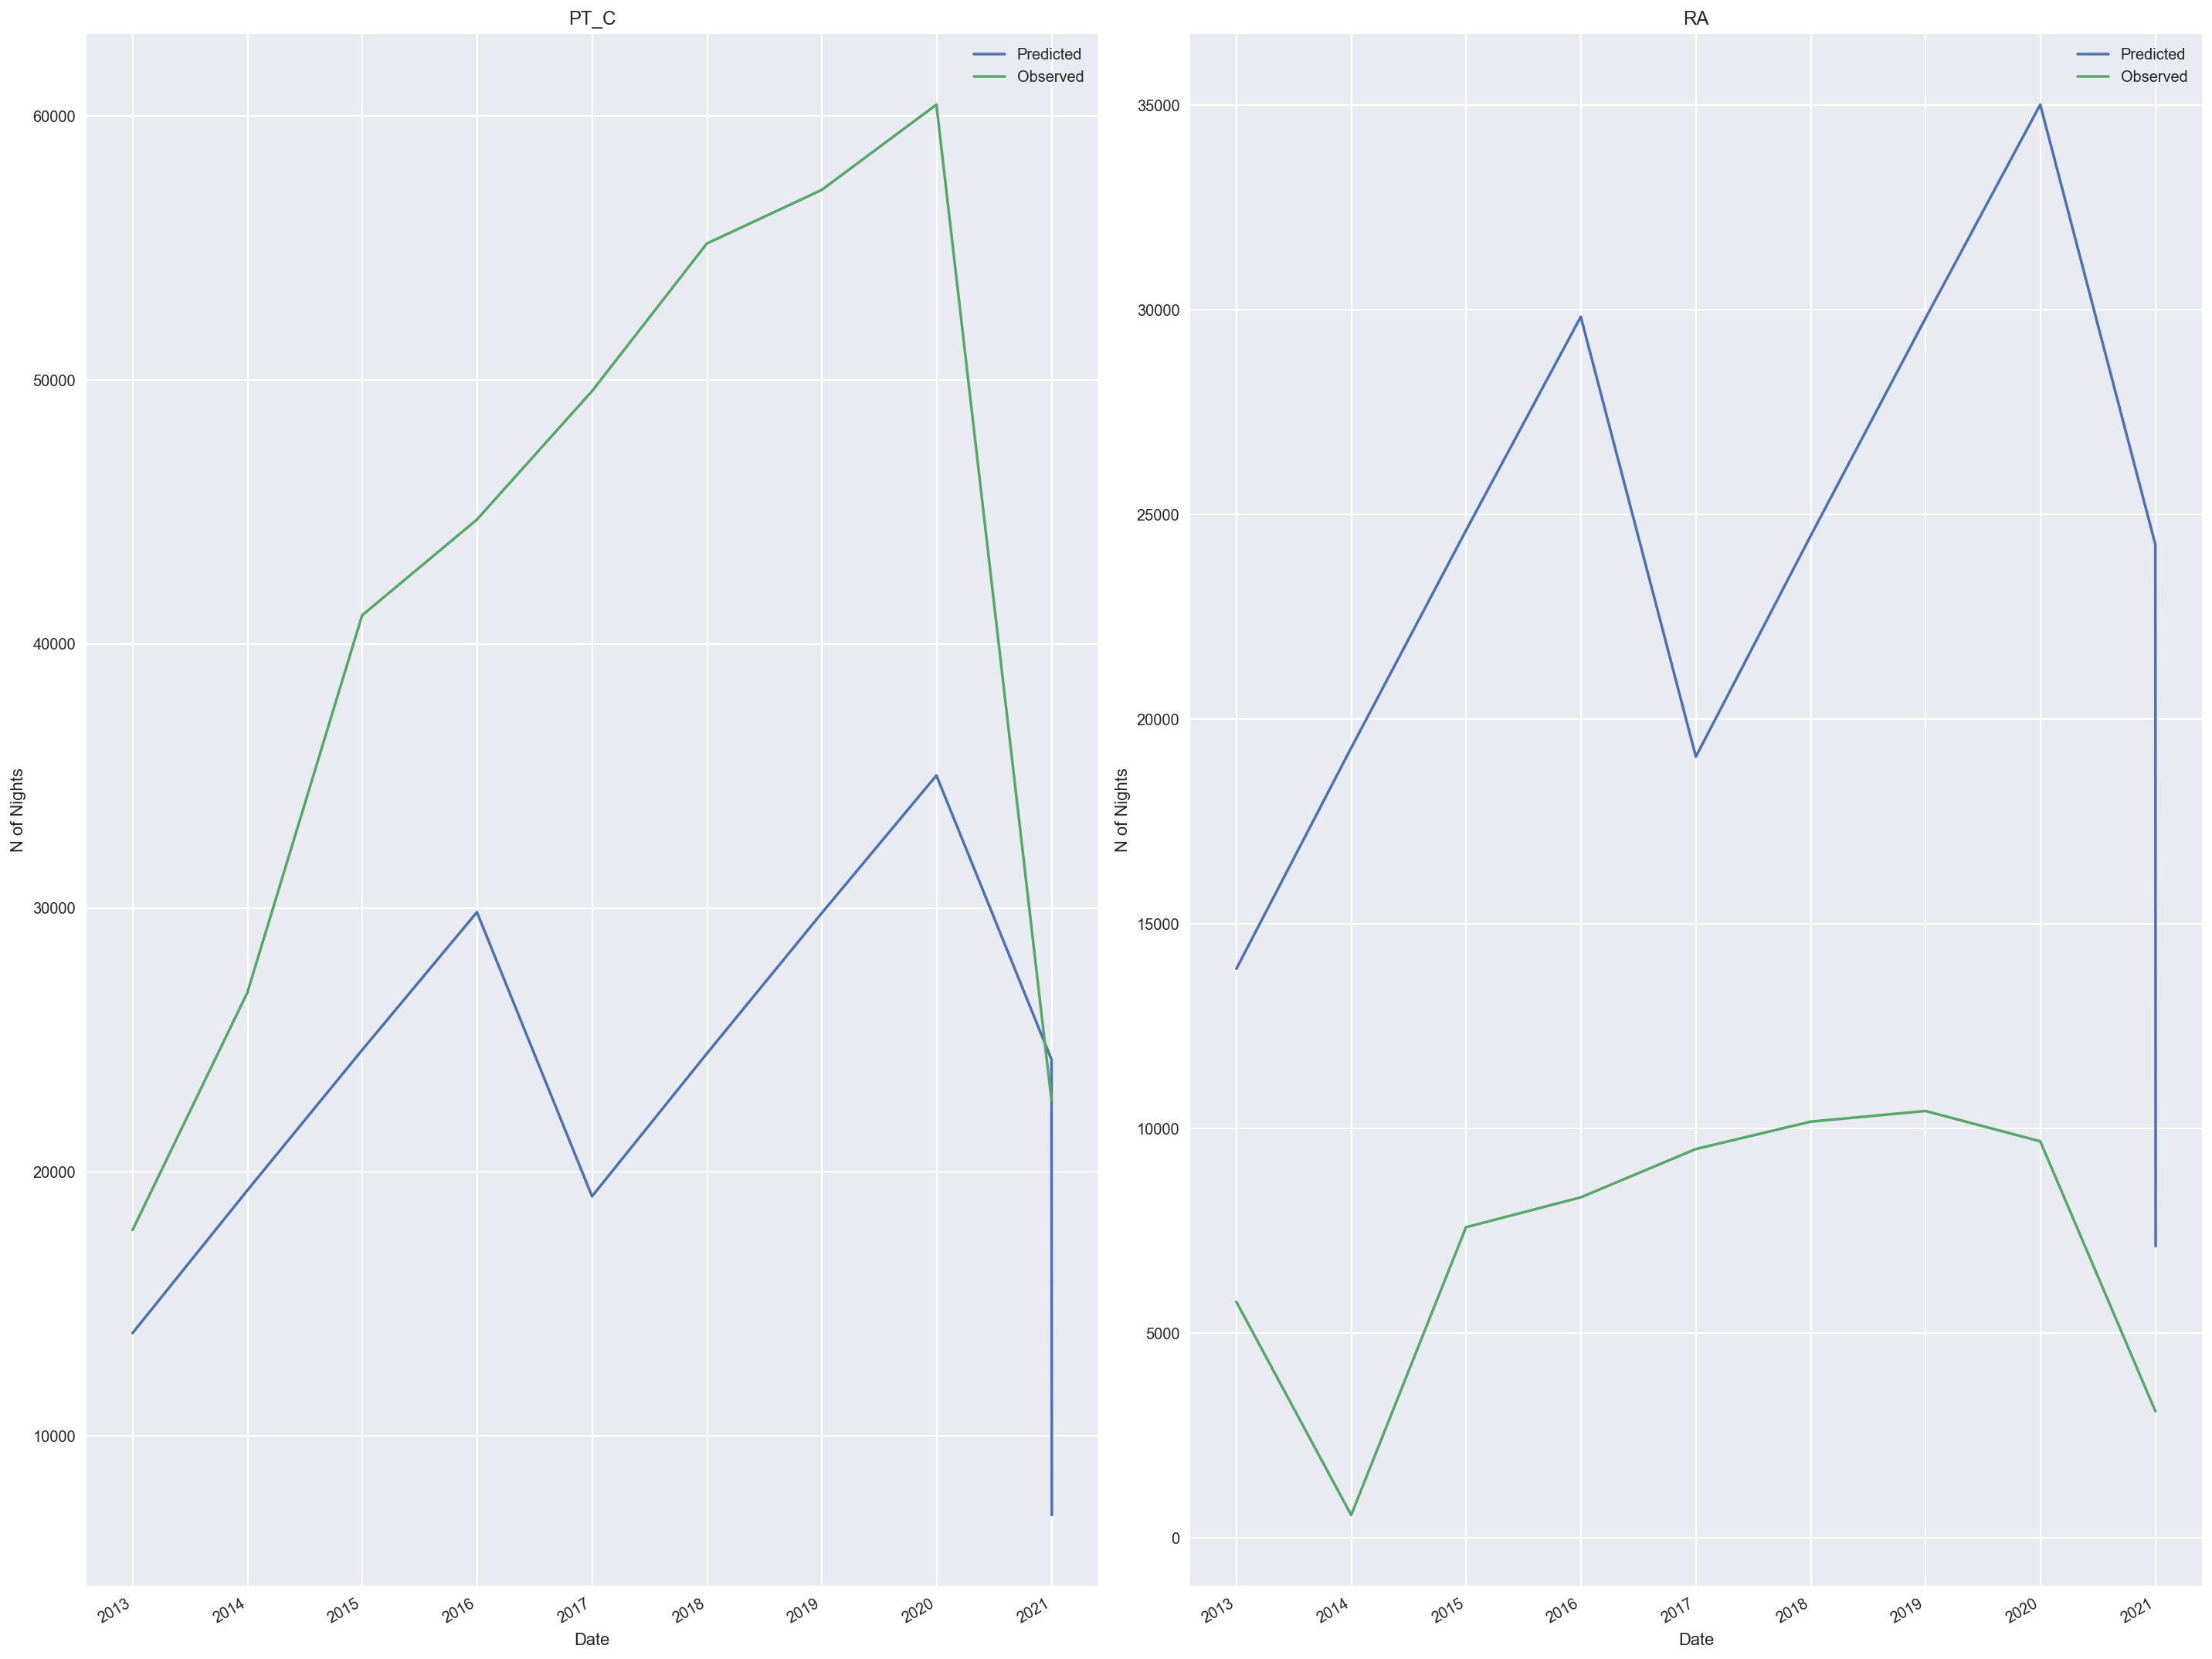

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
plot_results(nutsi, axes, pred_prophet_wlss)
plt.tight_layout()

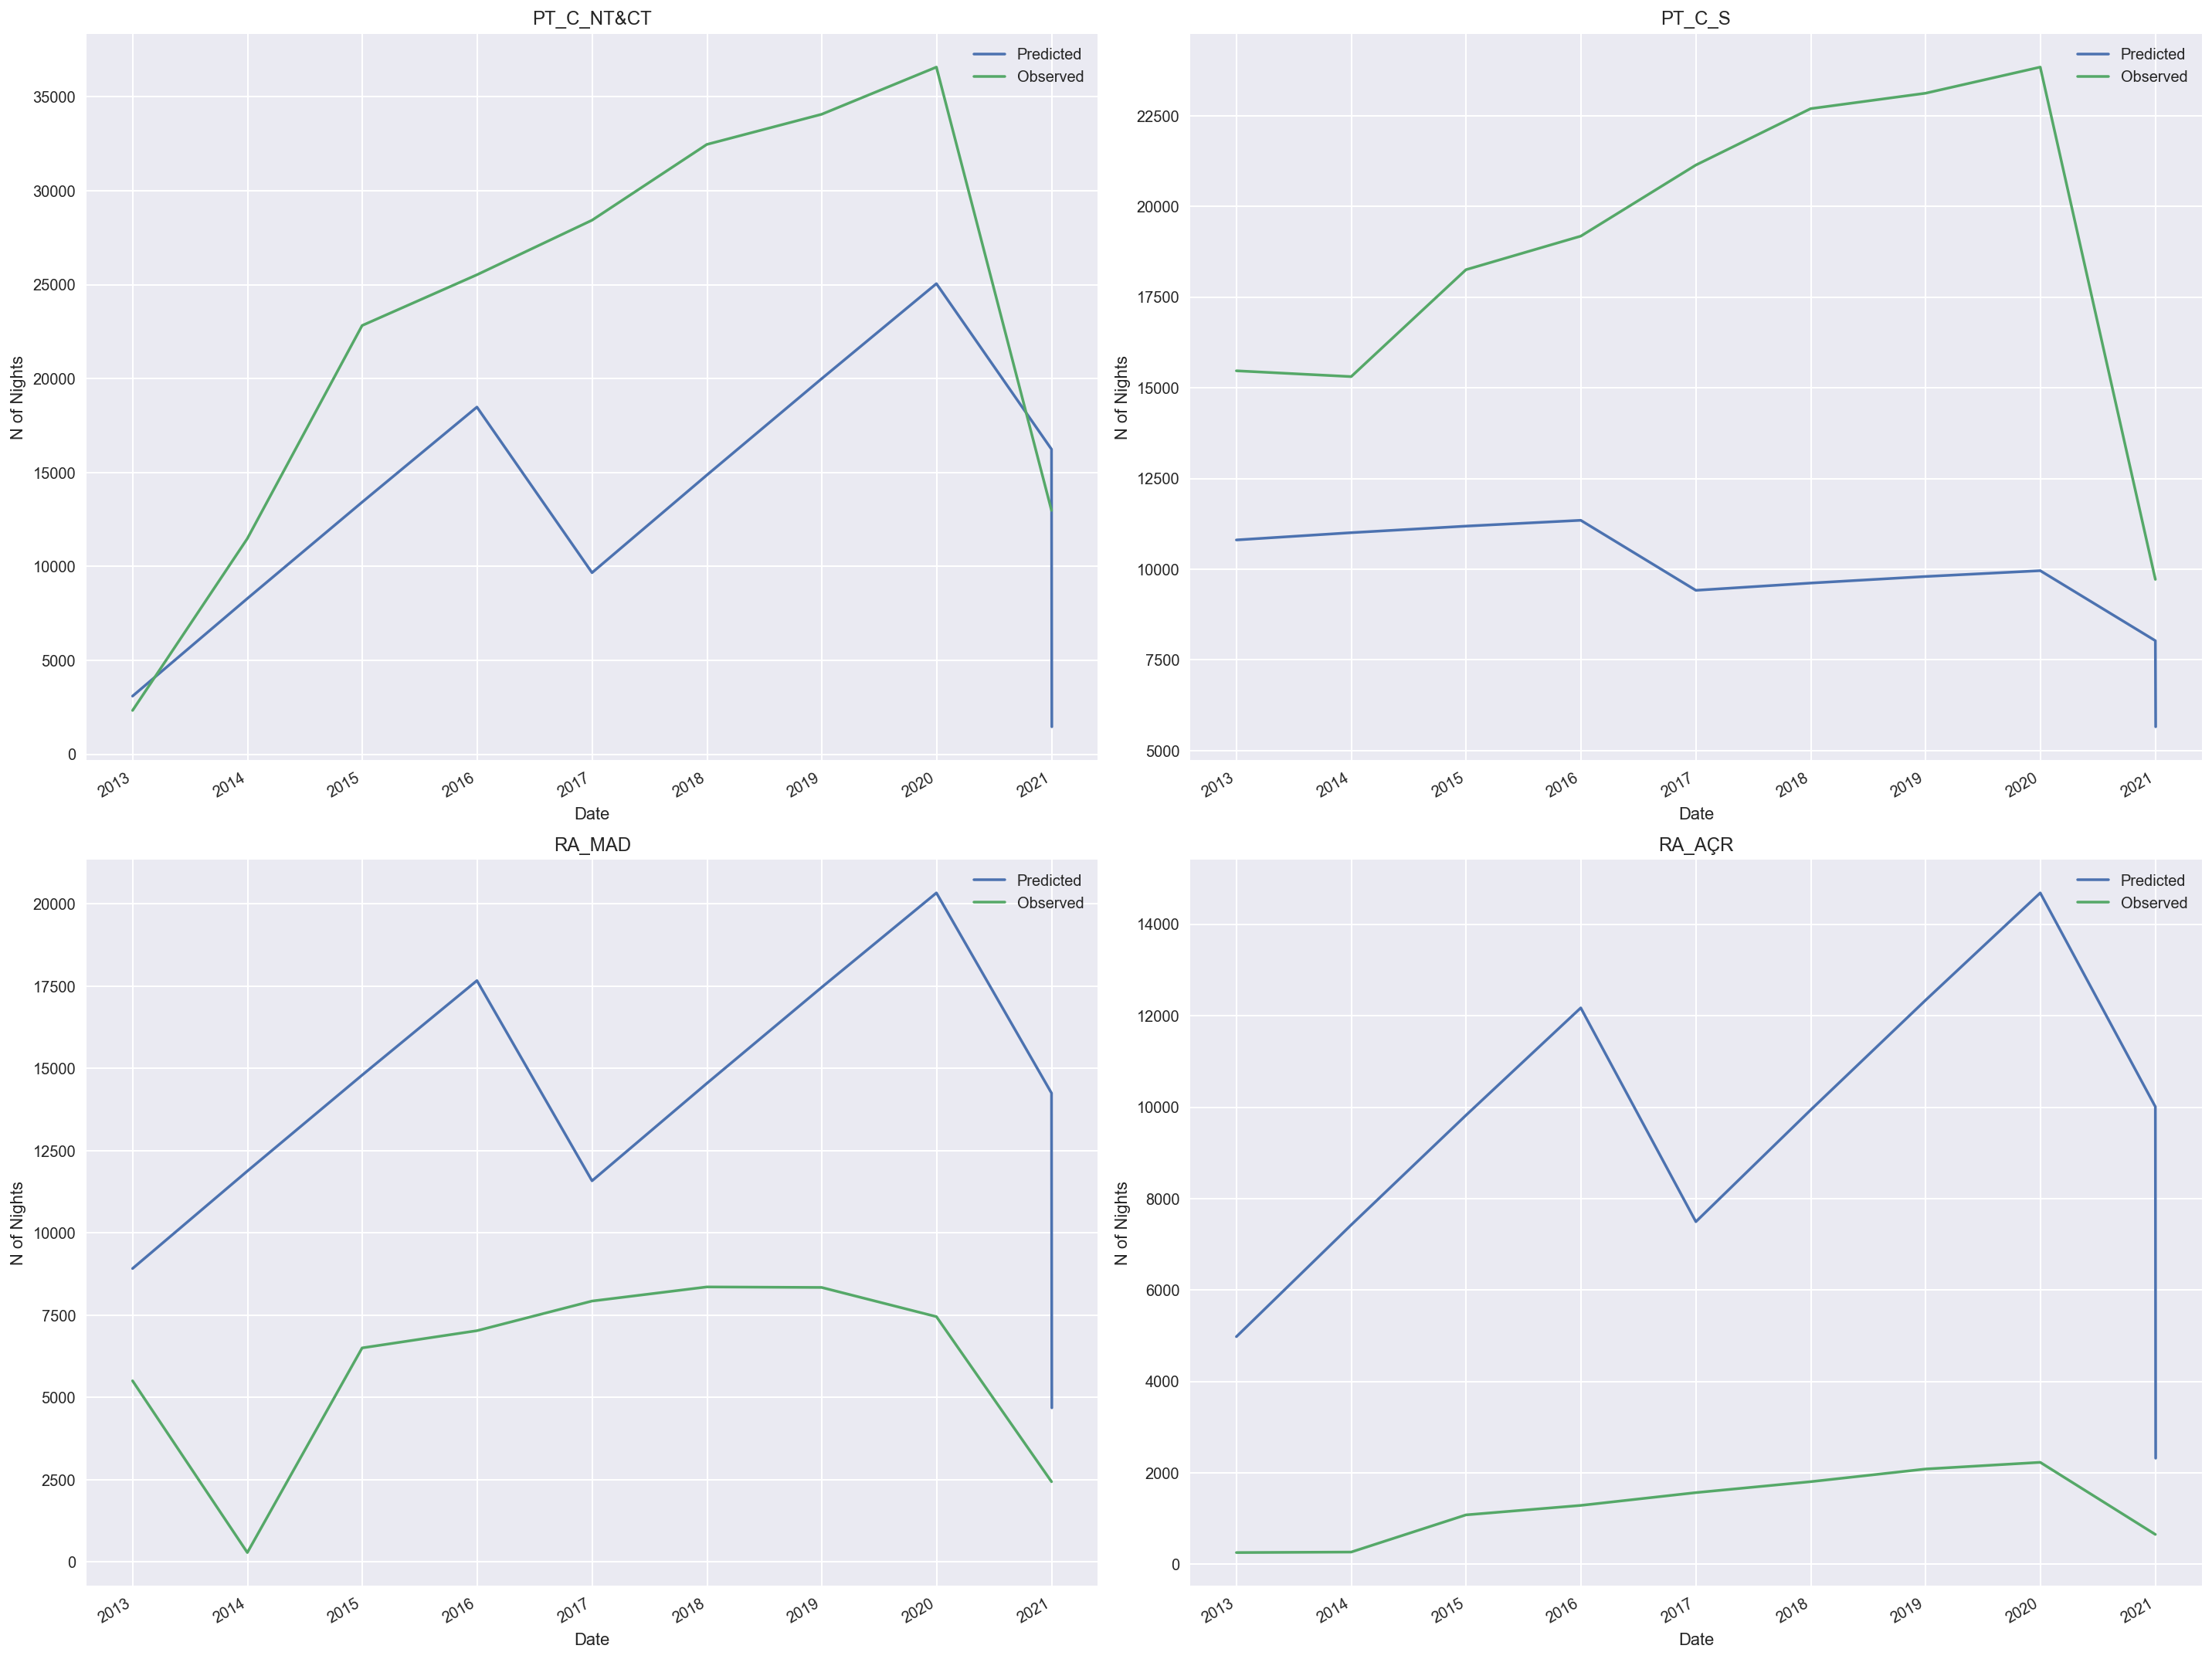

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_prophet_wlss)
plt.tight_layout()

## 2.5. WLSv approach

In [54]:
prophet_wlsv = hts.HTSRegressor(model='prophet', revision_method='WLSV', n_jobs=0)
prophet_wlsv = prophet_wlss.fit(hierarchy_data, hierarchy)
pred_prophet_wlsv = prophet_wlss.predict(steps_ahead=1)

Fitting models:   0%|                                                                            | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  14%|█████████▋                                                          | 1/7 [00:00<00:01,  4.93it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  29%|███████████████████▍                                                | 2/7 [00:00<00:00,  6.84it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonalit

In [55]:
pred_prophet_wlsv.round()

total     PT_C       RA  PT_C_NT&CT   PT_C_S   RA_MAD   RA_AÇR
2012-12-31  27803.0  13899.0  13904.0      3097.0  10807.0   8919.0   4980.0
2013-12-31  38606.0  19305.0  19301.0      8293.0  11007.0  11880.0   7425.0
2014-12-31  49232.0  24620.0  24612.0     13424.0  11188.0  14797.0   9823.0
2015-12-31  59674.0  29840.0  29834.0     18486.0  11348.0  17668.0  12172.0
2016-12-31  38166.0  19079.0  19087.0      9668.0   9419.0  11584.0   7495.0
2017-12-31  48968.0  24485.0  24483.0     14864.0   9619.0  14545.0   9940.0
2018-12-31  59594.0  29800.0  29794.0     19995.0   9800.0  17463.0  12338.0
2019-12-31  70036.0  35019.0  35016.0     25056.0   9960.0  20333.0  14687.0
2020-12-31  48528.0  24259.0  24269.0     16239.0   8030.0  14249.0  10009.0
2021-01-01  14131.0   7008.0   7123.0      1465.0   5658.0   4686.0   2322.0

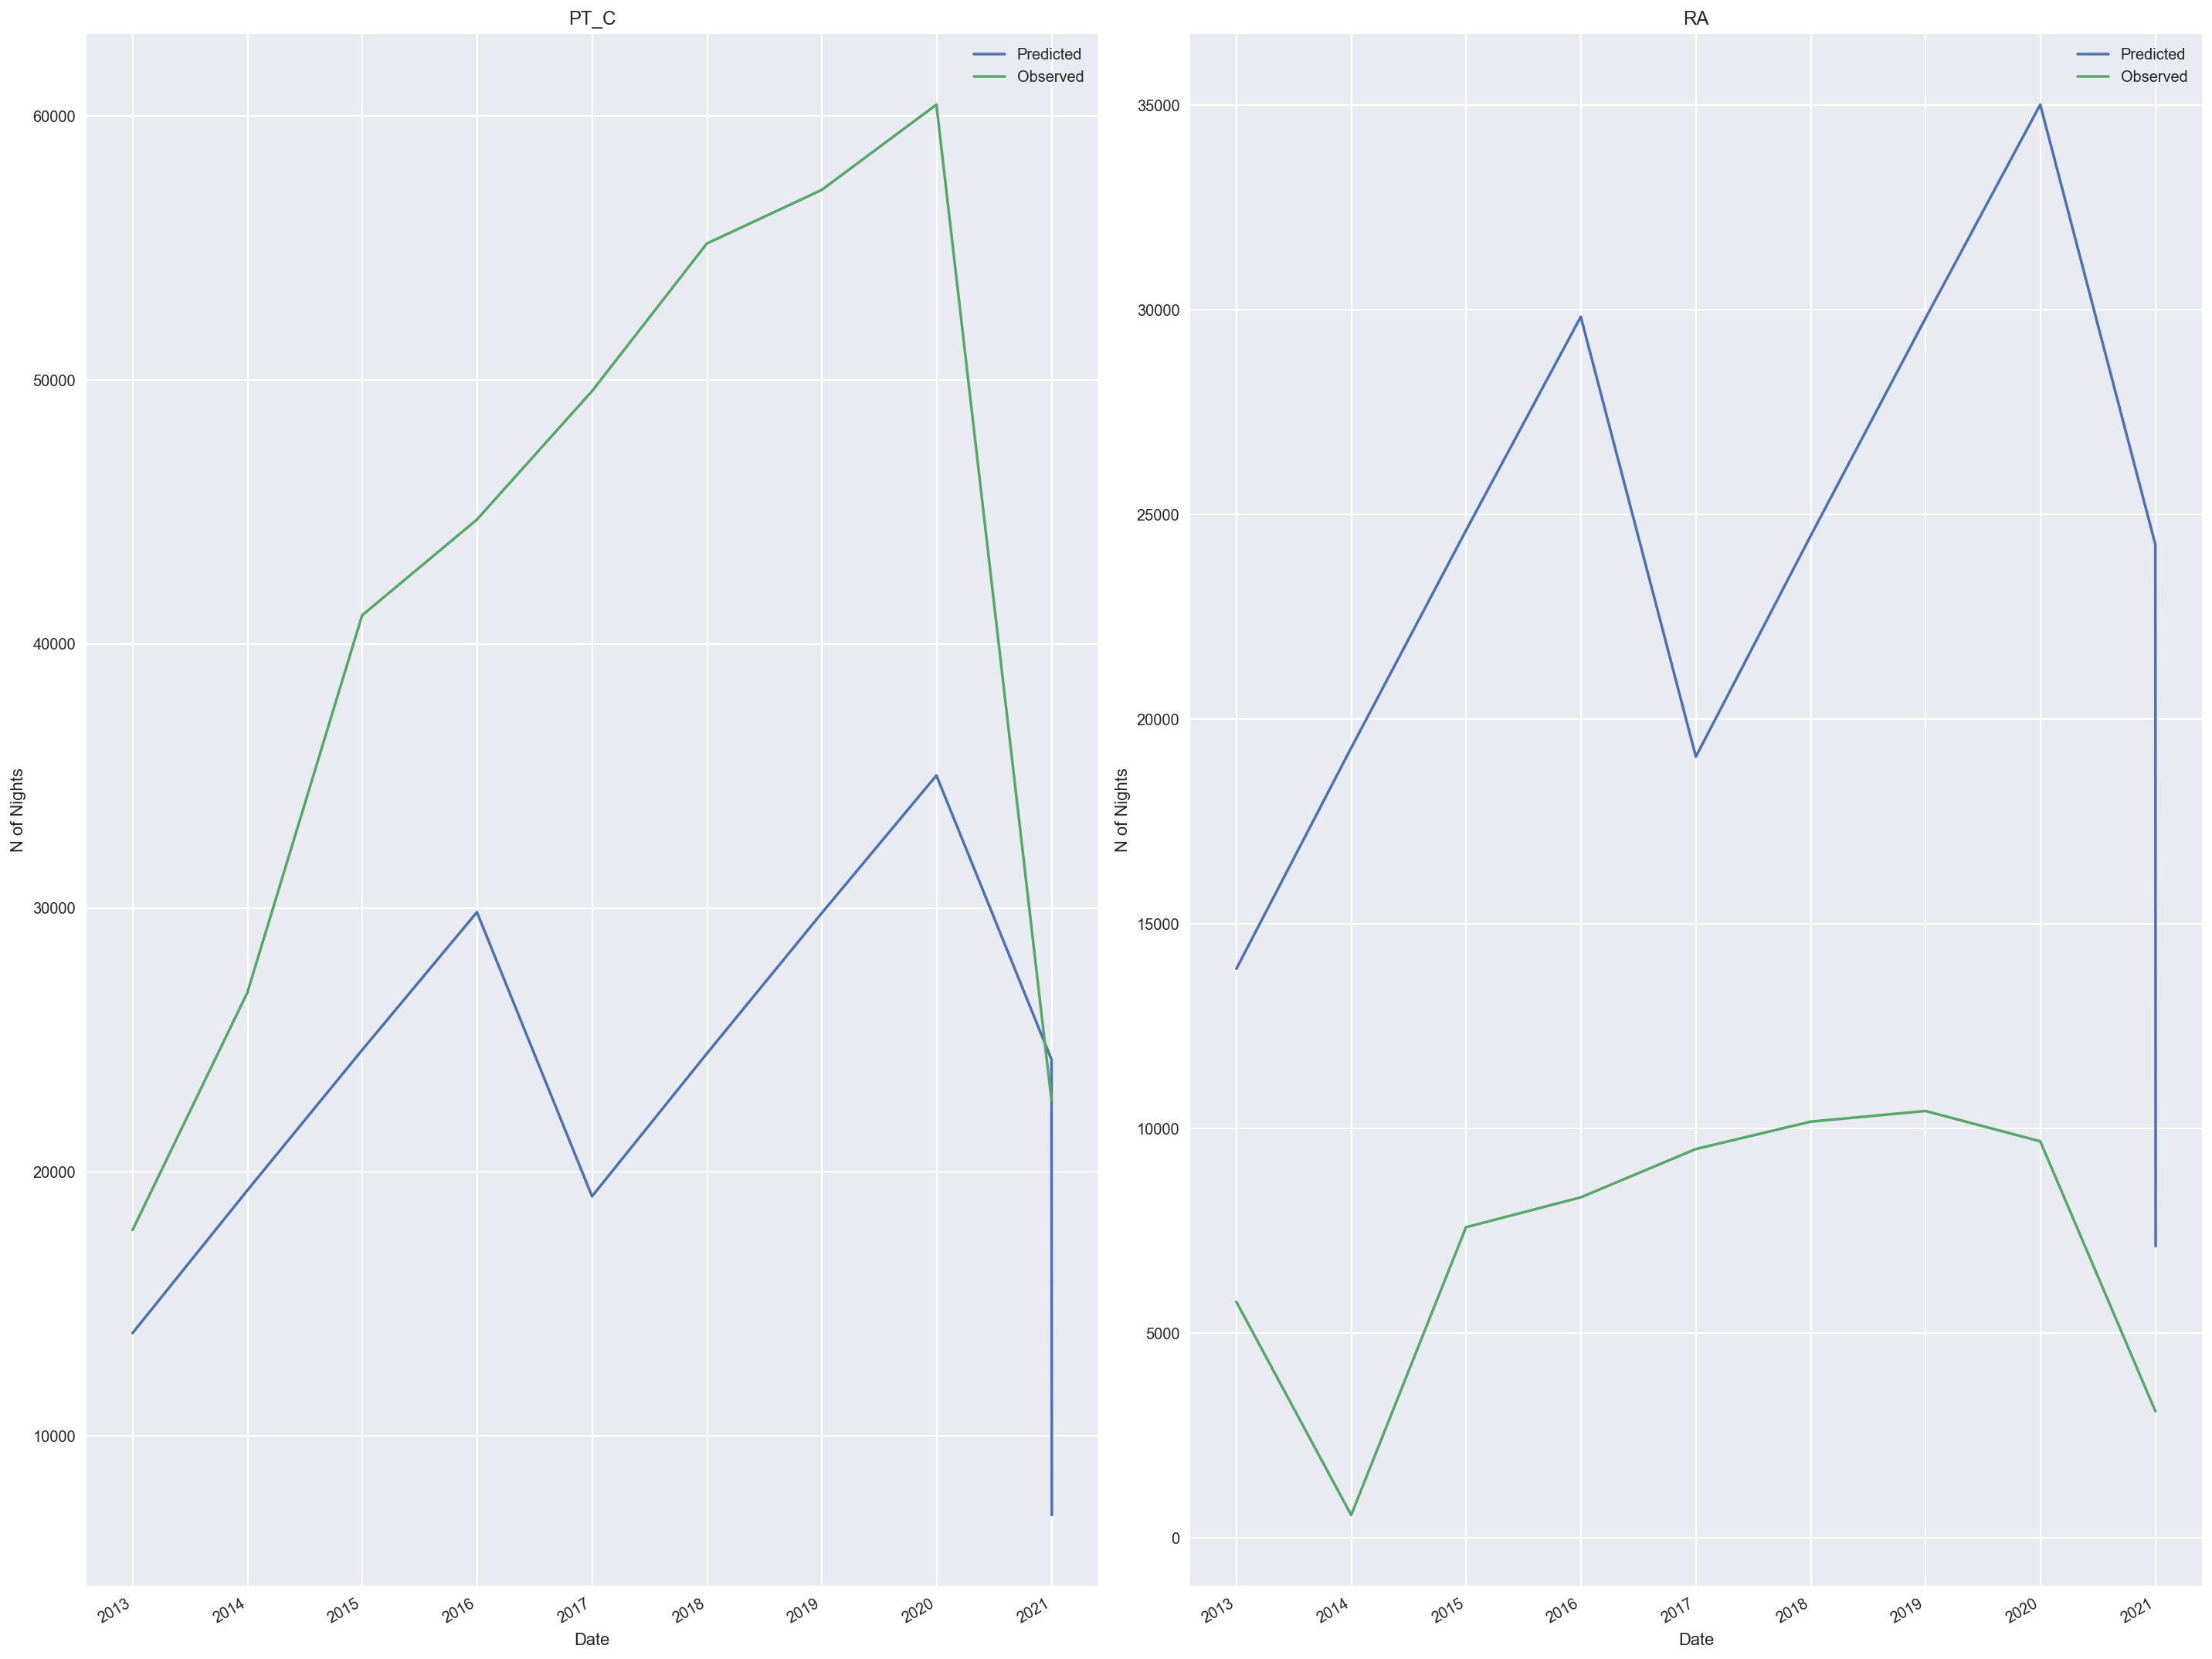

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
plot_results(nutsi, axes, pred_prophet_wlsv)
plt.tight_layout()

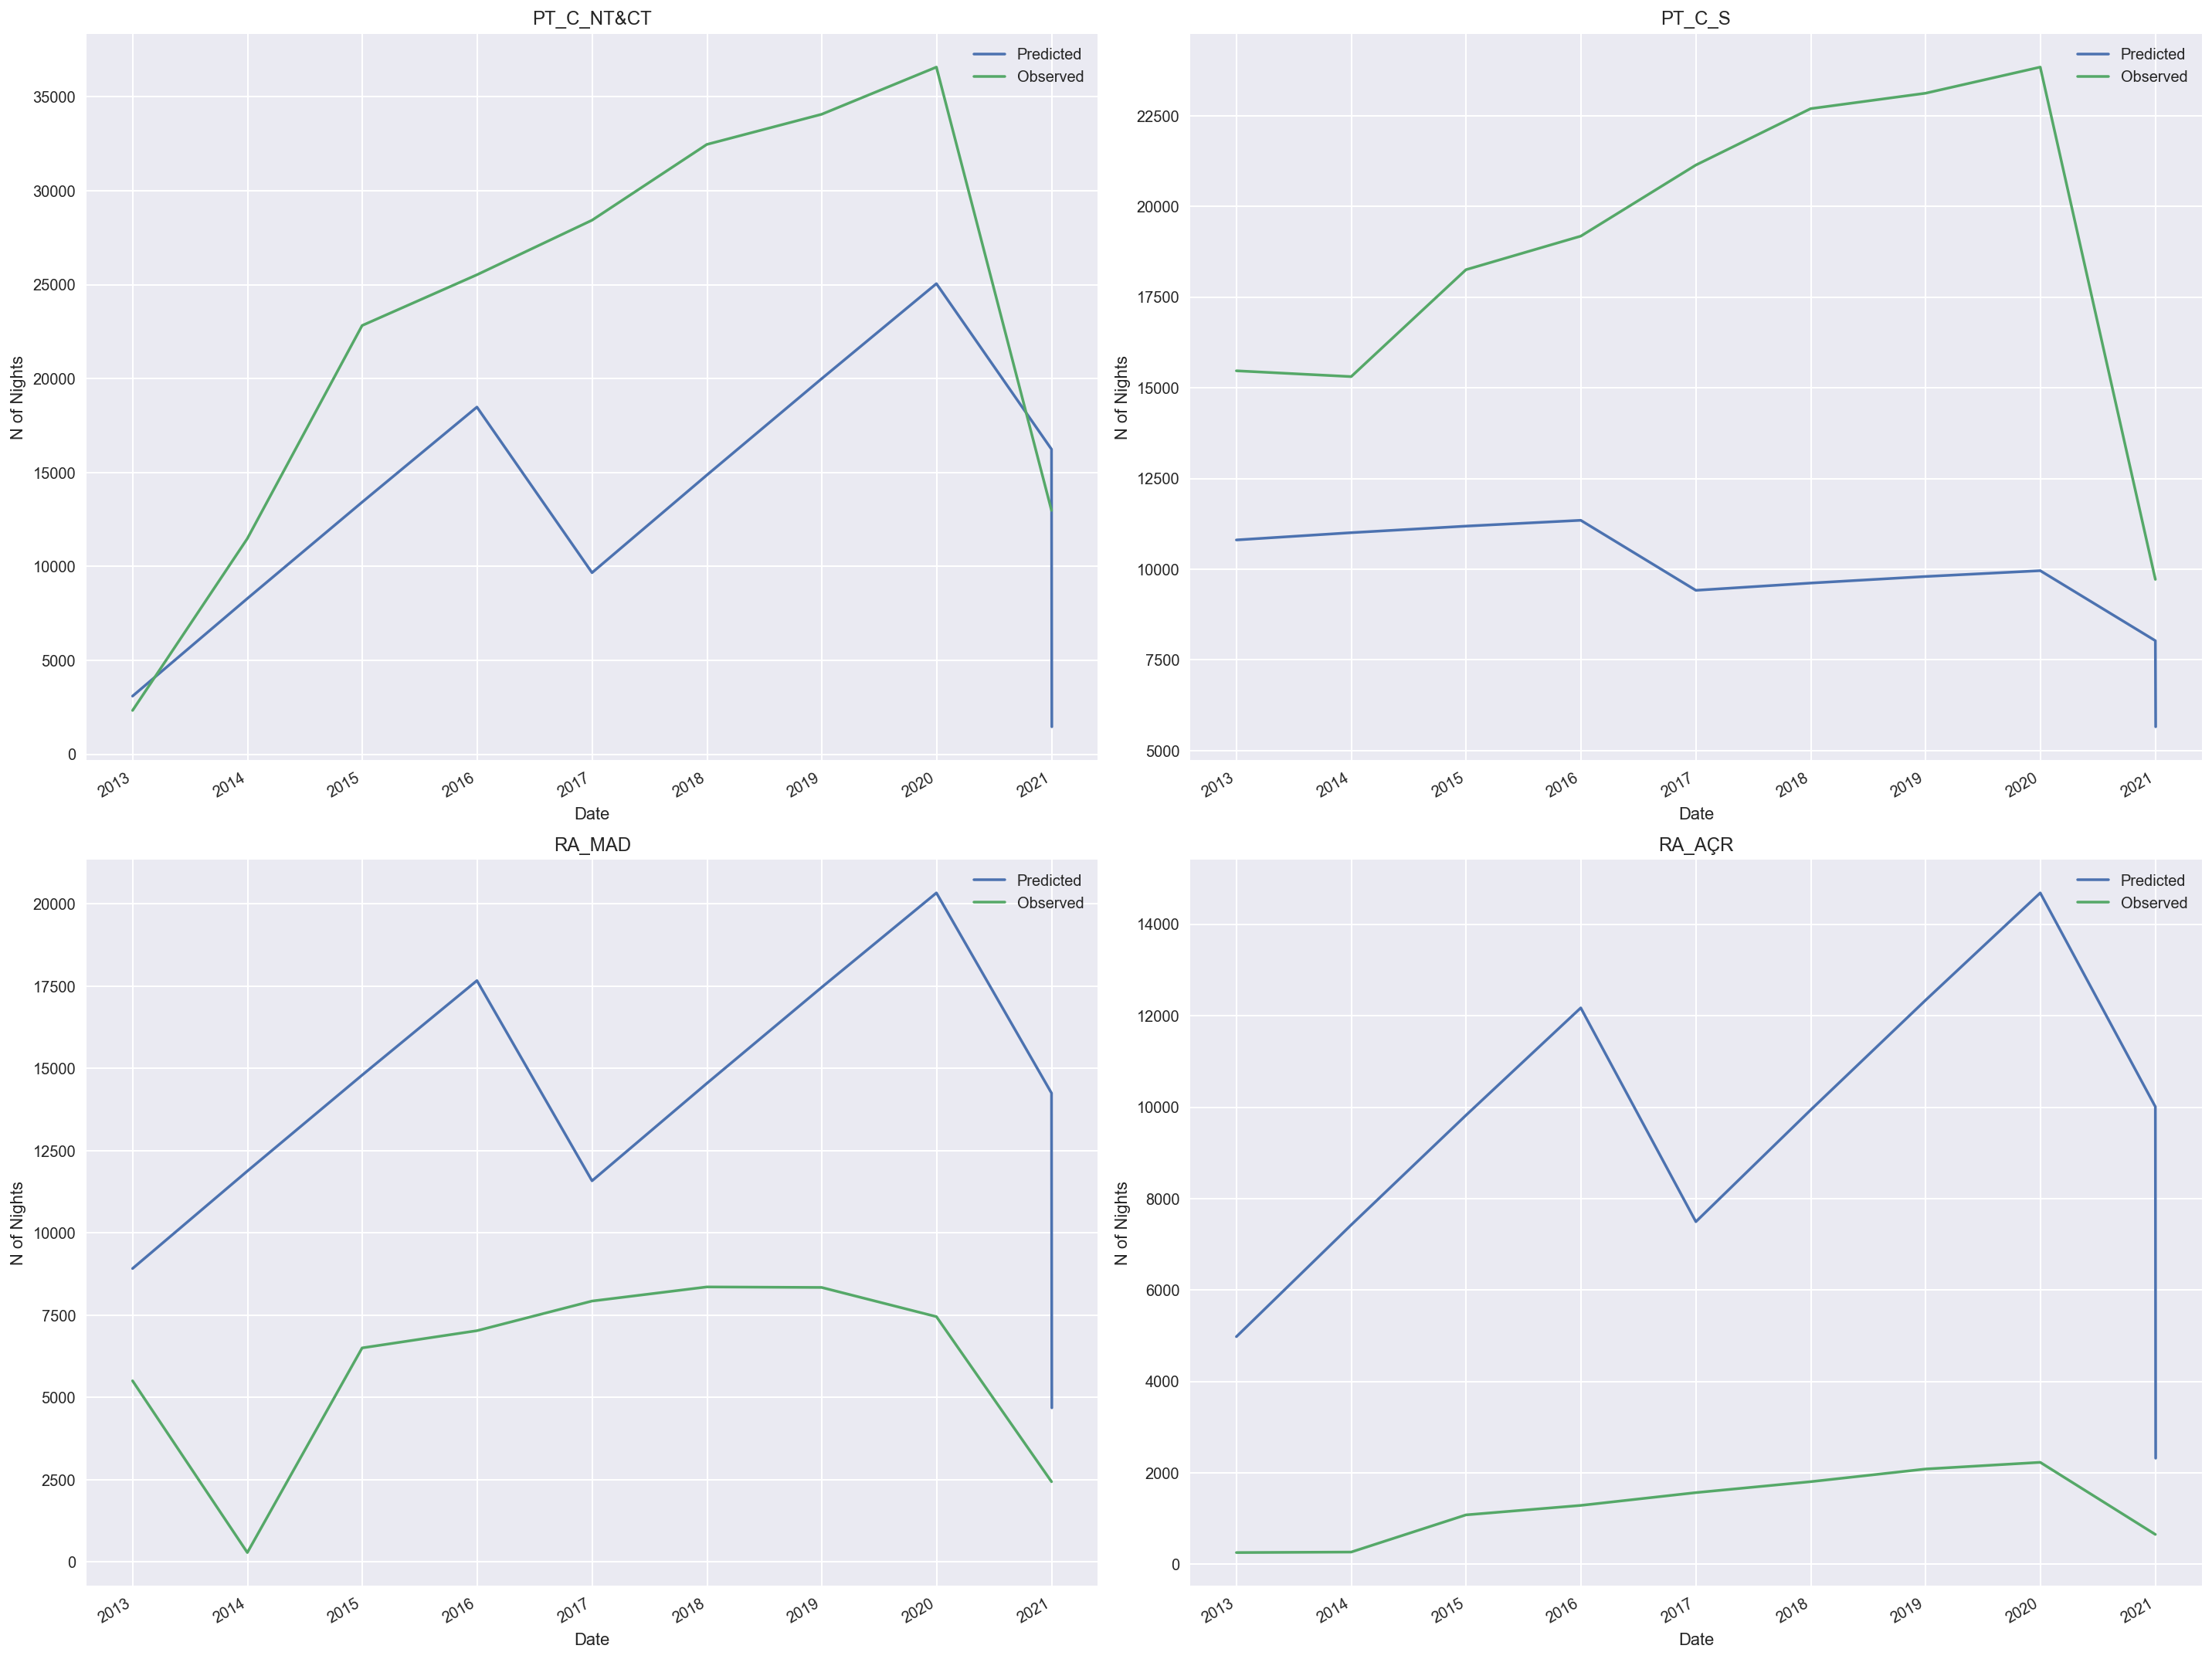

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_prophet_wlsv)
plt.tight_layout()